In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import datetime
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
def get_working_dir():
    return Path.cwd()

processed_dir = get_working_dir() / 'data' / 'processed'
os.makedirs(processed_dir, exist_ok=True)

df_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_phase6.csv', encoding='utf-8')
df_m = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_phase7.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() /  'data' / 'processed' / 'm_t_phase6.csv', encoding='utf-8')

In [3]:
processed_dir = get_working_dir() / 'data' / 'processed'
os.makedirs(processed_dir, exist_ok=True)

# Create plots/demographics directory
results_dir = get_working_dir() / 'plots' / 'corrections'
os.makedirs(results_dir, exist_ok=True)

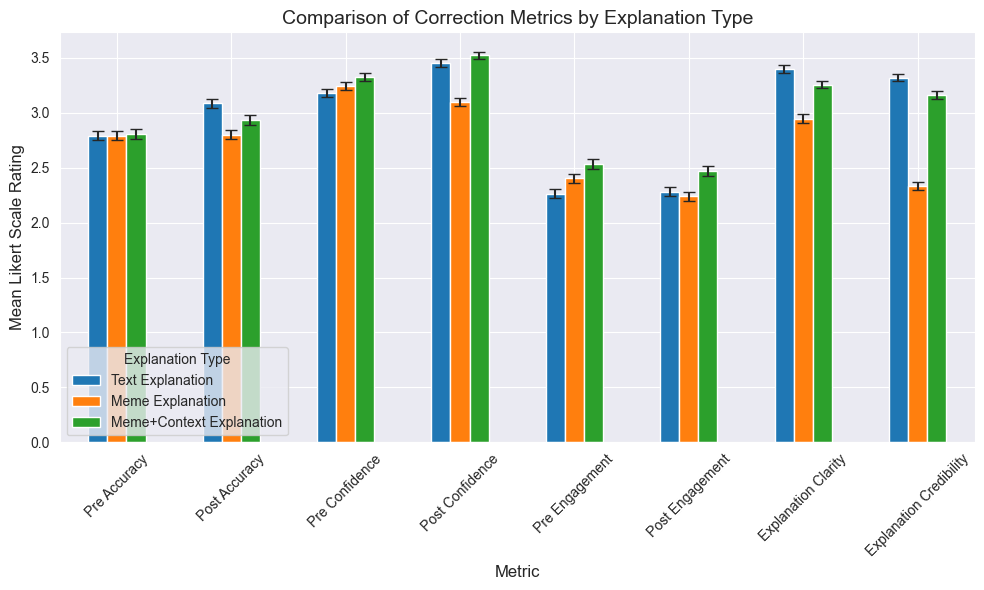

In [10]:
import pandas.api.types as ptypes

# --- Define Mapping Dictionaries ---
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# --- Convert Likert Responses to Numeric Values ---
def convert_likert_values(df):
    # Loop through columns and only process if the column's dtype is string-like.
    for col in df.columns:
        if ptypes.is_string_dtype(df[col]):
            # Strip extra whitespace and apply mapping based on keywords in the column name.
            if "accuracy" in col:
                df[col] = df[col].str.strip().map(accuracy_mapping)
            elif "confidence" in col:
                df[col] = df[col].str.strip().map(confidence_mapping)
            elif "engagement" in col:
                df[col] = df[col].str.strip().map(engagement_mapping)
            elif "explainability" in col:
                df[col] = df[col].str.strip().map(explainability_mapping)
            elif "credibility" in col:
                df[col] = df[col].str.strip().map(credibility_mapping)
    return df

df_t   = convert_likert_values(df_t)
df_m   = convert_likert_values(df_m)
df_m_t = convert_likert_values(df_m_t)

# --- Compute Metric Means and Standard Errors ---
def compute_metric_stats(df):
    # Define the eight metric keys.
    metric_keys = [
        'pre_accuracy', 'pre_confidence', 'pre_engagement',
        'post_accuracy', 'post_confidence', 'post_engagement',
        'correction_explainability', 'correction_credibility'
    ]
    means = {}
    errs  = {}
    # For each metric, collect responses over all 10 claims.
    for metric in metric_keys:
        series_list = []
        for i in range(1, 11):
            col_name = f"claim{i}_{metric}"
            if col_name in df.columns:
                series_list.append(df[col_name])
        if series_list:
            all_values = pd.concat(series_list)
            means[metric] = all_values.mean()
            # Standard error: std deviation divided by sqrt(n)
            errs[metric] = all_values.std(ddof=1) / np.sqrt(all_values.count())
        else:
            means[metric] = np.nan
            errs[metric] = np.nan
    return means, errs

metrics_text_means,   metrics_text_err  = compute_metric_stats(df_t)
metrics_meme_means,   metrics_meme_err  = compute_metric_stats(df_m)
metrics_memeCt_means, metrics_memeCt_err = compute_metric_stats(df_m_t)

# --- Prepare Data for Plotting ---
# New ordering: paired pre and post for accuracy, confidence, engagement, then explanation metrics.
metrics_order = [
    'pre_accuracy', 'post_accuracy',
    'pre_confidence', 'post_confidence',
    'pre_engagement', 'post_engagement',
    'correction_explainability', 'correction_credibility'
]

# Create DataFrames for the means and the error bars.
results_means = pd.DataFrame({
    'Text Explanation': metrics_text_means,
    'Meme Explanation': metrics_meme_means,
    'Meme+Context Explanation': metrics_memeCt_means
}).loc[metrics_order]

results_err = pd.DataFrame({
    'Text Explanation': metrics_text_err,
    'Meme Explanation': metrics_meme_err,
    'Meme+Context Explanation': metrics_memeCt_err
}).loc[metrics_order]

# (Optional) Rename the index labels for a nicer appearance.
label_mapping = {
    'pre_accuracy': 'Pre Accuracy',
    'post_accuracy': 'Post Accuracy',
    'pre_confidence': 'Pre Confidence',
    'post_confidence': 'Post Confidence',
    'pre_engagement': 'Pre Engagement',
    'post_engagement': 'Post Engagement',
    'correction_explainability': 'Explanation Clarity',
    'correction_credibility': 'Explanation Credibility'
}
results_means.index = [label_mapping[m] for m in results_means.index]
results_err.index   = [label_mapping[m] for m in results_err.index]

# --- Plotting the Results with Confidence Intervals ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the grouped bar chart with error bars.
results_means.plot(kind='bar', yerr=results_err, capsize=4, ax=ax)

ax.set_title("Comparison of Correction Metrics by Explanation Type", fontsize=14)
ax.set_ylabel("Mean Likert Scale Rating", fontsize=12)
ax.set_xlabel("Metric", fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Explanation Type", fontsize=10)

plt.tight_layout()

# Save the figure with a timestamped filename.
plot_filename = results_dir / f"correction_metrics_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(plot_filename)
plt.show()

# Comparison between human generated and AI generated results

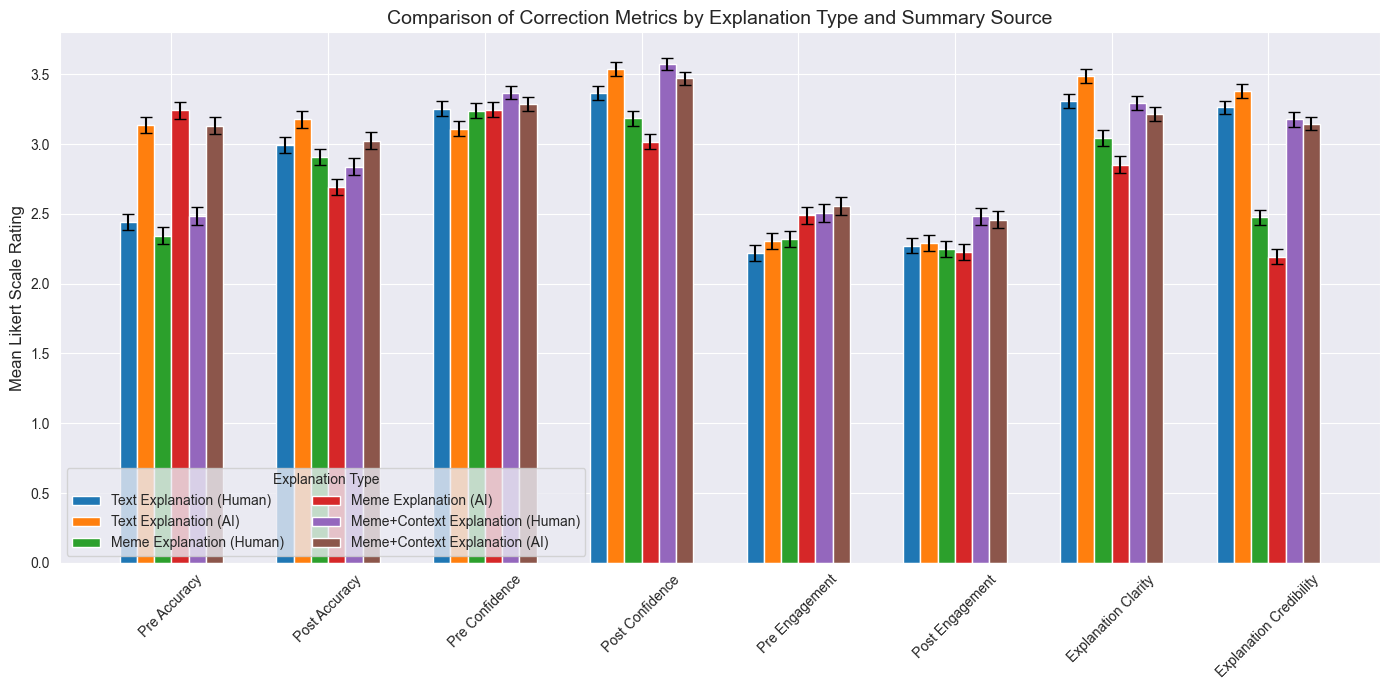

In [13]:
# Load the meta file containing claim summary types.
meta_df = pd.read_csv(get_working_dir() / 'data' / 'dataset_meta_study.csv', encoding='utf-8')
# Ensure there is a 'claim' column (using row order if not provided).
if 'claim_no' in meta_df.columns:
    meta_df['claim_no'] = meta_df['claim_no'].astype(int)
else:
    meta_df['claim_no'] = meta_df.index + 1

# Get claim numbers for human and AI summaries.
human_claims = meta_df.loc[meta_df['summary_type'] == 'human', 'claim_no'].tolist()
ai_claims    = meta_df.loc[meta_df['summary_type'] == 'ai', 'claim_no'].tolist()

results_dir = get_working_dir() / 'plots' / 'corrections'
os.makedirs(results_dir, exist_ok=True)

# --- Define Mapping Dictionaries ---
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# --- Convert Likert Responses to Numeric Values ---
def convert_likert_values(df):
    for col in df.columns:
        # Only process columns with string type.
        if ptypes.is_string_dtype(df[col]):
            if "accuracy" in col:
                df[col] = df[col].str.strip().map(accuracy_mapping)
            elif "confidence" in col:
                df[col] = df[col].str.strip().map(confidence_mapping)
            elif "engagement" in col:
                df[col] = df[col].str.strip().map(engagement_mapping)
            elif "explainability" in col:
                df[col] = df[col].str.strip().map(explainability_mapping)
            elif "credibility" in col:
                df[col] = df[col].str.strip().map(credibility_mapping)
    return df

df_t   = convert_likert_values(df_t)
df_m   = convert_likert_values(df_m)
df_m_t = convert_likert_values(df_m_t)

# --- Compute Metric Statistics for a Given Set of Claims ---
def compute_metric_stats_by_claims(df, allowed_claims):
    metric_keys = [
        'pre_accuracy', 'pre_confidence', 'pre_engagement',
        'post_accuracy', 'post_confidence', 'post_engagement',
        'correction_explainability', 'correction_credibility'
    ]
    means = {}
    errs  = {}
    for metric in metric_keys:
        series_list = []
        for i in allowed_claims:
            col_name = f"claim{i}_{metric}"
            if col_name in df.columns:
                series_list.append(df[col_name])
        if series_list:
            all_values = pd.concat(series_list)
            means[metric] = all_values.mean()
            errs[metric] = all_values.std(ddof=1) / np.sqrt(all_values.count())
        else:
            means[metric] = np.nan
            errs[metric] = np.nan
    return means, errs

# --- Compute Stats Separately for Human and AI Explanations in Each Study ---
# For human-generated explanations:
metrics_text_means_human,   metrics_text_err_human   = compute_metric_stats_by_claims(df_t, human_claims)
metrics_meme_means_human,   metrics_meme_err_human   = compute_metric_stats_by_claims(df_m, human_claims)
metrics_memeCt_means_human, metrics_memeCt_err_human = compute_metric_stats_by_claims(df_m_t, human_claims)
# For AI-generated explanations:
metrics_text_means_ai,   metrics_text_err_ai   = compute_metric_stats_by_claims(df_t, ai_claims)
metrics_meme_means_ai,   metrics_meme_err_ai   = compute_metric_stats_by_claims(df_m, ai_claims)
metrics_memeCt_means_ai, metrics_memeCt_err_ai = compute_metric_stats_by_claims(df_m_t, ai_claims)

# --- Combine Data into Single DataFrames ---
# We'll order the metrics as: paired pre/post for accuracy, confidence, engagement, then explanation clarity and credibility.
metrics_order = [
    'pre_accuracy', 'post_accuracy',
    'pre_confidence', 'post_confidence',
    'pre_engagement', 'post_engagement',
    'correction_explainability', 'correction_credibility'
]
# Create nice labels.
label_mapping = {
    'pre_accuracy': 'Pre Accuracy',
    'post_accuracy': 'Post Accuracy',
    'pre_confidence': 'Pre Confidence',
    'post_confidence': 'Post Confidence',
    'pre_engagement': 'Pre Engagement',
    'post_engagement': 'Post Engagement',
    'correction_explainability': 'Explanation Clarity',
    'correction_credibility': 'Explanation Credibility'
}
metric_labels = [label_mapping[m] for m in metrics_order]

# Explanation types (columns) in the original analysis.
explanation_types = ["Text Explanation", "Meme Explanation", "Meme+Context Explanation"]

# Build combined DataFrames for means and errors with multi-columns: for each explanation type we have Human and AI.
combined_cols = []
for expl in explanation_types:
    combined_cols.append(f"{expl} (Human)")
    combined_cols.append(f"{expl} (AI)")

# Initialize containers for merged values and errors.
merged_means = pd.DataFrame(index=metric_labels, columns=combined_cols)
merged_err   = pd.DataFrame(index=metric_labels, columns=combined_cols)

# For each metric (row) and for each explanation type, assign the human and AI values.
for idx, m_key in enumerate(metrics_order):
    row_label = label_mapping[m_key]
    # For each explanation type:
    for expl in explanation_types:
        merged_means.loc[row_label, f"{expl} (Human)"] = {
            "Text Explanation": metrics_text_means_human,
            "Meme Explanation": metrics_meme_means_human,
            "Meme+Context Explanation": metrics_memeCt_means_human
        }[expl][m_key]
        merged_means.loc[row_label, f"{expl} (AI)"] = {
            "Text Explanation": metrics_text_means_ai,
            "Meme Explanation": metrics_meme_means_ai,
            "Meme+Context Explanation": metrics_memeCt_means_ai
        }[expl][m_key]
        
        merged_err.loc[row_label, f"{expl} (Human)"] = {
            "Text Explanation": metrics_text_err_human,
            "Meme Explanation": metrics_meme_err_human,
            "Meme+Context Explanation": metrics_memeCt_err_human
        }[expl][m_key]
        merged_err.loc[row_label, f"{expl} (AI)"] = {
            "Text Explanation": metrics_text_err_ai,
            "Meme Explanation": metrics_meme_err_ai,
            "Meme+Context Explanation": metrics_memeCt_err_ai
        }[expl][m_key]

# Convert the values to float.
merged_means = merged_means.astype(float)
merged_err   = merged_err.astype(float)

# --- Plot Merged Graph with Grouped Bars and Error Bars ---
# We have 8 metric groups (rows) and 6 bars per group.
n_metrics = len(metric_labels)
n_bars = len(combined_cols)
x = np.arange(n_metrics)
width = 0.11  # width for each bar

# Calculate offsets to center the group of bars.
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * width

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each bar series.
for i, col in enumerate(combined_cols):
    ax.bar(x + offsets[i],
           merged_means[col].values,
           width,
           yerr=merged_err[col].values,
           capsize=4,
           label=col)

ax.set_xticks(x)
ax.set_xticklabels(metric_labels, rotation=45, fontsize=10)
ax.set_ylabel("Mean Likert Scale Rating", fontsize=12)
ax.set_title("Comparison of Correction Metrics by Explanation Type and Summary Source", fontsize=14)
ax.legend(title="Explanation Type", fontsize=10, ncol=2)
plt.tight_layout()

# Save and show the figure.
plot_filename = results_dir / f"merged_correction_metrics_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(plot_filename)
plt.show()


# Corrections results for pro republican, pro democrat and neutral claims

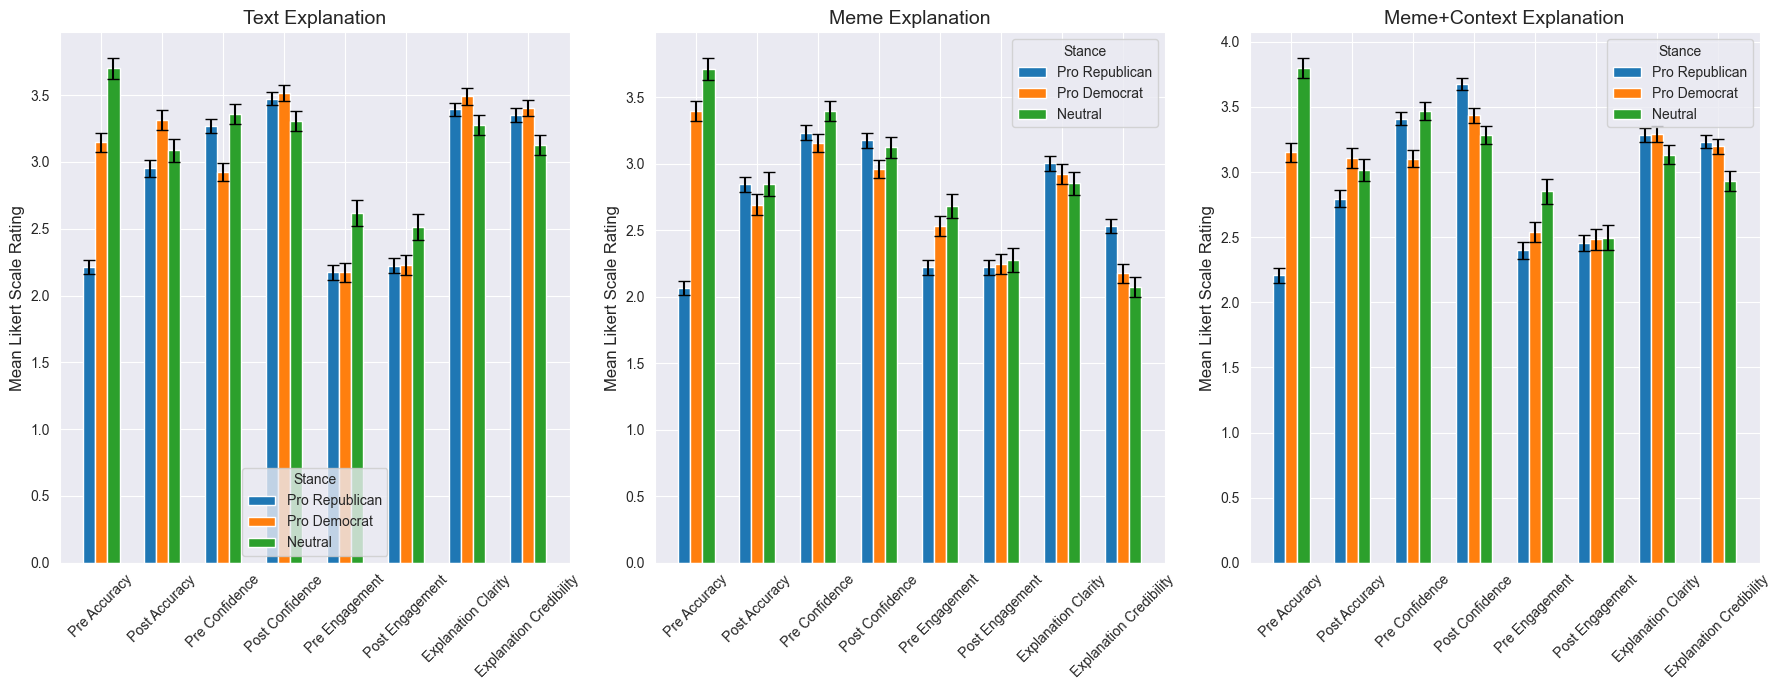

In [14]:
# If there is no explicit 'claim' column, create one from the row index (starting at 1)
if 'claim_no' not in meta_df.columns:
    meta_df['claim_no'] = meta_df.index + 1
else:
    meta_df['claim_no'] = meta_df['claim_no'].astype(int)

# --- Create Claim Lists by Stance ---
pro_rep_claims = meta_df.loc[meta_df['stance'] == 'pro republican', 'claim_no'].tolist()
pro_dem_claims = meta_df.loc[meta_df['stance'] == 'pro democrat', 'claim_no'].tolist()
neutral_claims = meta_df.loc[meta_df['stance'] == 'neutral', 'claim_no'].tolist()

results_dir = get_working_dir() / 'plots' / 'corrections'
os.makedirs(results_dir, exist_ok=True)

# --- Define Mapping Dictionaries ---
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# --- Convert Likert Responses to Numeric Values ---
def convert_likert_values(df):
    for col in df.columns:
        # Only process columns that are string-like.
        if ptypes.is_string_dtype(df[col]):
            if "accuracy" in col:
                df[col] = df[col].str.strip().map(accuracy_mapping)
            elif "confidence" in col:
                df[col] = df[col].str.strip().map(confidence_mapping)
            elif "engagement" in col:
                df[col] = df[col].str.strip().map(engagement_mapping)
            elif "explainability" in col:
                df[col] = df[col].str.strip().map(explainability_mapping)
            elif "credibility" in col:
                df[col] = df[col].str.strip().map(credibility_mapping)
    return df

df_t   = convert_likert_values(df_t)
df_m   = convert_likert_values(df_m)
df_m_t = convert_likert_values(df_m_t)

# --- Compute Metric Statistics for a Given Set of Claims ---
def compute_metric_stats_by_claims(df, allowed_claims):
    # Define the eight metric keys.
    metric_keys = [
        'pre_accuracy', 'pre_confidence', 'pre_engagement',
        'post_accuracy', 'post_confidence', 'post_engagement',
        'correction_explainability', 'correction_credibility'
    ]
    means = {}
    errs  = {}
    for metric in metric_keys:
        series_list = []
        for i in allowed_claims:
            col_name = f"claim{i}_{metric}"
            if col_name in df.columns:
                series_list.append(df[col_name])
        if series_list:
            all_values = pd.concat(series_list)
            means[metric] = all_values.mean()
            errs[metric]  = all_values.std(ddof=1) / np.sqrt(all_values.count())
        else:
            means[metric] = np.nan
            errs[metric]  = np.nan
    return means, errs

# --- Compute Stats for Each Explanation Type by Stance ---
# For Text Explanation:
text_prorep_means, text_prorep_err = compute_metric_stats_by_claims(df_t, pro_rep_claims)
text_prodem_means, text_prodem_err = compute_metric_stats_by_claims(df_t, pro_dem_claims)
text_neutral_means, text_neutral_err = compute_metric_stats_by_claims(df_t, neutral_claims)

# For Meme Explanation:
meme_prorep_means, meme_prorep_err = compute_metric_stats_by_claims(df_m, pro_rep_claims)
meme_prodem_means, meme_prodem_err = compute_metric_stats_by_claims(df_m, pro_dem_claims)
meme_neutral_means, meme_neutral_err = compute_metric_stats_by_claims(df_m, neutral_claims)

# For Meme+Context Explanation:
memeCt_prorep_means, memeCt_prorep_err = compute_metric_stats_by_claims(df_m_t, pro_rep_claims)
memeCt_prodem_means, memeCt_prodem_err = compute_metric_stats_by_claims(df_m_t, pro_dem_claims)
memeCt_neutral_means, memeCt_neutral_err = compute_metric_stats_by_claims(df_m_t, neutral_claims)

# --- Combine Results into DataFrames ---
# Define the metric order (and labels) as: pre/post accuracy, pre/post confidence, pre/post engagement, explanation clarity, explanation credibility.
metrics_order = [
    'pre_accuracy', 'post_accuracy',
    'pre_confidence', 'post_confidence',
    'pre_engagement', 'post_engagement',
    'correction_explainability', 'correction_credibility'
]
label_mapping = {
    'pre_accuracy': 'Pre Accuracy',
    'post_accuracy': 'Post Accuracy',
    'pre_confidence': 'Pre Confidence',
    'post_confidence': 'Post Confidence',
    'pre_engagement': 'Pre Engagement',
    'post_engagement': 'Post Engagement',
    'correction_explainability': 'Explanation Clarity',
    'correction_credibility': 'Explanation Credibility'
}
metric_labels = [label_mapping[m] for m in metrics_order]

# Build DataFrames for each explanation type (rows = metrics, columns = stance groups)
text_means_df = pd.DataFrame({
    "Pro Republican": text_prorep_means,
    "Pro Democrat": text_prodem_means,
    "Neutral": text_neutral_means
}).loc[metrics_order]
text_err_df = pd.DataFrame({
    "Pro Republican": text_prorep_err,
    "Pro Democrat": text_prodem_err,
    "Neutral": text_neutral_err
}).loc[metrics_order]
text_means_df.index = metric_labels
text_err_df.index   = metric_labels

meme_means_df = pd.DataFrame({
    "Pro Republican": meme_prorep_means,
    "Pro Democrat": meme_prodem_means,
    "Neutral": meme_neutral_means
}).loc[metrics_order]
meme_err_df = pd.DataFrame({
    "Pro Republican": meme_prorep_err,
    "Pro Democrat": meme_prodem_err,
    "Neutral": meme_neutral_err
}).loc[metrics_order]
meme_means_df.index = metric_labels
meme_err_df.index   = metric_labels

memeCt_means_df = pd.DataFrame({
    "Pro Republican": memeCt_prorep_means,
    "Pro Democrat": memeCt_prodem_means,
    "Neutral": memeCt_neutral_means
}).loc[metrics_order]
memeCt_err_df = pd.DataFrame({
    "Pro Republican": memeCt_prorep_err,
    "Pro Democrat": memeCt_prodem_err,
    "Neutral": memeCt_neutral_err
}).loc[metrics_order]
memeCt_means_df.index = metric_labels
memeCt_err_df.index   = metric_labels

# --- Plotting ---
# We create one figure with three subplots (one per explanation type)
fig, axes = plt.subplots(ncols=3, figsize=(18, 7))
explanation_titles = ["Text Explanation", "Meme Explanation", "Meme+Context Explanation"]

# A helper function to plot a grouped bar chart for one explanation type.
def plot_grouped_bars(ax, means_df, err_df, title):
    n_metrics = len(means_df)
    n_groups = means_df.shape[1]  # three stance groups
    x = np.arange(n_metrics)
    width = 0.2  # width for each bar
    offsets = (np.arange(n_groups) - (n_groups - 1) / 2) * width

    for i, col in enumerate(means_df.columns):
        ax.bar(x + offsets[i],
               means_df[col].values,
               width,
               yerr=err_df[col].values,
               capsize=4,
               label=col)
    ax.set_xticks(x)
    ax.set_xticklabels(means_df.index, rotation=45, fontsize=10)
    ax.set_ylabel("Mean Likert Scale Rating", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(title="Stance", fontsize=10)

plot_grouped_bars(axes[0], text_means_df, text_err_df, explanation_titles[0])
plot_grouped_bars(axes[1], meme_means_df, meme_err_df, explanation_titles[1])
plot_grouped_bars(axes[2], memeCt_means_df, memeCt_err_df, explanation_titles[2])

plt.tight_layout()

# Save and show the merged figure.
plot_filename = results_dir / f"correction_metrics_by_stance_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(plot_filename)
plt.show()


# Backfire effect or not?

In [15]:
from scipy.stats import ttest_1samp
import numpy as np

# Function to compute the accuracy change (post - pre) for each claim and then average per participant.
def compute_accuracy_change(df):
    diff_columns = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            diff_col = f"claim{i}_accuracy_change"
            df[diff_col] = df[post_col] - df[pre_col]
            diff_columns.append(diff_col)
    # Compute each participant's average change across the 10 claims.
    df["mean_accuracy_change"] = df[diff_columns].mean(axis=1)
    return df["mean_accuracy_change"]

# Compute the change score for each explanation type dataset.
text_accuracy_change   = compute_accuracy_change(df_t)
meme_accuracy_change   = compute_accuracy_change(df_m)
memeCt_accuracy_change = compute_accuracy_change(df_m_t)

# Function to perform a one-sample t-test against 0 and print summary statistics.
def analyze_change(change_series, label):
    # Drop any missing values.
    change_series = change_series.dropna()
    t_stat, p_val = ttest_1samp(change_series, 0)
    mean_change = change_series.mean()
    # Proportion of participants with an increase (backfire effect) or decrease (effective correction)
    prop_backfire = (change_series > 0).mean()
    prop_effective = (change_series < 0).mean()
    
    print(f"{label}:")
    print(f"  Mean accuracy change: {mean_change:.3f}")
    print(f"  T-test: t = {t_stat:.3f}, p = {p_val:.3f}")
    print(f"  Proportion with backfire (increase): {prop_backfire:.2%}")
    print(f"  Proportion with effective reduction (decrease): {prop_effective:.2%}")
    print("-------")

# Analyze the plots for each explanation type.
analyze_change(text_accuracy_change, "Text Explanation")
analyze_change(meme_accuracy_change, "Meme Explanation")
analyze_change(memeCt_accuracy_change, "Meme+Context Explanation")

Text Explanation:
  Mean accuracy change: 0.295
  T-test: t = 3.471, p = 0.001
  Proportion with backfire (increase): 58.18%
  Proportion with effective reduction (decrease): 37.27%
-------
Meme Explanation:
  Mean accuracy change: 0.006
  T-test: t = 0.094, p = 0.925
  Proportion with backfire (increase): 39.60%
  Proportion with effective reduction (decrease): 49.50%
-------
Meme+Context Explanation:
  Mean accuracy change: 0.125
  T-test: t = 1.391, p = 0.167
  Proportion with backfire (increase): 48.04%
  Proportion with effective reduction (decrease): 47.06%
-------


In [19]:
from scipy.stats import ttest_rel

if 'claim_no' not in meta_df.columns:
    meta_df['claim_no'] = meta_df.index + 1
else:
    meta_df['claim_no'] = meta_df['claim_no'].astype(int)

results_dir = get_working_dir() / 'plots' / 'corrections'
os.makedirs(results_dir, exist_ok=True)

# --- Convert Likert Responses for Accuracy to Numeric Values ---
def convert_likert_values(df):
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    for col in df.columns:
        if ptypes.is_string_dtype(df[col]) and "accuracy" in col:
            df[col] = df[col].str.strip().map(accuracy_mapping)
    return df

df_t   = convert_likert_values(df_t)
df_m   = convert_likert_values(df_m)
df_m_t = convert_likert_values(df_m_t)

# --- Compute Accuracy Change Scores by Summary Type ---
def compute_accuracy_change_by_summary_type(df, meta_df):
    # Get claim numbers for human and AI explanations from the meta file.
    human_claims = meta_df.loc[meta_df['summary_type'] == 'human', 'claim_no'].tolist()
    ai_claims    = meta_df.loc[meta_df['summary_type'] == 'ai', 'claim_no'].tolist()
    
    # Compute per-claim change scores for human explanations.
    human_changes = []
    for i in human_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            human_changes.append(df[post_col] - df[pre_col])
    if human_changes:
        human_change = pd.concat(human_changes, axis=1).mean(axis=1)
    else:
        human_change = pd.Series(np.nan, index=df.index)
    
    # Compute per-claim change scores for AI explanations.
    ai_changes = []
    for i in ai_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            ai_changes.append(df[post_col] - df[pre_col])
    if ai_changes:
        ai_change = pd.concat(ai_changes, axis=1).mean(axis=1)
    else:
        ai_change = pd.Series(np.nan, index=df.index)
    
    return human_change, ai_change

# --- Compare Backfire Effect for Human vs. AI Explanations ---
def analyze_summary_type_backfire(df, meta_df, label):
    # Compute change scores (post - pre) for human and AI explanations.
    human_change, ai_change = compute_accuracy_change_by_summary_type(df, meta_df)
    
    # Consider only participants with non-missing values in both groups.
    valid_idx = human_change.dropna().index.intersection(ai_change.dropna().index)
    human_change = human_change.loc[valid_idx]
    ai_change = ai_change.loc[valid_idx]
    
    # Paired t-test comparing human vs. AI change scores.
    t_stat, p_val = ttest_rel(human_change, ai_change)
    
    mean_human = human_change.mean()
    mean_ai    = ai_change.mean()
    
    # Proportion with backfire (positive change) and with effective decrease (negative change)
    prop_backfire_human = (human_change > 0).mean()
    prop_effective_human = (human_change < 0).mean()
    prop_backfire_ai = (ai_change > 0).mean()
    prop_effective_ai = (ai_change < 0).mean()
    
    # Format p-value for display.
    #print(p_val)
    p_str = f"{p_val:.4f}" if p_val >= 0.001 else "< 0.001"
    
    print(f"{label}:")
    print(f"  Human - Mean Accuracy Change: {mean_human:.3f}, Proportion with backfire (increase): {prop_backfire_human:.2%}, Proportion with effective decrease: {prop_effective_human:.2%}")
    print(f"  AI    - Mean Accuracy Change: {mean_ai:.3f}, Proportion with backfire (increase): {prop_backfire_ai:.2%}, Proportion with effective decrease: {prop_effective_ai:.2%}")
    print(f"  Paired t-test comparing human vs. AI: t = {t_stat:.3f}, p = {p_str}")
    print("-------")

# --- Run the Analysis for Each Explanation Type ---
analyze_summary_type_backfire(df_t, meta_df, "Text Explanation")
analyze_summary_type_backfire(df_m, meta_df, "Meme Explanation")
analyze_summary_type_backfire(df_m_t, meta_df, "Meme+Context Explanation")

Text Explanation:
  Human - Mean Accuracy Change: 0.551, Proportion with backfire (increase): 61.82%, Proportion with effective decrease: 31.82%
  AI    - Mean Accuracy Change: 0.040, Proportion with backfire (increase): 47.27%, Proportion with effective decrease: 45.45%
  Paired t-test comparing human vs. AI: t = 4.839, p = < 0.001
-------
Meme Explanation:
  Human - Mean Accuracy Change: 0.562, Proportion with backfire (increase): 57.43%, Proportion with effective decrease: 24.75%
  AI    - Mean Accuracy Change: -0.550, Proportion with backfire (increase): 16.83%, Proportion with effective decrease: 70.30%
  Paired t-test comparing human vs. AI: t = 9.104, p = < 0.001
-------
Meme+Context Explanation:
  Human - Mean Accuracy Change: 0.355, Proportion with backfire (increase): 49.02%, Proportion with effective decrease: 42.16%
  AI    - Mean Accuracy Change: -0.106, Proportion with backfire (increase): 40.20%, Proportion with effective decrease: 51.96%
  Paired t-test comparing human 

# Backfire effect among political orientation

In [21]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime
import pandas.api.types as ptypes

# --- Setup Directories and Load Data ---
def get_working_dir():
    return Path.cwd()

processed_dir = get_working_dir() / 'data' / 'processed'
results_dir   = get_working_dir() / 'plots' / 'corrections'
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load phase files with correction metrics.
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_phase6.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_phase7.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_phase6.csv', encoding='utf-8')

# Load corresponding demographics files.
demo_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv', encoding='utf-8')
demo_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv', encoding='utf-8')
demo_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv', encoding='utf-8')

# Merge the phase data with demographics on prolific_id.
df_t_merged   = df_t.merge(demo_t[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
df_m_merged   = df_m.merge(demo_m[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
df_m_t_merged = df_m_t.merge(demo_m_t[['prolific_id', 'political_orientation']], on='prolific_id', how='left')

# --- Recode Political Orientation ---
def recode_orientation(x):
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return x

df_t_merged['political_orientation']   = df_t_merged['political_orientation'].apply(recode_orientation)
df_m_merged['political_orientation']   = df_m_merged['political_orientation'].apply(recode_orientation)
df_m_t_merged['political_orientation'] = df_m_t_merged['political_orientation'].apply(recode_orientation)

# --- Filter Out "I prefer not to answer" ---
df_t_merged   = df_t_merged[df_t_merged["political_orientation"] != "I prefer not to answer"]
df_m_merged   = df_m_merged[df_m_merged["political_orientation"] != "I prefer not to answer"]
df_m_t_merged = df_m_t_merged[df_m_t_merged["political_orientation"] != "I prefer not to answer"]

# --- Convert Likert Responses for Accuracy to Numeric Values ---
def convert_accuracy(df):
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    for col in df.columns:
        if "accuracy" in col and ptypes.is_string_dtype(df[col]):
            df[col] = df[col].str.strip().map(accuracy_mapping)
    return df

df_t_merged   = convert_accuracy(df_t_merged)
df_m_merged   = convert_accuracy(df_m_merged)
df_m_t_merged = convert_accuracy(df_m_t_merged)

# --- Compute Average Accuracy Change (Post - Pre) for Each Participant ---
def compute_accuracy_change(df):
    diff_cols = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            diff_cols.append(df[post_col] - df[pre_col])
    if diff_cols:
        return pd.concat(diff_cols, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

df_t_merged["accuracy_change"]   = compute_accuracy_change(df_t_merged)
df_m_merged["accuracy_change"]   = compute_accuracy_change(df_m_merged)
df_m_t_merged["accuracy_change"] = compute_accuracy_change(df_m_t_merged)

# --- Summarize Backfire Effects by Political Orientation ---
def summarize_by_orientation(df, label):
    group = df.groupby("political_orientation")["accuracy_change"]
    summary = group.agg(["mean", "count", "std"])
    prop_backfire = group.apply(lambda x: (x > 0).mean())  # proportion with backfire (positive change)
    prop_effective = group.apply(lambda x: (x < 0).mean())  # proportion with effective decrease
    print(f"{label} - Backfire Effects by Political Orientation:")
    for orientation in summary.index:
        mean_val = summary.loc[orientation, "mean"]
        count = summary.loc[orientation, "count"]
        std = summary.loc[orientation, "std"]
        pb = prop_backfire[orientation]
        pe = prop_effective[orientation]
        print(f"  {orientation}: Mean Change = {mean_val:.3f}, Count = {count}, Std = {std:.3f}, "
              f"Proportion Backfire = {pb:.2%}, Proportion Effective = {pe:.2%}")
    print("-------")

summarize_by_orientation(df_t_merged,   "Text Explanation")
summarize_by_orientation(df_m_merged,   "Meme Explanation")
summarize_by_orientation(df_m_t_merged, "Meme+Context Explanation")

Text Explanation - Backfire Effects by Political Orientation:
  Conservative: Mean Change = 0.251, Count = 39, Std = 0.835, Proportion Backfire = 56.41%, Proportion Effective = 38.46%
  Liberal: Mean Change = 0.349, Count = 47, Std = 1.031, Proportion Backfire = 59.57%, Proportion Effective = 36.17%
  Moderate: Mean Change = 0.280, Count = 20, Std = 0.744, Proportion Backfire = 60.00%, Proportion Effective = 35.00%
-------
Meme Explanation - Backfire Effects by Political Orientation:
  Conservative: Mean Change = -0.097, Count = 35, Std = 0.556, Proportion Backfire = 34.29%, Proportion Effective = 54.29%
  Liberal: Mean Change = -0.076, Count = 42, Std = 0.618, Proportion Backfire = 33.33%, Proportion Effective = 52.38%
  Moderate: Mean Change = 0.300, Count = 24, Std = 0.698, Proportion Backfire = 58.33%, Proportion Effective = 37.50%
-------
Meme+Context Explanation - Backfire Effects by Political Orientation:
  Conservative: Mean Change = 0.267, Count = 39, Std = 0.918, Proportion B

In [23]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import datetime
import pandas.api.types as ptypes

# --- Setup Directories and Load Data ---
def get_working_dir():
    return Path.cwd()

processed_dir = get_working_dir() / 'data' / 'processed'
results_dir   = get_working_dir() / 'plots' / 'corrections'
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load phase files with correction metrics.
df_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_phase6.csv', encoding='utf-8')
df_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_phase7.csv', encoding='utf-8')
df_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_phase6.csv', encoding='utf-8')

# Load corresponding demographics files.
demo_t   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_demographics.csv', encoding='utf-8')
demo_m   = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_demographics.csv', encoding='utf-8')
demo_m_t = pd.read_csv(get_working_dir() / 'data' / 'processed' / 'm_t_demographics.csv', encoding='utf-8')

# Merge each phase file with its demographics on prolific_id.
df_t_merged   = df_t.merge(demo_t[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
df_m_merged   = df_m.merge(demo_m[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
df_m_t_merged = df_m_t.merge(demo_m_t[['prolific_id', 'political_orientation']], on='prolific_id', how='left')

# --- Recode Political Orientation ---
def recode_orientation(x):
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return x

df_t_merged['political_orientation']   = df_t_merged['political_orientation'].apply(recode_orientation)
df_m_merged['political_orientation']   = df_m_merged['political_orientation'].apply(recode_orientation)
df_m_t_merged['political_orientation'] = df_m_t_merged['political_orientation'].apply(recode_orientation)

# --- Filter Out "I prefer not to answer" ---
df_t_merged   = df_t_merged[df_t_merged["political_orientation"] != "I prefer not to answer"]
df_m_merged   = df_m_merged[df_m_merged["political_orientation"] != "I prefer not to answer"]
df_m_t_merged = df_m_t_merged[df_m_t_merged["political_orientation"] != "I prefer not to answer"]

# --- Load Meta File (with Claim Stance) ---
meta_df = pd.read_csv(get_working_dir() / 'data' / 'dataset_meta_study.csv', encoding='utf-8')
# Ensure a 'claim' column exists (if not, create one based on row order)
if 'claim_no' not in meta_df.columns:
    meta_df['claim_no'] = meta_df.index + 1
else:
    meta_df['claim_no'] = meta_df['claim_no'].astype(int)
# We assume the meta file contains a "stance" column with values: 'pro republican', 'pro democrat', or 'neutral'.

# --- Convert Likert Responses for Accuracy to Numeric Values ---
def convert_accuracy(df):
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    for col in df.columns:
        if "accuracy" in col and ptypes.is_string_dtype(df[col]):
            df[col] = df[col].str.strip().map(accuracy_mapping)
    return df

df_t_merged   = convert_accuracy(df_t_merged)
df_m_merged   = convert_accuracy(df_m_merged)
df_m_t_merged = convert_accuracy(df_m_t_merged)

# --- Build Long-Format DataFrame ---
# We want one row per claim per participant, with:
# - prolific_id, explanation_type, claim (number), accuracy_change, claim_stance, political_orientation.
datasets = {
    "Text Explanation": df_t_merged,
    "Meme Explanation": df_m_merged,
    "Meme+Context Explanation": df_m_t_merged
}

long_data = []
for expl_type, df in datasets.items():
    for idx, row in df.iterrows():
        prolific_id = row["prolific_id"]
        orientation = row["political_orientation"]
        for i in range(1, 11):
            pre_col  = f"claim{i}_pre_accuracy"
            post_col = f"claim{i}_post_accuracy"
            if pre_col in df.columns and post_col in df.columns:
                change = row[post_col] - row[pre_col]
                # Get the stance for this claim from the meta file.
                # (Assumes exactly one row in meta_df for each claim number.)
                stance_val = meta_df.loc[meta_df['claim_no'] == i, 'stance'].values[0]
                long_data.append({
                    "prolific_id": prolific_id,
                    "explanation_type": expl_type,
                    "claim_no": i,
                    "accuracy_change": change,
                    "claim_stance": stance_val,
                    "political_orientation": orientation
                })

long_df = pd.DataFrame(long_data)

# --- Grouping and Summarizing Backfire Effects ---
# Here we group by explanation type, claim stance, and political orientation.
grouped = long_df.groupby(["explanation_type", "claim_stance", "political_orientation"])["accuracy_change"]
summary = grouped.agg(["mean", "count", "std"]).reset_index()

# Calculate proportions for backfire (accuracy_change > 0) and effective decrease (accuracy_change < 0)
prop_backfire = grouped.apply(lambda x: (x > 0).mean()).reset_index(name="prop_backfire")
prop_effective = grouped.apply(lambda x: (x < 0).mean()).reset_index(name="prop_effective")

# Merge the summary stats with the proportions.
summary = summary.merge(prop_backfire, on=["explanation_type", "claim_stance", "political_orientation"])
summary = summary.merge(prop_effective, on=["explanation_type", "claim_stance", "political_orientation"])

# Print plots in a friendly format.
for expl in summary["explanation_type"].unique():
    print(f"--- {expl} ---")
    expl_df = summary[summary["explanation_type"] == expl]
    for stance in expl_df["claim_stance"].unique():
        print(f"Claim Stance: {stance}")
        stance_df = expl_df[expl_df["claim_stance"] == stance]
        for orientation in stance_df["political_orientation"].unique():
            row = stance_df[stance_df["political_orientation"] == orientation].iloc[0]
            print(f"  {orientation}: Mean Change = {row['mean']:.3f}, Count = {int(row['count'])}, Std = {row['std']:.3f}, "
                  f"Backfire = {row['prop_backfire']:.2%}, Effective Decrease = {row['prop_effective']:.2%}")
        print("")
    print("-------")


--- Meme Explanation ---
Claim Stance: neutral
  Conservative: Mean Change = -0.514, Count = 70, Std = 1.482, Backfire = 11.43%, Effective Decrease = 48.57%
  Liberal: Mean Change = -1.250, Count = 84, Std = 1.735, Backfire = 9.52%, Effective Decrease = 60.71%
  Moderate: Mean Change = -0.708, Count = 48, Std = 1.688, Backfire = 14.58%, Effective Decrease = 54.17%

Claim Stance: pro democrat
  Conservative: Mean Change = -0.143, Count = 105, Std = 1.637, Backfire = 25.71%, Effective Decrease = 33.33%
  Liberal: Mean Change = -1.294, Count = 126, Std = 1.575, Backfire = 9.52%, Effective Decrease = 61.11%
  Moderate: Mean Change = -0.486, Count = 72, Std = 1.574, Backfire = 20.83%, Effective Decrease = 51.39%

Claim Stance: pro republican
  Conservative: Mean Change = 0.097, Count = 175, Std = 1.409, Backfire = 25.71%, Effective Decrease = 22.86%
  Liberal: Mean Change = 1.124, Count = 210, Std = 1.667, Backfire = 49.52%, Effective Decrease = 12.38%
  Moderate: Mean Change = 1.175, Count

# Correlation between belief change and age_group, political_orientation

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import os
from pathlib import Path

# --- Define a helper function to get the working directory ---
def get_working_dir():
    return Path.cwd()

# --- Function to process one explanation type ---
def process_explanation_type(label, phase_filename, demo_filename):
    # Load phase file (with correction metrics) and demographics file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df = pd.read_csv(phase_path, encoding='utf-8')
    demo = pd.read_csv(demo_path, encoding='utf-8')
    
    # Merge on prolific_id (keeping only age_group and political_orientation)
    df = df.merge(demo[['prolific_id', 'age_group', 'political_orientation']], on='prolific_id', how='left')
    
    # Filter out rows where age_group or political_orientation equals "I prefer not to answer"
    df = df[(df['age_group'] != "I prefer not to answer") & (df['political_orientation'] != "I prefer not to answer")]
    
    # --- Convert Accuracy Responses (Likert Strings) to Numeric (1-5) ---
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    for col in df.columns:
        if "accuracy" in col and df[col].dtype == object:
            df[col] = df[col].str.strip().map(accuracy_mapping)
    
    # --- Compute Belief Change: Average (post_accuracy - pre_accuracy) across 10 claims ---
    diff_list = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            diff_list.append(df[post_col] - df[pre_col])
    if diff_list:
        df["belief_change"] = pd.concat(diff_list, axis=1).mean(axis=1)
    else:
        df["belief_change"] = np.nan
    
    # --- One-Way ANOVA for Age Groups ---
    age_groups = df.groupby("age_group")["belief_change"].apply(list)
    F_age, p_age = f_oneway(*age_groups)
    
    # --- One-Way ANOVA for Political Orientation ---
    pol_groups = df.groupby("political_orientation")["belief_change"].apply(list)
    F_pol, p_pol = f_oneway(*pol_groups)
    
    print(f"{label}:")
    print("  One-way ANOVA for age_group: F = {:.3f}, p = {:.3f}".format(F_age, p_age))
    print("  One-way ANOVA for political_orientation: F = {:.3f}, p = {:.3f}".format(F_pol, p_pol))
    print("-------\n")
    
# --- Process each explanation type ---
process_explanation_type("Text Explanation", "t_phase6.csv", "t_demographics.csv")
process_explanation_type("Meme Explanation", "m_phase7.csv", "m_demographics.csv")
process_explanation_type("Meme+Context Explanation", "m_t_phase6.csv", "m_t_demographics.csv")


Text Explanation:
  One-way ANOVA for age_group: F = 1.466, p = 0.228
  One-way ANOVA for political_orientation: F = 0.113, p = 0.978
-------

Meme Explanation:
  One-way ANOVA for age_group: F = 0.860, p = 0.465
  One-way ANOVA for political_orientation: F = 2.556, p = 0.044
-------

Meme+Context Explanation:
  One-way ANOVA for age_group: F = 0.397, p = 0.756
  One-way ANOVA for political_orientation: F = 1.883, p = 0.120
-------



# Correlation between belief change and political orientation numeric

In [103]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses used in belief change calculation.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Compute belief change as the average (post_accuracy - pre_accuracy) across 10 claims.
def compute_belief_change(df_phase):
    diffs = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            diffs.append(df_phase[post_col] - df_phase[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Process one file pair: load the phase file and demographics file, compute belief change,
# filter out rows where political_orientation is "I prefer not to answer", and map it to numeric.
def process_file_pair_belief_pol(claims_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["belief_change"] = compute_belief_change(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    
    # Map political_orientation to an ordinal numeric scale.
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'belief_change']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

merged_dfs = []
for claims_file, demo_file in file_pairs:
    df_merged = process_file_pair_belief_pol(claims_file, demo_file)
    merged_dfs.append(df_merged)

# Concatenate data from all explanation types.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["belief_change", "pol_numeric"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = spearmanr(df_all["belief_change"], df_all["pol_numeric"])
    print("Spearman correlation between belief change and political orientation (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.3f}")

Spearman correlation between belief change and political orientation (collapsed across all explanation types):
  r = 0.090, p = 0.115


In [104]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses used in belief change calculation.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Compute belief change as the average (post - pre) across 10 claims.
def compute_belief_change(df_phase):
    diffs = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            diffs.append(df_phase[post_col] - df_phase[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Process one file pair: load the claims file and the demographics file,
# compute belief change and map political_orientation to numeric.
def process_file_pair_belief_pol(claims_filename, demo_filename):
    # Load the claims (phase) file.
    phase_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["belief_change"] = compute_belief_change(df_phase)
    
    # Load the demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    
    # Map political_orientation to an ordinal numeric scale.
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge the phase and demographics data on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'belief_change']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged

# Define file pairs (claims file, demographics file) along with explanation type labels.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv", "Text Explanation"),
    ("m_phase7.csv", "m_demographics.csv", "Meme Explanation"),
    ("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")
]

# Loop over each explanation type and compute the correlation separately.
for claims_file, demo_file, label in file_pairs:
    df_merged = process_file_pair_belief_pol(claims_file, demo_file)
    df_merged = df_merged.dropna(subset=["belief_change", "pol_numeric"])
    if len(df_merged) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(df_merged)}).")
    else:
        corr, p_val = spearmanr(df_merged["belief_change"], df_merged["pol_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between belief change and political orientation: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

Text Explanation:
  Spearman correlation between belief change and political orientation: r = -0.030, p = 0.758
-------

Meme Explanation:
  Spearman correlation between belief change and political orientation: r = 0.051, p = 0.610
-------

Meme+Context Explanation:
  Spearman correlation between belief change and political orientation: r = 0.208, p = 0.036
-------



# Correlation between meme_familiarity and meme or meme+context explanations

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Define a function to process meme_familiarity correlation for one explanation type.
def process_meme_familiarity_correlation(phase_filename, demo_filename, explanation_label):
    # Load phase data and demographics data.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df = pd.read_csv(phase_path, encoding='utf-8')
    demo = pd.read_csv(demo_path, encoding='utf-8')
    
    # Merge datasets on prolific_id. Assume the demographics file contains "meme_familiarity".
    df = df.merge(demo[['prolific_id', 'meme_culture_familiarity']], on='prolific_id', how='left')
    
    # Filter out rows where meme_familiarity is "I prefer not to answer".
    df = df[df['meme_culture_familiarity'] != "I prefer not to answer"]
    
    # Recode meme_familiarity to shorten the responses.
    recode_mapping = {
        "Extremely familiar (I actively follow meme trends and their cultural context)": "Extremely familiar",
        "Moderately familiar (I understand most popular memes and their variations)": "Moderately familiar",
        "Very familiar (I understand complex meme references and their evolution)": "Very familiar",
        "Slightly familiar (I understand basic, widely-known memes)": "Slightly familiar",
        "Not familiar at all (I rarely understand meme references)": "Not familiar"
    }
    df['meme_culture_familiarity'] = df['meme_culture_familiarity'].map(recode_mapping)
    
    # Map the recoded meme_familiarity to numeric values (1 = Not familiar, 5 = Extremely familiar)
    numeric_mapping = {
        "Not familiar": 1,
        "Slightly familiar": 2,
        "Moderately familiar": 3,
        "Very familiar": 4,
        "Extremely familiar": 5
    }
    df['meme_familiarity_numeric'] = df['meme_culture_familiarity'].map(numeric_mapping)
    
    # Convert accuracy responses from Likert strings to numeric values.
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    for col in df.columns:
        if "accuracy" in col and df[col].dtype == object:
            df[col] = df[col].str.strip().map(accuracy_mapping)
    
    # Compute belief change: average difference (post_accuracy - pre_accuracy) across 10 claims.
    diff_list = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            diff_list.append(df[post_col] - df[pre_col])
    if diff_list:
        df["belief_change"] = pd.concat(diff_list, axis=1).mean(axis=1)
    else:
        df["belief_change"] = np.nan
    
    # Drop any rows with missing values in the key columns.
    df = df.dropna(subset=["meme_familiarity_numeric", "belief_change"])
    
    # Compute Spearman correlation between meme_familiarity and belief_change.
    corr, p_value = spearmanr(df["meme_familiarity_numeric"], df["belief_change"])
    
    print(f"{explanation_label}:")
    print(f"  Spearman correlation between meme_familiarity and belief change: r = {corr:.3f}, p = {p_value:.3f}")
    print("-------")

# Process for Meme Explanation and Meme+Context Explanation.
process_meme_familiarity_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_meme_familiarity_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Meme Explanation:
  Spearman correlation between meme_familiarity and belief change: r = -0.059, p = 0.556
-------
Meme+Context Explanation:
  Spearman correlation between meme_familiarity and belief change: r = -0.023, p = 0.815
-------


# Correlation between belief change and confidence change

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explanation_correlation(phase_filename, label):
    # Load phase data (no demographics needed for this correlation)
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries for accuracy and confidence
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    
    # Convert Likert responses for each claim for accuracy and confidence
    for i in range(1, 11):
        pre_acc = f"claim{i}_pre_accuracy"
        post_acc = f"claim{i}_post_accuracy"
        if pre_acc in df.columns and df[pre_acc].dtype == object:
            df[pre_acc] = df[pre_acc].str.strip().map(accuracy_mapping)
        if post_acc in df.columns and df[post_acc].dtype == object:
            df[post_acc] = df[post_acc].str.strip().map(accuracy_mapping)
            
        pre_conf = f"claim{i}_pre_confidence"
        post_conf = f"claim{i}_post_confidence"
        if pre_conf in df.columns and df[pre_conf].dtype == object:
            df[pre_conf] = df[pre_conf].str.strip().map(confidence_mapping)
        if post_conf in df.columns and df[post_conf].dtype == object:
            df[post_conf] = df[post_conf].str.strip().map(confidence_mapping)
    
    # Helper function to compute change for a given metric (accuracy or confidence)
    def compute_change(df, metric):
        changes = []
        for i in range(1, 11):
            pre_col = f"claim{i}_pre_{metric}"
            post_col = f"claim{i}_post_{metric}"
            if pre_col in df.columns and post_col in df.columns:
                changes.append(df[post_col] - df[pre_col])
        if changes:
            return pd.concat(changes, axis=1).mean(axis=1)
        else:
            return pd.Series(np.nan, index=df.index)
    
    # Compute belief change and confidence change
    df["belief_change"] = compute_change(df, "accuracy")
    df["confidence_change"] = compute_change(df, "confidence")
    
    # Drop participants with missing values in either measure
    valid_data = df.dropna(subset=["belief_change", "confidence_change"])
    
    # Compute Pearson correlation between belief change and confidence change
    corr, p_value = pearsonr(valid_data["belief_change"], valid_data["confidence_change"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between belief change and confidence change: r = {corr:.3f}, p = {p_value:.3f}")
    print("-------\n")
    
# Process for all explanation types
process_explanation_correlation("t_phase6.csv", "Text Explanation")
process_explanation_correlation("m_phase7.csv", "Meme Explanation")
process_explanation_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between belief change and confidence change: r = -0.149, p = 0.120
-------

Meme Explanation:
  Pearson correlation between belief change and confidence change: r = 0.190, p = 0.057
-------

Meme+Context Explanation:
  Pearson correlation between belief change and confidence change: r = -0.201, p = 0.043
-------



# Correlation between belief change and explainability or credibility for all explanation types

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_credibility_correlation(phase_filename, label):
    # Load the phase data (correction metrics) for this explanation type.
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries for converting Likert responses.
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # Convert the accuracy responses for each of the 10 claims.
    for i in range(1, 11):
        pre_acc = f"claim{i}_pre_accuracy"
        post_acc = f"claim{i}_post_accuracy"
        if pre_acc in df.columns and df[pre_acc].dtype == object:
            df[pre_acc] = df[pre_acc].str.strip().map(accuracy_mapping)
        if post_acc in df.columns and df[post_acc].dtype == object:
            df[post_acc] = df[post_acc].str.strip().map(accuracy_mapping)
        
        # Convert correction explainability responses.
        expl_col = f"claim{i}_correction_explainability"
        if expl_col in df.columns and df[expl_col].dtype == object:
            df[expl_col] = df[expl_col].str.strip().map(explainability_mapping)
            
        # Convert correction credibility responses.
        cred_col = f"claim{i}_correction_credibility"
        if cred_col in df.columns and df[cred_col].dtype == object:
            df[cred_col] = df[cred_col].str.strip().map(credibility_mapping)
    
    # --- Compute Belief Change: Average (post_accuracy - pre_accuracy) across 10 claims ---
    belief_changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            belief_changes.append(df[post_col] - df[pre_col])
    if belief_changes:
        df["belief_change"] = pd.concat(belief_changes, axis=1).mean(axis=1)
    else:
        df["belief_change"] = np.nan
    
    # --- Compute Average Explainability and Credibility ---
    expl_values = []
    cred_values = []
    for i in range(1, 11):
        expl_col = f"claim{i}_correction_explainability"
        cred_col = f"claim{i}_correction_credibility"
        if expl_col in df.columns:
            expl_values.append(df[expl_col])
        if cred_col in df.columns:
            cred_values.append(df[cred_col])
    if expl_values:
        df["explainability_mean"] = pd.concat(expl_values, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    if cred_values:
        df["credibility_mean"] = pd.concat(cred_values, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
    
    # Drop rows with missing values in any key measure.
    valid_df = df.dropna(subset=["belief_change", "explainability_mean", "credibility_mean"])
    
    # --- Compute Pearson Correlations ---
    corr_expl, p_expl = pearsonr(valid_df["belief_change"], valid_df["explainability_mean"])
    corr_cred, p_cred = pearsonr(valid_df["belief_change"], valid_df["credibility_mean"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between belief change and explainability: r = {corr_expl:.3f}, p = {p_expl:.3f}")
    print(f"  Pearson correlation between belief change and credibility: r = {corr_cred:.3f}, p = {p_cred:.3f}")
    print("-------\n")

# Process all explanation types.
process_explainability_credibility_correlation("t_phase6.csv", "Text Explanation")
process_explainability_credibility_correlation("m_phase7.csv", "Meme Explanation")
process_explainability_credibility_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between belief change and explainability: r = 0.056, p = 0.562
  Pearson correlation between belief change and credibility: r = 0.002, p = 0.982
-------

Meme Explanation:
  Pearson correlation between belief change and explainability: r = 0.303, p = 0.002
  Pearson correlation between belief change and credibility: r = 0.263, p = 0.008
-------

Meme+Context Explanation:
  Pearson correlation between belief change and explainability: r = 0.037, p = 0.710
  Pearson correlation between belief change and credibility: r = 0.005, p = 0.961
-------



# Correlation between belief change and engagement change

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_correlation(phase_filename, label):
    # Load phase file
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries
    accuracy_mapping = {
        "Completely inaccurate": 1,
        "Somewhat inaccurate": 2,
        "Neither accurate nor inaccurate": 3,
        "Somewhat accurate": 4,
        "Completely accurate": 5
    }
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Convert Likert responses for accuracy and engagement for all 10 claims
    for i in range(1, 11):
        # Accuracy conversion
        pre_acc = f"claim{i}_pre_accuracy"
        post_acc = f"claim{i}_post_accuracy"
        if pre_acc in df.columns and df[pre_acc].dtype == object:
            df[pre_acc] = df[pre_acc].str.strip().map(accuracy_mapping)
        if post_acc in df.columns and df[post_acc].dtype == object:
            df[post_acc] = df[post_acc].str.strip().map(accuracy_mapping)
            
        # Engagement conversion
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and df[pre_eng].dtype == object:
            df[pre_eng] = df[pre_eng].str.strip().map(engagement_mapping)
        if post_eng in df.columns and df[post_eng].dtype == object:
            df[post_eng] = df[post_eng].str.strip().map(engagement_mapping)
    
    # Compute Belief Change: Average difference (post_accuracy - pre_accuracy) across 10 claims.
    belief_changes = []
    for i in range(1, 11):
        pre_acc = f"claim{i}_pre_accuracy"
        post_acc = f"claim{i}_post_accuracy"
        if pre_acc in df.columns and post_acc in df.columns:
            belief_changes.append(df[post_acc] - df[pre_acc])
    if belief_changes:
        df["belief_change"] = pd.concat(belief_changes, axis=1).mean(axis=1)
    else:
        df["belief_change"] = np.nan
    
    # Compute Engagement Change: Average difference (post_engagement - pre_engagement) across 10 claims.
    engagement_changes = []
    for i in range(1, 11):
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and post_eng in df.columns:
            engagement_changes.append(df[post_eng] - df[pre_eng])
    if engagement_changes:
        df["engagement_change"] = pd.concat(engagement_changes, axis=1).mean(axis=1)
    else:
        df["engagement_change"] = np.nan
    
    # Drop any rows with missing values in key measures.
    valid_df = df.dropna(subset=["belief_change", "engagement_change"])
    
    # Compute Pearson correlation between belief change and engagement change.
    corr, p_value = pearsonr(valid_df["belief_change"], valid_df["engagement_change"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between belief change and engagement change: r = {corr:.3f}, p = {p_value:.3f}")
    print("-------\n")

# Process for all explanation types.
process_engagement_correlation("t_phase6.csv", "Text Explanation")
process_engagement_correlation("m_phase7.csv", "Meme Explanation")
process_engagement_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between belief change and engagement change: r = 0.203, p = 0.033
-------

Meme Explanation:
  Pearson correlation between belief change and engagement change: r = 0.250, p = 0.012
-------

Meme+Context Explanation:
  Pearson correlation between belief change and engagement change: r = 0.152, p = 0.128
-------



# Corr belief change engagement change colapsed for all expl types

In [106]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses (for belief change).
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Compute belief change as the average (post_accuracy - pre_accuracy) across 10 claims.
def compute_belief_change(df):
    diffs = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            diffs.append(df[post_col] - df[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute engagement change as the average (post_engagement - pre_engagement) across 10 claims.
def compute_engagement_change(df):
    diffs = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            diffs.append(df[post_col] - df[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process one phase file: compute belief change and engagement change.
def process_phase_file(file_name):
    file_path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(file_path, encoding='utf-8', dtype={'prolific_id': str})
    df["belief_change"] = compute_belief_change(df)
    df["engagement_change"] = compute_engagement_change(df)
    return df[["prolific_id", "belief_change", "engagement_change"]]

# List of phase files for each explanation type.
phase_files = ["t_phase6.csv", "m_phase7.csv", "m_t_phase6.csv"]
dfs = [process_phase_file(f) for f in phase_files]

# Concatenate data from all explanation types.
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["belief_change", "engagement_change"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["belief_change"], df_all["engagement_change"])
    print("Pearson correlation between belief change and engagement change (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.6f}")

Pearson correlation between belief change and engagement change (collapsed across all explanation types):
  r = 0.216, p = 0.000120


# Correlation between confidence change and engagement change

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_engagement_correlation(phase_filename, label):
    # Load the phase file
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries for confidence and engagement responses.
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Convert confidence and engagement responses for all 10 claims.
    for i in range(1, 11):
        # Convert confidence responses
        pre_conf = f"claim{i}_pre_confidence"
        post_conf = f"claim{i}_post_confidence"
        if pre_conf in df.columns and df[pre_conf].dtype == object:
            df[pre_conf] = df[pre_conf].str.strip().map(confidence_mapping)
        if post_conf in df.columns and df[post_conf].dtype == object:
            df[post_conf] = df[post_conf].str.strip().map(confidence_mapping)
        
        # Convert engagement responses
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and df[pre_eng].dtype == object:
            df[pre_eng] = df[pre_eng].str.strip().map(engagement_mapping)
        if post_eng in df.columns and df[post_eng].dtype == object:
            df[post_eng] = df[post_eng].str.strip().map(engagement_mapping)
    
    # Compute Confidence Change: Average difference (post_confidence - pre_confidence) across 10 claims.
    confidence_changes = []
    for i in range(1, 11):
        pre_conf = f"claim{i}_pre_confidence"
        post_conf = f"claim{i}_post_confidence"
        if pre_conf in df.columns and post_conf in df.columns:
            confidence_changes.append(df[post_conf] - df[pre_conf])
    if confidence_changes:
        df["confidence_change"] = pd.concat(confidence_changes, axis=1).mean(axis=1)
    else:
        df["confidence_change"] = np.nan
        
    # Compute Engagement Change: Average difference (post_engagement - pre_engagement) across 10 claims.
    engagement_changes = []
    for i in range(1, 11):
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and post_eng in df.columns:
            engagement_changes.append(df[post_eng] - df[pre_eng])
    if engagement_changes:
        df["engagement_change"] = pd.concat(engagement_changes, axis=1).mean(axis=1)
    else:
        df["engagement_change"] = np.nan
        
    # Drop participants with missing values in either change measure.
    valid_df = df.dropna(subset=["confidence_change", "engagement_change"])
    
    # Compute Pearson correlation between confidence change and engagement change.
    corr, p_value = pearsonr(valid_df["confidence_change"], valid_df["engagement_change"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between confidence change and engagement change: r = {corr:.3f}, p = {p_value:.12f}")
    print("-------\n")

# Process for all explanation types.
process_confidence_engagement_correlation("t_phase6.csv", "Text Explanation")
process_confidence_engagement_correlation("m_phase7.csv", "Meme Explanation")
process_confidence_engagement_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between confidence change and engagement change: r = 0.138, p = 0.150141687850
-------

Meme Explanation:
  Pearson correlation between confidence change and engagement change: r = 0.314, p = 0.001371787567
-------

Meme+Context Explanation:
  Pearson correlation between confidence change and engagement change: r = 0.495, p = 0.000000122839
-------



# Corr conf change and eng change colapsed expl types

In [136]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping dictionaries.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Function to compute confidence change (average difference over 10 claims).
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Function to compute engagement change (average difference over 10 claims).
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file with its corresponding demographics file.
def process_phase_and_demo_engagement(phase_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows with "I prefer not to answer" for political orientation.
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    # Map political orientation to numeric.
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'confidence_change', 'engagement_change']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged.dropna(subset=["confidence_change", "engagement_change", "pol_numeric"])

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

# Process and combine data from all explanation types.
dfs = []
for phase_file, demo_file in file_pairs:
    dfs.append(process_phase_and_demo_engagement(phase_file, demo_file))

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["confidence_change", "engagement_change", "pol_numeric"])

# Compute Pearson correlation between confidence change and engagement change.
if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["confidence_change"], df_all["engagement_change"])
    print("Pearson correlation between confidence change and engagement change (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.12f}")

# Now, to test moderation by political orientation, we run a moderated regression.
# Center the predictors.
df_all['centered_confidence_change'] = df_all['confidence_change'] - df_all['confidence_change'].mean()
df_all['centered_pol'] = df_all['pol_numeric'] - df_all['pol_numeric'].mean()

# Fit the moderated regression model:
# We'll predict engagement_change using confidence_change, political orientation, and their interaction.
model = smf.ols("engagement_change ~ centered_confidence_change * centered_pol", data=df_all).fit()
print("\nModerated Regression Analysis (Predicting Engagement Change):")
print(model.summary())


Pearson correlation between confidence change and engagement change (collapsed across all explanation types):
  r = 0.344, p = 0.000000000549

Moderated Regression Analysis (Predicting Engagement Change):
                            OLS Regression Results                            
Dep. Variable:      engagement_change   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     14.66
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           6.11e-09
Time:                        15:27:26   Log-Likelihood:                -123.76
No. Observations:                 309   AIC:                             255.5
Df Residuals:                     305   BIC:                             270.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
     

# Correlation between confidence change and explainability and credibility of the explanation

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_explainability_credibility_correlation(phase_filename, label):
    # Load the phase file
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries for confidence, explainability, and credibility
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # Convert Likert responses for confidence and for correction ratings for each of the 10 claims.
    for i in range(1, 11):
        # Confidence conversion
        pre_conf = f"claim{i}_pre_confidence"
        post_conf = f"claim{i}_post_confidence"
        if pre_conf in df.columns and df[pre_conf].dtype == object:
            df[pre_conf] = df[pre_conf].str.strip().map(confidence_mapping)
        if post_conf in df.columns and df[post_conf].dtype == object:
            df[post_conf] = df[post_conf].str.strip().map(confidence_mapping)
        
        # Correction explainability conversion
        expl_col = f"claim{i}_correction_explainability"
        if expl_col in df.columns and df[expl_col].dtype == object:
            df[expl_col] = df[expl_col].str.strip().map(explainability_mapping)
            
        # Correction credibility conversion
        cred_col = f"claim{i}_correction_credibility"
        if cred_col in df.columns and df[cred_col].dtype == object:
            df[cred_col] = df[cred_col].str.strip().map(credibility_mapping)
    
    # Compute Confidence Change: Average difference (post_confidence - pre_confidence) across 10 claims.
    conf_changes = []
    for i in range(1, 11):
        pre_conf = f"claim{i}_pre_confidence"
        post_conf = f"claim{i}_post_confidence"
        if pre_conf in df.columns and post_conf in df.columns:
            conf_changes.append(df[post_conf] - df[pre_conf])
    if conf_changes:
        df["confidence_change"] = pd.concat(conf_changes, axis=1).mean(axis=1)
    else:
        df["confidence_change"] = np.nan
        
    # Compute Average Correction Explainability and Correction Credibility (across 10 claims)
    expl_values = []
    cred_values = []
    for i in range(1, 11):
        expl_col = f"claim{i}_correction_explainability"
        cred_col = f"claim{i}_correction_credibility"
        if expl_col in df.columns:
            expl_values.append(df[expl_col])
        if cred_col in df.columns:
            cred_values.append(df[cred_col])
    if expl_values:
        df["explainability_mean"] = pd.concat(expl_values, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    if cred_values:
        df["credibility_mean"] = pd.concat(cred_values, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["confidence_change", "explainability_mean", "credibility_mean"])
    
    # Compute Pearson correlations:
    corr_expl, p_expl = pearsonr(valid_df["confidence_change"], valid_df["explainability_mean"])
    corr_cred, p_cred = pearsonr(valid_df["confidence_change"], valid_df["credibility_mean"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between confidence change and explainability: r = {corr_expl:.3f}, p = {p_expl:.12f}")
    print(f"  Pearson correlation between confidence change and credibility: r = {corr_cred:.3f}, p = {p_cred:.12f}")
    print("-------\n")

# Process for all explanation types.
process_confidence_explainability_credibility_correlation("t_phase6.csv", "Text Explanation")
process_confidence_explainability_credibility_correlation("m_phase7.csv", "Meme Explanation")
process_confidence_explainability_credibility_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between confidence change and explainability: r = 0.216, p = 0.023363634394
  Pearson correlation between confidence change and credibility: r = 0.232, p = 0.014729563128
-------

Meme Explanation:
  Pearson correlation between confidence change and explainability: r = 0.253, p = 0.010757065288
  Pearson correlation between confidence change and credibility: r = 0.440, p = 0.000004197535
-------

Meme+Context Explanation:
  Pearson correlation between confidence change and explainability: r = 0.391, p = 0.000049391314
  Pearson correlation between confidence change and credibility: r = 0.510, p = 0.000000043217
-------



# Corr conf change and explainability colpase expl types

In [137]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mapping dictionaries.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Function to compute confidence change as the average (post - pre) across 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Function to compute overall explainability: average of correction_explainability across 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file with its corresponding demographics file.
def process_phase_and_demo(phase_filename, demo_filename):
    # Load the phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    
    # Load the demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'confidence_change', 'explainability_mean']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged.dropna(subset=["confidence_change", "explainability_mean", "pol_numeric"])

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

# Process each file pair and combine data.
dfs = []
for phase_file, demo_file in file_pairs:
    dfs.append(process_phase_and_demo(phase_file, demo_file))
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["confidence_change", "explainability_mean", "pol_numeric"])

# Compute Pearson correlation (for reference).
if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["confidence_change"], df_all["explainability_mean"])
    print("Pearson correlation between confidence change and overall explainability (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.30f}\n")

# Moderated Regression: Test if political orientation modulates the relationship.
# Center the predictors.
df_all['centered_confidence_change'] = df_all['confidence_change'] - df_all['confidence_change'].mean()
df_all['centered_pol'] = df_all['pol_numeric'] - df_all['pol_numeric'].mean()

# Fit the moderated regression model:
# Outcome: explainability_mean
# Predictors: centered_confidence_change, centered_pol, and their interaction.
model = smf.ols("explainability_mean ~ centered_confidence_change * centered_pol", data=df_all).fit()

print("Moderated Regression Analysis (Predicting Overall Explainability):")
print(model.summary())

Pearson correlation between confidence change and overall explainability (collapsed across all explanation types):
  r = 0.339, p = 0.000000000948053119383341910126

Moderated Regression Analysis (Predicting Overall Explainability):
                             OLS Regression Results                            
Dep. Variable:     explainability_mean   R-squared:                       0.124
Model:                             OLS   Adj. R-squared:                  0.115
Method:                  Least Squares   F-statistic:                     14.35
Date:                 Tue, 18 Mar 2025   Prob (F-statistic):           9.03e-09
Time:                         15:32:22   Log-Likelihood:                -342.38
No. Observations:                  309   AIC:                             692.8
Df Residuals:                      305   BIC:                             707.7
Df Model:                            3                                         
Covariance Type:             nonrobust         

In [138]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mapping dictionaries.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Compute confidence change: average (post - pre) over 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute overall explainability: average of correction_explainability across 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute overall credibility: average of correction_credibility across 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file: load data, compute measures, and return a DataFrame.
def process_phase_file(filename):
    path = get_working_dir() / 'data' / 'processed' / filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["confidence_change"] = compute_confidence_change(df)
    df["explainability_mean"] = compute_explainability_mean(df)
    df["credibility_mean"] = compute_credibility_mean(df)
    return df[['prolific_id', 'confidence_change', 'explainability_mean', 'credibility_mean']].dropna()

# List of phase files for each explanation type.
phase_files = ["t_phase6.csv", "m_phase7.csv", "m_t_phase6.csv"]

# Process and concatenate data from all explanation types.
dfs = []
for file in phase_files:
    dfs.append(process_phase_file(file))
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["confidence_change", "explainability_mean", "credibility_mean"])

# If there is enough data, compute the partial correlation between confidence change and explainability, controlling for credibility.
if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    # Regress confidence_change on credibility_mean.
    X = sm.add_constant(df_all["credibility_mean"])
    model_conf = sm.OLS(df_all["confidence_change"], X).fit()
    resid_conf = model_conf.resid

    # Regress explainability_mean on credibility_mean.
    Y = sm.add_constant(df_all["credibility_mean"])
    model_expl = sm.OLS(df_all["explainability_mean"], Y).fit()
    resid_expl = model_expl.resid

    # Compute Pearson correlation between the residuals.
    r_partial, p_partial = pearsonr(resid_conf, resid_expl)
    print("Partial correlation between confidence change and overall explainability (controlling for credibility):")
    print(f"  r = {r_partial:.3f}, p = {p_partial:.3f}")

Partial correlation between confidence change and overall explainability (controlling for credibility):
  r = -0.045, p = 0.424


# Corr conf change credibility colpased expl types

In [127]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mappings.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Compute confidence change as the average (post - pre) across 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute overall credibility as the average (correction credibility) across 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single file pair: load phase file and demographics file,
# compute confidence change, credibility, and add pol_numeric.
def process_phase_and_demo(phase_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    # Map political_orientation to numeric.
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'confidence_change', 'credibility_mean']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

merged_dfs = []
for phase_file, demo_file in file_pairs:
    merged_dfs.append(process_phase_and_demo(phase_file, demo_file))

# Concatenate data across all explanation types.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["confidence_change", "credibility_mean", "pol_numeric"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["confidence_change"], df_all["credibility_mean"])
    print("Pearson correlation between confidence change and credibility (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.20f}")

# Also, now you have the 'pol_numeric' column available in df_all for further regression modeling.
print("\nSample of combined data including pol_numeric:")
print(df_all.head())

Pearson correlation between confidence change and credibility (collapsed across all explanation types):
  r = 0.475, p = 0.00000000000000000088

Sample of combined data including pol_numeric:
                prolific_id  confidence_change  credibility_mean  pol_numeric
0  629e633c82ed7bd84fce0f9a                2.6               2.1            3
1  67397a0b8d032875bc9d2568                0.2               3.1            4
2  66747a68ffbb5cc37d6d2773                1.3               3.9            2
3  67bcde01b6f0825581d5a80a                0.0               2.0            2
4  673ad20cb2afb73a1398a00f               -0.1               3.7            3


In [128]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# --- 
# IMPORTANT: This snippet assumes you already have a combined DataFrame named df_all
# that contains 'confidence_change', 'credibility_mean', and 'pol_numeric'.
# If not, you should run your previous code to merge and collapse your phase and demographics data.
# For example, df_all might have been created like this:
#
#   df_all = pd.concat([df_text, df_meme, df_meme_context], ignore_index=True)
#
# where each of these DataFrames has the required columns.
#
# For debugging, you can print the first few rows:
print("First few rows of combined data:")
print(df_all.head())

# --- Center the continuous predictors to ease interpretation of the interaction term.
df_all['centered_confidence_change'] = df_all['confidence_change'] - df_all['confidence_change'].mean()
df_all['centered_pol'] = df_all['pol_numeric'] - df_all['pol_numeric'].mean()

# Fit the moderated regression model.
# The model predicts credibility_mean from confidence_change, political orientation, and their interaction.
model = smf.ols("credibility_mean ~ centered_confidence_change * centered_pol", data=df_all).fit()

print("\nModerated Regression Analysis Summary:")
print(model.summary())

# --- Optional: Interpret the interaction term.
# A significant interaction (the coefficient of centered_confidence_change:centered_pol)
# indicates that the relationship between confidence change and credibility differs by political orientation.

First few rows of combined data:
                prolific_id  confidence_change  credibility_mean  pol_numeric
0  629e633c82ed7bd84fce0f9a                2.6               2.1            3
1  67397a0b8d032875bc9d2568                0.2               3.1            4
2  66747a68ffbb5cc37d6d2773                1.3               3.9            2
3  67bcde01b6f0825581d5a80a                0.0               2.0            2
4  673ad20cb2afb73a1398a00f               -0.1               3.7            3

Moderated Regression Analysis Summary:
                            OLS Regression Results                            
Dep. Variable:       credibility_mean   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     29.91
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           5.60e-17
Time:                        14:38:58   Log-Likelihood:         

# Correlation between engagement change and explainability and credibility

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_explainability_credibility_correlation(phase_filename, label):
    # Load the phase file (correction metrics)
    df = pd.read_csv(get_working_dir() / 'data' / 'processed' / phase_filename, encoding='utf-8')
    
    # Define mapping dictionaries for engagement, explainability, and credibility
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # Convert the engagement responses for each of the 10 claims.
    for i in range(1, 11):
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and df[pre_eng].dtype == object:
            df[pre_eng] = df[pre_eng].str.strip().map(engagement_mapping)
        if post_eng in df.columns and df[post_eng].dtype == object:
            df[post_eng] = df[post_eng].str.strip().map(engagement_mapping)
        
        # Convert correction explainability responses.
        expl_col = f"claim{i}_correction_explainability"
        if expl_col in df.columns and df[expl_col].dtype == object:
            df[expl_col] = df[expl_col].str.strip().map(explainability_mapping)
            
        # Convert correction credibility responses.
        cred_col = f"claim{i}_correction_credibility"
        if cred_col in df.columns and df[cred_col].dtype == object:
            df[cred_col] = df[cred_col].str.strip().map(credibility_mapping)
    
    # Compute Engagement Change: Average difference (post_engagement - pre_engagement) across 10 claims.
    eng_changes = []
    for i in range(1, 11):
        pre_eng = f"claim{i}_pre_engagement"
        post_eng = f"claim{i}_post_engagement"
        if pre_eng in df.columns and post_eng in df.columns:
            eng_changes.append(df[post_eng] - df[pre_eng])
    if eng_changes:
        df["engagement_change"] = pd.concat(eng_changes, axis=1).mean(axis=1)
    else:
        df["engagement_change"] = np.nan
    
    # Compute Average Correction Explainability and Correction Credibility (across 10 claims)
    expl_values = []
    cred_values = []
    for i in range(1, 11):
        expl_col = f"claim{i}_correction_explainability"
        cred_col = f"claim{i}_correction_credibility"
        if expl_col in df.columns:
            expl_values.append(df[expl_col])
        if cred_col in df.columns:
            cred_values.append(df[cred_col])
    if expl_values:
        df["explainability_mean"] = pd.concat(expl_values, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    if cred_values:
        df["credibility_mean"] = pd.concat(cred_values, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
        
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["engagement_change", "explainability_mean", "credibility_mean"])
    
    # Compute Pearson correlations.
    corr_expl, p_expl = pearsonr(valid_df["engagement_change"], valid_df["explainability_mean"])
    corr_cred, p_cred = pearsonr(valid_df["engagement_change"], valid_df["credibility_mean"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between engagement change and explainability: r = {corr_expl:.3f}, p = {p_expl:.3f}")
    print(f"  Pearson correlation between engagement change and credibility: r = {corr_cred:.3f}, p = {p_cred:.3f}")
    print("-------\n")

# Process for all explanation types.
process_engagement_explainability_credibility_correlation("t_phase6.csv", "Text Explanation")
process_engagement_explainability_credibility_correlation("m_phase7.csv", "Meme Explanation")
process_engagement_explainability_credibility_correlation("m_t_phase6.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between engagement change and explainability: r = -0.014, p = 0.881
  Pearson correlation between engagement change and credibility: r = 0.029, p = 0.767
-------

Meme Explanation:
  Pearson correlation between engagement change and explainability: r = 0.163, p = 0.104
  Pearson correlation between engagement change and credibility: r = 0.334, p = 0.001
-------

Meme+Context Explanation:
  Pearson correlation between engagement change and explainability: r = 0.177, p = 0.075
  Pearson correlation between engagement change and credibility: r = 0.282, p = 0.004
-------



# Corr eng change credibiltiy colpased expl types

In [115]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Define mappings.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Compute engagement change as the average (post_engagement - pre_engagement) over 10 claims.
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns:
            # Map if necessary.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns:
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute overall credibility as the average (correction credibility) across 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file: load the data, compute engagement change and credibility, and return a DataFrame.
def process_phase_file(filename):
    path = get_working_dir() / 'data' / 'processed' / filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["engagement_change"] = compute_engagement_change(df)
    df["credibility_mean"] = compute_credibility_mean(df)
    # Return only the columns we need.
    return df[['prolific_id', 'engagement_change', 'credibility_mean']].dropna()

# List of phase files for each explanation type.
phase_files = ["t_phase6.csv", "m_phase7.csv", "m_t_phase6.csv"]

dfs = []
for file in phase_files:
    dfs.append(process_phase_file(file))

# Concatenate data across all explanation types.
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["engagement_change", "credibility_mean"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["engagement_change"], df_all["credibility_mean"])
    print("Pearson correlation between engagement change and credibility (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.12f}")

Pearson correlation between engagement change and credibility (collapsed across all explanation types):
  r = 0.280, p = 0.000000483898


In [116]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Function to compute engagement change: average (post_engagement - pre_engagement) across 10 claims.
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns:
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Function to compute overall explainability: average of "claim{i}_correction_explainability" across 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file: load the data, compute engagement change and overall explainability.
def process_phase_file(filename):
    path = get_working_dir() / 'data' / 'processed' / filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["engagement_change"] = compute_engagement_change(df)
    df["explainability_mean"] = compute_explainability_mean(df)
    return df[['prolific_id', 'engagement_change', 'explainability_mean']].dropna()

# List of phase files for each explanation type.
phase_files = ["t_phase6.csv", "m_phase7.csv", "m_t_phase6.csv"]

dfs = []
for file in phase_files:
    dfs.append(process_phase_file(file))

# Concatenate the data from all explanation types.
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["engagement_change", "explainability_mean"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["engagement_change"], df_all["explainability_mean"])
    print("Pearson correlation between engagement change and overall explainability (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.3f}")

Pearson correlation between engagement change and overall explainability (collapsed across all explanation types):
  r = 0.151, p = 0.007


# Correlation between explainability and credibility

In [130]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping dictionaries.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Function to compute overall explainability: average over 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Function to compute overall credibility: average over 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process one file pair: load phase file and corresponding demographics file,
# compute overall explainability and credibility, and merge with political orientation.
def process_phase_and_demo(phase_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    # Map political_orientation to numeric.
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'explainability_mean', 'credibility_mean']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged.dropna(subset=["explainability_mean", "credibility_mean", "pol_numeric"])

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv", "Text Explanation"),
    ("m_phase7.csv", "m_demographics.csv", "Meme Explanation"),
    ("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")
]

# Loop over each explanation type and run moderated regression.
for phase_file, demo_file, label in file_pairs:
    df_merged = process_phase_and_demo(phase_file, demo_file)
    if len(df_merged) < 2:
        print(f"{label}: Insufficient data to perform regression (n = {len(df_merged)}).")
        continue
    
    # Center the continuous predictors.
    df_merged['centered_explainability'] = df_merged['explainability_mean'] - df_merged['explainability_mean'].mean()
    df_merged['centered_pol'] = df_merged['pol_numeric'] - df_merged['pol_numeric'].mean()
    
    # Fit the moderated regression model: predicting credibility_mean.
    model = smf.ols("credibility_mean ~ centered_explainability * centered_pol", data=df_merged).fit()
    
    print(f"{label} Moderated Regression Analysis:")
    print(model.summary())
    print("-------\n")

Text Explanation Moderated Regression Analysis:
                            OLS Regression Results                            
Dep. Variable:       credibility_mean   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     84.18
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.75e-27
Time:                        14:45:48   Log-Likelihood:                -53.927
No. Observations:                 106   AIC:                             115.9
Df Residuals:                     102   BIC:                             126.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

# The same as the previous cell but colpased for all expl types

In [131]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping dictionaries.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Compute overall explainability by averaging the "claim{i}_correction_explainability" ratings across 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute overall credibility by averaging the "claim{i}_correction_credibility" ratings across 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Process a single phase file with its corresponding demographics file.
def process_phase_and_demo(phase_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows where political_orientation is "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'explainability_mean', 'credibility_mean']],
        df_demo[['prolific_id', 'pol_numeric']],
        on="prolific_id", how="inner"
    )
    return df_merged.dropna(subset=["explainability_mean", "credibility_mean", "pol_numeric"])

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

# Process and combine data from all explanation types.
merged_dfs = [process_phase_and_demo(phase, demo) for phase, demo in file_pairs]
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["explainability_mean", "credibility_mean", "pol_numeric"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    # Compute Pearson correlation between overall explainability and credibility.
    corr, p_val = pearsonr(df_all["explainability_mean"], df_all["credibility_mean"])
    print("Pearson correlation between overall explainability and credibility (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.30f}\n")
    
    # Center predictors for moderated regression.
    df_all['centered_explainability'] = df_all['explainability_mean'] - df_all['explainability_mean'].mean()
    df_all['centered_pol'] = df_all['pol_numeric'] - df_all['pol_numeric'].mean()
    
    # Run moderated regression: predict credibility_mean from explainability, political orientation, and their interaction.
    model = smf.ols("credibility_mean ~ centered_explainability * centered_pol", data=df_all).fit()
    print("Moderated Regression Analysis:")
    print(model.summary())

Pearson correlation between overall explainability and credibility (collapsed across all explanation types):
  r = 0.762, p = 0.000000000000000000000000000000

Moderated Regression Analysis:
                            OLS Regression Results                            
Dep. Variable:       credibility_mean   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     142.5
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           9.78e-58
Time:                        14:49:09   Log-Likelihood:                -258.56
No. Observations:                 309   AIC:                             525.1
Df Residuals:                     305   BIC:                             540.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   

# Correlation between belief change and affect change for PA and NA 

In [56]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses (used to compute belief change)
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Mapping for affect responses (used for both positive and negative affect items)
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute belief change from phase file (average of post_accuracy - pre_accuracy over 10 claims)
def compute_belief_change(df_phase):
    diffs = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        # Map responses if needed
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            diffs.append(df_phase[post_col] - df_phase[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute affect changes from affect file for positive and negative affects.
def compute_affect_changes(df_affect):
    # Define positive and negative affect items.
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map all affect responses using affect_mapping if they are strings.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    # Compute positive affect change: average (post - pre) for positive items.
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        positive_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        positive_change = pd.Series(np.nan, index=df_affect.index)
    
    # Compute negative affect change: average (post - pre) for negative items.
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        negative_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        negative_change = pd.Series(np.nan, index=df_affect.index)
    
    return positive_change, negative_change

def process_phase_affect_correlation(phase_filename, affect_filename, label):
    # Force reading prolific_id as string in both files by specifying dtype
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["belief_change"] = compute_belief_change(df_phase)
    
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    # print(df_phase['prolific_id'].dtype)
    # print(df_affect['prolific_id'].dtype)
    df_phase['prolific_id'] = df_phase['prolific_id'].astype(str)
    df_affect['prolific_id'] = df_phase['prolific_id'].astype(str)
    # print(df_phase['prolific_id'].dtype)
    # print(df_affect['prolific_id'].dtype)
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "belief_change"]],
        df_affect[["prolific_id", "positive_affect_change", "negative_affect_change"]],
        on="prolific_id", how="inner"
    )
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["belief_change", "positive_affect_change", "negative_affect_change"])
    
    # Compute Pearson correlations.
    corr_pos, p_pos = pearsonr(valid_df["belief_change"], valid_df["positive_affect_change"])
    corr_neg, p_neg = pearsonr(valid_df["belief_change"], valid_df["negative_affect_change"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between belief change and positive affect change: r = {corr_pos:.3f}, p = {p_pos:.3f}")
    print(f"  Pearson correlation between belief change and negative affect change: r = {corr_neg:.3f}, p = {p_neg:.3f}")
    print("-------\n")

# Process for each explanation type:
# Text Explanation: phase file "t_phase6.csv", affect file "t_affect.csv"
process_phase_affect_correlation("t_phase6.csv", "t_affect.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", affect file "m_affect.csv"
process_phase_affect_correlation("m_phase7.csv", "m_affect.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", affect file "m_t_affect.csv"
process_phase_affect_correlation("m_t_phase6.csv", "m_t_affect.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between belief change and positive affect change: r = 0.067, p = 0.487
  Pearson correlation between belief change and negative affect change: r = -0.044, p = 0.645
-------

Meme Explanation:
  Pearson correlation between belief change and positive affect change: r = 0.144, p = 0.152
  Pearson correlation between belief change and negative affect change: r = -0.089, p = 0.375
-------

Meme+Context Explanation:
  Pearson correlation between belief change and positive affect change: r = 0.016, p = 0.874
  Pearson correlation between belief change and negative affect change: r = -0.074, p = 0.461
-------



# Correlation between belief change and veracity discernment

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Compute belief change from a phase file: average (post_accuracy - pre_accuracy) across 10 claims.
def compute_belief_change(df_phase):
    diffs = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            diffs.append(df_phase[post_col] - df_phase[pre_col])
    if diffs:
        return pd.concat(diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute veracity score from claims file.
# Expected: first 4 claim columns are 'Fake News' and last 4 are 'Real News'.
def compute_veracity_score(df_claims):
    # Get all columns except prolific_id (assumes they are in the proper order)
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    # Expected answers: first 4 should be "Fake News", last 4 "Real News"
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            # Use strip() in case of extra whitespace
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_veracity_correlation(phase_filename, claims_filename, label):
    # Load phase file with belief change; force prolific_id as string
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["belief_change"] = compute_belief_change(df_phase)
    
    # Load claims file (veracity data); force prolific_id as string
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "belief_change"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    valid_df = df_merged.dropna(subset=["belief_change", "veracity_score"])
    
    # Compute Pearson correlation.
    corr, p_val = pearsonr(valid_df["belief_change"], valid_df["veracity_score"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between belief change and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type:
# For Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_veracity_correlation("t_phase6.csv", "t_claims.csv", "Text Explanation")
# For Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_veracity_correlation("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# For Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_veracity_correlation("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between belief change and veracity discernment: r = 0.144, p = 0.133
-------

Meme Explanation:
  Pearson correlation between belief change and veracity discernment: r = 0.103, p = 0.308
-------

Meme+Context Explanation:
  Pearson correlation between belief change and veracity discernment: r = -0.133, p = 0.181
-------



# Correlation between confidence change and age_group

In [58]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_age_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file, forcing prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only age_group.
    df = pd.merge(df_phase, demo[['prolific_id', 'age_group']], on='prolific_id', how='left')
    
    # Filter out rows where age_group is "I prefer not to answer"
    df = df[df['age_group'] != "I prefer not to answer"]
    
    # Define confidence mapping.
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    
    # Compute confidence change: convert responses and average differences over 10 claims.
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df['confidence_change'] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df['confidence_change'] = np.nan
    
    # Map age_group to ordinal numeric values.
    # The possible options: "18-25 years old", "26-35 years old", "36-50 years old", "Over 50 years old"
    age_mapping = {
        "18-25 years old": 1,
        "26-35 years old": 2,
        "36-50 years old": 3,
        "Over 50 years old": 4
    }
    df['age_numeric'] = df['age_group'].map(age_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=['confidence_change', 'age_numeric'])
    
    # Compute Spearman correlation.
    corr, p_val = spearmanr(valid_df['confidence_change'], valid_df['age_numeric'])
    
    print(f"{label}:")
    print(f"  Spearman correlation between confidence change and age group: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_confidence_age_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_confidence_age_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_confidence_age_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between confidence change and age group: r = 0.029, p = 0.762
-------

Meme Explanation:
  Spearman correlation between confidence change and age group: r = 0.024, p = 0.815
-------

Meme+Context Explanation:
  Spearman correlation between confidence change and age group: r = -0.094, p = 0.345
-------



# Correlation between confidence change and political orientation

In [59]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_pol_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file, forcing prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only the political_orientation from demographics.
    df = pd.merge(df_phase, demo[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
    
    # Filter out rows with "I prefer not to answer" for political orientation.
    df = df[df['political_orientation'] != "I prefer not to answer"]
    
    # Define confidence mapping.
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    
    # Compute confidence change: for each claim, convert pre and post responses and compute the difference,
    # then average the differences across all 10 claims.
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df['confidence_change'] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df['confidence_change'] = np.nan
    
    # Map political_orientation to ordinal numeric values.
    # Here we assume the following order:
    # "Very Liberal" → 1, "Moderately Liberal" → 2, "Moderate" → 3,
    # "Moderately Conservative" → 4, "Very Conservative" → 5
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df['pol_numeric'] = df['political_orientation'].map(pol_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=['confidence_change', 'pol_numeric'])
    
    # Compute Spearman correlation (appropriate for ordinal data).
    corr, p_val = spearmanr(valid_df['confidence_change'], valid_df['pol_numeric'])
    
    print(f"{label}:")
    print(f"  Spearman correlation between confidence change and political orientation: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_confidence_pol_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_confidence_pol_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_confidence_pol_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between confidence change and political orientation: r = -0.107, p = 0.277
-------

Meme Explanation:
  Spearman correlation between confidence change and political orientation: r = 0.049, p = 0.629
-------

Meme+Context Explanation:
  Spearman correlation between confidence change and political orientation: r = -0.126, p = 0.207
-------



# Correlation between confidence change and engagement with political content

In [60]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_engagement_political_content_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file with prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only the engagement_with_political_content column.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'engagement_with_political_content']], 
                  on='prolific_id', how='left')
    
    # Filter out rows where engagement_with_political_content is "I prefer not to answer"
    df = df[df['engagement_with_political_content'] != "I prefer not to answer"]
    
    # Define confidence mapping.
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    
    # Compute confidence change: average (post_confidence - pre_confidence) over 10 claims.
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df['confidence_change'] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df['confidence_change'] = np.nan

    # Map engagement_with_political_content to numeric values.
    # Options: "Never", "Rarely", "Sometimes", "Often", "Very Frequently"
    content_mapping = {
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4,
        "Very Frequently": 5
    }
    df['content_numeric'] = df['engagement_with_political_content'].map(content_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=['confidence_change', 'content_numeric'])
    
    # Compute Spearman correlation (suitable for ordinal data).
    corr, p_val = spearmanr(valid_df['confidence_change'], valid_df['content_numeric'])
    
    print(f"{label}:")
    print(f"  Spearman correlation between confidence change and engagement with political content: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_confidence_engagement_political_content_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_confidence_engagement_political_content_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_confidence_engagement_political_content_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between confidence change and engagement with political content: r = -0.087, p = 0.368
-------

Meme Explanation:
  Spearman correlation between confidence change and engagement with political content: r = -0.133, p = 0.186
-------

Meme+Context Explanation:
  Spearman correlation between confidence change and engagement with political content: r = -0.093, p = 0.350
-------



# Correlation between confidence chage and meme familiarity in meme explanations

In [61]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_confidence_meme_culture_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file with prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only the meme_culture_familiarity column from demographics.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'meme_culture_familiarity']], on='prolific_id', how='left')
    
    # Filter out rows where meme_culture_familiarity is "I prefer not to answer".
    df = df[df['meme_culture_familiarity'] != "I prefer not to answer"]
    
    # Define confidence mapping.
    confidence_mapping = {
        "Not at all confident": 1,
        "Slightly confident": 2,
        "Moderately confident": 3,
        "Very confident": 4,
        "Extremely confident": 5
    }
    
    # Compute confidence change: average (post_confidence - pre_confidence) across 10 claims.
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df["confidence_change"] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df["confidence_change"] = np.nan

    # Map meme_culture_familiarity to a numeric scale.
    meme_culture_mapping = {
        "Not familiar at all (I rarely understand meme references)": 1,
        "Slightly familiar (I understand basic, widely-known memes)": 2,
        "Moderately familiar (I understand most popular memes and their variations)": 3,
        "Very familiar (I understand complex meme references and their evolution)": 4,
        "Extremely familiar (I actively follow meme trends and their cultural context)": 5
    }
    df["meme_culture_numeric"] = df["meme_culture_familiarity"].map(meme_culture_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["confidence_change", "meme_culture_numeric"])
    
    # Compute Spearman correlation.
    corr, p_val = spearmanr(valid_df["confidence_change"], valid_df["meme_culture_numeric"])
    
    print(f"{label}:")
    print(f"  Spearman correlation between confidence change and meme culture familiarity: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for the two explanation types with memes.
process_confidence_meme_culture_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_confidence_meme_culture_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Meme Explanation:
  Spearman correlation between confidence change and meme culture familiarity: r = -0.118, p = 0.240
-------

Meme+Context Explanation:
  Spearman correlation between confidence change and meme culture familiarity: r = 0.064, p = 0.522
-------



# Correlation between confidence change and veracity discernment

In [62]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

def compute_confidence_change(df_phase):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        # Convert string responses to numeric if needed
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(confidence_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(confidence_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            changes.append(df_phase[post_col] - df_phase[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

def compute_veracity_score(df_claims):
    # Exclude the "prolific_id" column; assume the remaining 8 columns are in order.
    # For the first 4, the correct answer is "Fake News"
    # For the last 4, the correct answer is "Real News"
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_veracity_correlation_confidence(phase_filename, claims_filename, label):
    # Load the phase file with prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    
    # Load the claims file with prolific_id as string.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "confidence_change"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    valid_df = df_merged.dropna(subset=["confidence_change", "veracity_score"])
    
    # Compute Pearson correlation.
    corr, p_val = pearsonr(valid_df["confidence_change"], valid_df["veracity_score"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between confidence change and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
# Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_veracity_correlation_confidence("t_phase6.csv", "t_claims.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_veracity_correlation_confidence("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_veracity_correlation_confidence("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between confidence change and veracity discernment: r = 0.309, p = 0.001
-------

Meme Explanation:
  Pearson correlation between confidence change and veracity discernment: r = -0.167, p = 0.096
-------

Meme+Context Explanation:
  Pearson correlation between confidence change and veracity discernment: r = 0.317, p = 0.001
-------



In [62]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

def compute_confidence_change(df_phase):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        # Convert string responses to numeric if needed
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(confidence_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(confidence_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            changes.append(df_phase[post_col] - df_phase[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

def compute_veracity_score(df_claims):
    # Exclude the "prolific_id" column; assume the remaining 8 columns are in order.
    # For the first 4, the correct answer is "Fake News"
    # For the last 4, the correct answer is "Real News"
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_veracity_correlation_confidence(phase_filename, claims_filename, label):
    # Load the phase file with prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    
    # Load the claims file with prolific_id as string.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "confidence_change"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    valid_df = df_merged.dropna(subset=["confidence_change", "veracity_score"])
    
    # Compute Pearson correlation.
    corr, p_val = pearsonr(valid_df["confidence_change"], valid_df["veracity_score"])
    
    print(f"{label}:")
    print(f"  Pearson correlation between confidence change and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
# Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_veracity_correlation_confidence("t_phase6.csv", "t_claims.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_veracity_correlation_confidence("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_veracity_correlation_confidence("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between confidence change and veracity discernment: r = 0.309, p = 0.001
-------

Meme Explanation:
  Pearson correlation between confidence change and veracity discernment: r = -0.167, p = 0.096
-------

Meme+Context Explanation:
  Pearson correlation between confidence change and veracity discernment: r = 0.317, p = 0.001
-------



# same as the previous cell but colapsed for all expln types

In [119]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

# Function to compute confidence change: average (post - pre) over 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns:
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Function to compute veracity score from a claims file.
# It assumes that aside from 'prolific_id', there are 8 columns,
# with the first 4 expected to be "Fake News" and the last 4 "Real News".
def compute_veracity_score(df_claims):
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

# Process one file pair: load the phase file and the corresponding claims file,
# compute confidence change and veracity score, and merge them on prolific_id.
def process_file_pair(claims_filename, phase_filename):
    # Load the phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    
    # Load the claims file.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge on prolific_id.
    df_merged = pd.merge(
        df_phase[['prolific_id', 'confidence_change']],
        df_claims[['prolific_id', 'veracity_score']],
        on="prolific_id", how="inner"
    )
    return df_merged

# Define file pairs for each explanation type.
# For example: Text Explanation uses "t_phase6.csv" and "t_claims.csv", etc.
file_pairs = [
    ("t_claims.csv", "t_phase6.csv"),
    ("m_claims.csv", "m_phase7.csv"),
    ("m_t_claims.csv", "m_t_phase6.csv")
]

# Process each file pair and collect merged data.
merged_dfs = []
for claims_file, phase_file in file_pairs:
    df_merged = process_file_pair(claims_file, phase_file)
    merged_dfs.append(df_merged)

# Concatenate data across all explanation types.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["confidence_change", "veracity_score"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["confidence_change"], df_all["veracity_score"])
    print("Pearson correlation between confidence change and veracity discernment (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.3f}")

Pearson correlation between confidence change and veracity discernment (collapsed across all explanation types):
  r = 0.151, p = 0.008


# Correlation between confidence change and PA and NA change

In [77]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

# Mapping for affect responses.
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute confidence change: average (post - pre) across 10 claims.
def compute_confidence_change(df_phase):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(confidence_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(confidence_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            changes.append(df_phase[post_col] - df_phase[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute affect changes for positive and negative affects.
def compute_affect_changes(df_affect):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map affect responses using affect_mapping.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        pos_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        pos_change = pd.Series(np.nan, index=df_affect.index)
    
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        neg_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        neg_change = pd.Series(np.nan, index=df_affect.index)
    
    return pos_change, neg_change

def process_confidence_affect_correlation(phase_filename, affect_filename, label):
    # Load the phase file (force prolific_id as string) and compute confidence change.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8')
    
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    
    # Load the affect file (force prolific_id as string) and compute affect changes.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8')
    
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    
    #df_phase['prolific_id'] = df_phase['prolific_id'].astype(str)
    #df_affect['prolific_id'] = df_affect['prolific_id'].astype(str)
        
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        'confidence_change': df_phase['confidence_change'],
        'positive_affect_change': df_affect['positive_affect_change'],
        'negative_affect_change': df_affect['negative_affect_change']
    })
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["confidence_change", "positive_affect_change", "negative_affect_change"])
    print("Valid data shape:", valid_df.shape)
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Pearson correlations.
        corr_pos, p_pos = pearsonr(valid_df["confidence_change"], valid_df["positive_affect_change"])
        corr_neg, p_neg = pearsonr(valid_df["confidence_change"], valid_df["negative_affect_change"])
        
        print(f"{label}:")
        print(f"  Pearson correlation between confidence change and positive affect change: r = {corr_pos:.3f}, p = {p_pos:.3f}")
        print(f"  Pearson correlation between confidence change and negative affect change: r = {corr_neg:.3f}, p = {p_neg:.3f}")
    print("-------\n")

# Process for each explanation type.
process_confidence_affect_correlation("t_phase6.csv", "t_affect.csv", "Text Explanation")
process_confidence_affect_correlation("m_phase7.csv", "m_affect.csv", "Meme Explanation")
process_confidence_affect_correlation("m_t_phase6.csv", "m_t_affect.csv", "Meme+Context Explanation")

Valid data shape: (110, 4)
Text Explanation:
  Pearson correlation between confidence change and positive affect change: r = 0.014, p = 0.883
  Pearson correlation between confidence change and negative affect change: r = -0.011, p = 0.912
-------

Valid data shape: (101, 4)
Meme Explanation:
  Pearson correlation between confidence change and positive affect change: r = 0.218, p = 0.029
  Pearson correlation between confidence change and negative affect change: r = -0.024, p = 0.813
-------

Valid data shape: (102, 4)
Meme+Context Explanation:
  Pearson correlation between confidence change and positive affect change: r = 0.151, p = 0.130
  Pearson correlation between confidence change and negative affect change: r = 0.135, p = 0.175
-------



# Correlation between engagement change and age group

In [78]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_age_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file, ensuring prolific_id is a string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase data with demographics (keeping the age_group).
    df = pd.merge(df_phase, df_demo[['prolific_id', 'age_group']], on='prolific_id', how='left')
    
    # Filter out rows where age_group is "I prefer not to answer".
    df = df[df['age_group'] != "I prefer not to answer"]
    
    # Define mapping for engagement responses.
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Compute engagement change for each claim: (post_engagement - pre_engagement)
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        # Convert string responses to numeric if needed.
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df['engagement_change'] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df['engagement_change'] = np.nan

    # Map age_group to numeric ordinal values.
    # For example:
    # "18-25 years old" -> 1, "26-35 years old" -> 2, "36-50 years old" -> 3, "Over 50 years old" -> 4.
    age_mapping = {
        "18-25 years old": 1,
        "26-35 years old": 2,
        "36-50 years old": 3,
        "Over 50 years old": 4
    }
    df['age_numeric'] = df['age_group'].map(age_mapping)
    
    # Drop rows with missing values in engagement_change or age_numeric.
    valid_df = df.dropna(subset=['engagement_change', 'age_numeric'])
    
    # Compute Spearman correlation (suitable for ordinal data).
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr, p_val = spearmanr(valid_df['engagement_change'], valid_df['age_numeric'])
        print(f"{label}:")
        print(f"  Spearman correlation between engagement change and age group: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_engagement_age_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_engagement_age_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_engagement_age_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between engagement change and age group: r = 0.015, p = 0.878
-------

Meme Explanation:
  Spearman correlation between engagement change and age group: r = 0.026, p = 0.799
-------

Meme+Context Explanation:
  Spearman correlation between engagement change and age group: r = -0.105, p = 0.293
-------



# Correlation between engagement change and political_orientation

In [79]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_pol_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file, forcing prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only the political_orientation column.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
    
    # Filter out rows where political_orientation is "I prefer not to answer".
    df = df[df['political_orientation'] != "I prefer not to answer"]
    
    # Define mapping for engagement responses.
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Compute engagement change for each claim: (post_engagement - pre_engagement).
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df["engagement_change"] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df["engagement_change"] = np.nan
        
    # Map political_orientation to ordinal numeric values.
    # Mapping: "Very Liberal" → 1, "Moderately Liberal" → 2, "Moderate" → 3,
    # "Moderately Conservative" → 4, "Very Conservative" → 5.
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df["pol_numeric"] = df["political_orientation"].map(pol_mapping)
    
    # Drop rows with missing values in engagement_change or pol_numeric.
    valid_df = df.dropna(subset=["engagement_change", "pol_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation (suitable for ordinal data).
        corr, p_val = spearmanr(valid_df["engagement_change"], valid_df["pol_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between engagement change and political orientation: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_engagement_pol_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_engagement_pol_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_engagement_pol_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between engagement change and political orientation: r = -0.149, p = 0.128
-------

Meme Explanation:
  Spearman correlation between engagement change and political orientation: r = 0.064, p = 0.528
-------

Meme+Context Explanation:
  Spearman correlation between engagement change and political orientation: r = 0.099, p = 0.324
-------



# Correlation between engagemen change and political engagement

In [80]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_engagementcontent_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file, ensuring prolific_id is read as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase data with demographics (keeping only the "engagement_with_political_content" column).
    df = pd.merge(df_phase, df_demo[['prolific_id', 'engagement_with_political_content']], on='prolific_id', how='left')
    
    # Filter out rows where engagement_with_political_content is "I prefer not to answer".
    df = df[df['engagement_with_political_content'] != "I prefer not to answer"]
    
    # Define mapping for engagement responses (for phase data).
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Compute engagement change for each claim: (post_engagement - pre_engagement)
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        df['engagement_change'] = pd.concat(changes, axis=1).mean(axis=1)
    else:
        df['engagement_change'] = np.nan
    
    # Map "engagement_with_political_content" to a numeric scale.
    # Options: "Never", "Rarely", "Sometimes", "Often", "Very Frequently"
    content_mapping = {
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4,
        "Very Frequently": 5
    }
    df['content_numeric'] = df['engagement_with_political_content'].map(content_mapping)
    
    # Drop rows with missing values in engagement_change or content_numeric.
    valid_df = df.dropna(subset=['engagement_change', 'content_numeric'])
    
    # Compute Spearman correlation.
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr, p_val = spearmanr(valid_df['engagement_change'], valid_df['content_numeric'])
        print(f"{label}:")
        print(f"  Spearman correlation between engagement change and political engagement: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_engagement_engagementcontent_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_engagement_engagementcontent_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_engagement_engagementcontent_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between engagement change and political engagement: r = 0.019, p = 0.844
-------

Meme Explanation:
  Spearman correlation between engagement change and political engagement: r = -0.043, p = 0.668
-------

Meme+Context Explanation:
  Spearman correlation between engagement change and political engagement: r = -0.220, p = 0.026
-------



# Correlation betweem engagement change and meme familiarity

In [81]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_engagement_meme_culture_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file with prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only meme_culture_familiarity from demographics.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'meme_culture_familiarity']], on='prolific_id', how='left')
    
    # Filter out rows where meme_culture_familiarity is "I prefer not to answer".
    df = df[df['meme_culture_familiarity'] != "I prefer not to answer"]
    
    # Define mapping for engagement responses.
    engagement_mapping = {
        "Very unlikely": 1,
        "Somewhat unlikely": 2,
        "Neither likely nor unlikely": 3,
        "Somewhat likely": 4,
        "Very likely": 5
    }
    
    # Compute engagement change: average (post_engagement - pre_engagement) across 10 claims.
    eng_changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and isinstance(df[pre_col].iloc[0], str):
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and isinstance(df[post_col].iloc[0], str):
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            eng_changes.append(df[post_col] - df[pre_col])
    if eng_changes:
        df["engagement_change"] = pd.concat(eng_changes, axis=1).mean(axis=1)
    else:
        df["engagement_change"] = np.nan
    
    # Map meme_culture_familiarity to a numeric scale.
    meme_culture_mapping = {
        "Not familiar at all (I rarely understand meme references)": 1,
        "Slightly familiar (I understand basic, widely-known memes)": 2,
        "Moderately familiar (I understand most popular memes and their variations)": 3,
        "Very familiar (I understand complex meme references and their evolution)": 4,
        "Extremely familiar (I actively follow meme trends and their cultural context)": 5
    }
    df["meme_culture_numeric"] = df["meme_culture_familiarity"].map(meme_culture_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["engagement_change", "meme_culture_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation (appropriate for ordinal data).
        corr, p_val = spearmanr(valid_df["engagement_change"], valid_df["meme_culture_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between engagement change and meme culture familiarity: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for explanation types with memes.
process_engagement_meme_culture_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_engagement_meme_culture_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Meme Explanation:
  Spearman correlation between engagement change and meme culture familiarity: r = -0.032, p = 0.750
-------

Meme+Context Explanation:
  Spearman correlation between engagement change and meme culture familiarity: r = 0.071, p = 0.479
-------



# Correlation between engagement change and affect changes

In [85]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses (phase file)
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Mapping for affect responses (affect file)
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute engagement change: average (post_engagement - pre_engagement) over 10 claims.
def compute_engagement_change(df_phase):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df_phase.columns and isinstance(df_phase[pre_col].iloc[0], str):
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(engagement_mapping)
        if post_col in df_phase.columns and isinstance(df_phase[post_col].iloc[0], str):
            df_phase[post_col] = df_phase[post_col].str.strip().map(engagement_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            changes.append(df_phase[post_col] - df_phase[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute affect changes: average change for positive and negative affect items.
def compute_affect_changes(df_affect):
    # Define items.
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map responses using affect_mapping.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        pos_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        pos_change = pd.Series(np.nan, index=df_affect.index)
    
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        neg_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        neg_change = pd.Series(np.nan, index=df_affect.index)
    
    return pos_change, neg_change

def process_engagement_affect_correlation(phase_filename, affect_filename, label):
    # Load phase file and compute engagement change.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8')
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    
    # Load affect file and compute affect changes.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8')
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    
    # Merge on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        'engagement_change': df_phase['engagement_change'],
        'positive_affect_change': df_affect['positive_affect_change'],
        'negative_affect_change': df_affect['negative_affect_change']
    })
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["engagement_change", "positive_affect_change", "negative_affect_change"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr_pos, p_pos = pearsonr(valid_df["engagement_change"], valid_df["positive_affect_change"])
        corr_neg, p_neg = pearsonr(valid_df["engagement_change"], valid_df["negative_affect_change"])
        print(f"{label}:")
        print(f"  Pearson correlation between engagement change and positive affect change: r = {corr_pos:.3f}, p = {p_pos:.3f}")
        print(f"  Pearson correlation between engagement change and negative affect change: r = {corr_neg:.3f}, p = {p_neg:.3f}")
    print("-------\n")

# Process for each explanation type.
process_engagement_affect_correlation("t_phase6.csv", "t_affect.csv", "Text Explanation")
process_engagement_affect_correlation("m_phase7.csv", "m_affect.csv", "Meme Explanation")
process_engagement_affect_correlation("m_t_phase6.csv", "m_t_affect.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between engagement change and positive affect change: r = 0.131, p = 0.171
  Pearson correlation between engagement change and negative affect change: r = -0.128, p = 0.182
-------

Meme Explanation:
  Pearson correlation between engagement change and positive affect change: r = 0.321, p = 0.001
  Pearson correlation between engagement change and negative affect change: r = -0.156, p = 0.120
-------

Meme+Context Explanation:
  Pearson correlation between engagement change and positive affect change: r = 0.338, p = 0.001
  Pearson correlation between engagement change and negative affect change: r = -0.024, p = 0.813
-------



# Same as previous cell but PA change only and colapsed for all expl type

In [122]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Mapping for affect responses.
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute engagement change as the average (post_engagement - pre_engagement) across 10 claims.
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns:
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute positive affect change from the affect file.
# Positive affect items: alert, inspired, determined, attentive, active.
def compute_positive_affect_change(df_affect):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    
    # Map all affect responses to numeric.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        return pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_affect.index)

# Process a single pair of phase and affect files.
def process_file_pair(phase_filename, affect_filename):
    # Load phase file and compute engagement change.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    
    # Load affect file and compute positive affect change.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    df_affect["positive_affect_change"] = compute_positive_affect_change(df_affect)
    
    # Merge the two DataFrames on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        'engagement_change': df_phase['engagement_change'],
        'positive_affect_change': df_affect['positive_affect_change'],
    })
    return df_merged

# Define file pairs for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_affect.csv"),
    ("m_phase7.csv", "m_affect.csv"),
    ("m_t_phase6.csv", "m_t_affect.csv")
]

# Process each file pair and collect the merged data.
merged_dfs = []
for phase_file, affect_file in file_pairs:
    df_merged = process_file_pair(phase_file, affect_file)
    merged_dfs.append(df_merged)

# Concatenate data from all explanation types.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["engagement_change", "positive_affect_change"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["engagement_change"], df_all["positive_affect_change"])
    print("Pearson correlation between engagement change and positive affect change (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.12f}")

Pearson correlation between engagement change and positive affect change (collapsed across all explanation types):
  r = 0.262, p = 0.000002605352


# Correlation between engagement change and veracity discernment

In [86]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Compute engagement change as the average (post_engagement - pre_engagement) across 10 claims.
def compute_engagement_change(df_phase):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df_phase.columns and df_phase[pre_col].dtype == object:
            df_phase[pre_col] = df_phase[pre_col].str.strip().map(engagement_mapping)
        if post_col in df_phase.columns and df_phase[post_col].dtype == object:
            df_phase[post_col] = df_phase[post_col].str.strip().map(engagement_mapping)
        if pre_col in df_phase.columns and post_col in df_phase.columns:
            changes.append(df_phase[post_col] - df_phase[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute veracity score from the claims file.
# For the first 4 claim columns the correct answer is "Fake News"
# and for the last 4 the correct answer is "Real News".
def compute_veracity_score(df_claims):
    # Exclude the "prolific_id" column.
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_engagement_veracity_correlation(phase_filename, claims_filename, label):
    # Load the phase file and force prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    
    # Load the claims file and force prolific_id as string.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the phase and claims data on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "engagement_change"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["engagement_change", "veracity_score"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr, p_val = pearsonr(valid_df["engagement_change"], valid_df["veracity_score"])
        print(f"{label}:")
        print(f"  Pearson correlation between engagement change and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
# Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_engagement_veracity_correlation("t_phase6.csv", "t_claims.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_engagement_veracity_correlation("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_engagement_veracity_correlation("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between engagement change and veracity discernment: r = 0.150, p = 0.119
-------

Meme Explanation:
  Pearson correlation between engagement change and veracity discernment: r = -0.049, p = 0.623
-------

Meme+Context Explanation:
  Pearson correlation between engagement change and veracity discernment: r = -0.005, p = 0.964
-------



# Correlation between explainability and age_group

In [87]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_age_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo  = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase data with demographics (keeping the age_group)
    df = pd.merge(df_phase, df_demo[['prolific_id', 'age_group']], on='prolific_id', how='left')
    
    # Filter out rows where age_group is "I prefer not to answer"
    df = df[df['age_group'] != "I prefer not to answer"]
    
    # Define mapping for correction explainability responses.
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    
    # Compute average explainability: for each claim, map the response and then average.
    explainability_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            explainability_scores.append(df[col])
    if explainability_scores:
        df["explainability_mean"] = pd.concat(explainability_scores, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    
    # Map age_group to numeric ordinal values.
    age_mapping = {
        "18-25 years old": 1,
        "26-35 years old": 2,
        "36-50 years old": 3,
        "Over 50 years old": 4
    }
    df["age_numeric"] = df["age_group"].map(age_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["explainability_mean", "age_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["explainability_mean"], valid_df["age_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between explainability and age group: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_explainability_age_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_explainability_age_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_explainability_age_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between explainability and age group: r = -0.036, p = 0.710
-------

Meme Explanation:
  Spearman correlation between explainability and age group: r = 0.043, p = 0.666
-------

Meme+Context Explanation:
  Spearman correlation between explainability and age group: r = -0.195, p = 0.049
-------



# Correlation between explainability and political orientation

In [88]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_pol_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo  = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase data with demographics (keeping only political_orientation)
    df = pd.merge(df_phase, df_demo[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
    
    # Filter out rows where political_orientation is "I prefer not to answer"
    df = df[df['political_orientation'] != "I prefer not to answer"]
    
    # Define mapping for correction explainability responses.
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    
    # Compute overall explainability: for each claim, map the response and average across 10 claims.
    explainability_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            explainability_scores.append(df[col])
    if explainability_scores:
        df["explainability_mean"] = pd.concat(explainability_scores, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan

    # Map political_orientation to numeric ordinal values.
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df["pol_numeric"] = df["political_orientation"].map(pol_mapping)
    
    # Drop rows with missing values.
    valid_df = df.dropna(subset=["explainability_mean", "pol_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation (suitable for ordinal data).
        corr, p_val = spearmanr(valid_df["explainability_mean"], valid_df["pol_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between explainability and political orientation: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_explainability_pol_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_explainability_pol_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_explainability_pol_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between explainability and political orientation: r = -0.193, p = 0.047
-------

Meme Explanation:
  Spearman correlation between explainability and political orientation: r = 0.122, p = 0.225
-------

Meme+Context Explanation:
  Spearman correlation between explainability and political orientation: r = 0.001, p = 0.993
-------



# Correlation between explainability and political engagement

In [123]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_politicalengagement_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase file with demographics file, keeping the "engagement_with_political_content" column.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'engagement_with_political_content']], on='prolific_id', how='left')
    
    # Filter out rows where engagement_with_political_content is "I prefer not to answer"
    df = df[df['engagement_with_political_content'] != "I prefer not to answer"]
    
    # Define mapping for correction explainability responses.
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    
    # Compute overall explainability: for each claim, map the response and then average across claims.
    explainability_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            explainability_scores.append(df[col])
    if explainability_scores:
        df["explainability_mean"] = pd.concat(explainability_scores, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    
    # Map political engagement responses (from the demographics column "engagement_with_political_content")
    # into a numeric ordinal scale.
    engagement_mapping = {
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4,
        "Very Frequently": 5
    }
    df["engagement_numeric"] = df["engagement_with_political_content"].map(engagement_mapping)
    
    # Drop rows with missing values in the key measures.
    valid_df = df.dropna(subset=["explainability_mean", "engagement_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["explainability_mean"], valid_df["engagement_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between explainability and political engagement: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_explainability_politicalengagement_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_explainability_politicalengagement_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_explainability_politicalengagement_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between explainability and political engagement: r = 0.001, p = 0.988
-------

Meme Explanation:
  Spearman correlation between explainability and political engagement: r = 0.128, p = 0.201
-------

Meme+Context Explanation:
  Spearman correlation between explainability and political engagement: r = 0.109, p = 0.277
-------



# Correlation between explainabiltiy and meme familiarity

In [90]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_meme_familiarity_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file (forcing prolific_id as string).
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the two on prolific_id; keep only the "meme_culture_familiarity" column from demographics.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'meme_culture_familiarity']], 
                  on='prolific_id', how='left')
    
    # Filter out rows where meme_culture_familiarity is "I prefer not to answer".
    df = df[df['meme_culture_familiarity'] != "I prefer not to answer"]
    
    # Define mapping for correction explainability responses.
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    
    # Compute overall explainability: for each claim, map the response and then average across 10 claims.
    explainability_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            explainability_scores.append(df[col])
    if explainability_scores:
        df["explainability_mean"] = pd.concat(explainability_scores, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    
    # Map meme_culture_familiarity to a numeric scale.
    meme_culture_mapping = {
        "Not familiar at all (I rarely understand meme references)": 1,
        "Slightly familiar (I understand basic, widely-known memes)": 2,
        "Moderately familiar (I understand most popular memes and their variations)": 3,
        "Very familiar (I understand complex meme references and their evolution)": 4,
        "Extremely familiar (I actively follow meme trends and their cultural context)": 5
    }
    df["meme_culture_numeric"] = df["meme_culture_familiarity"].map(meme_culture_mapping)
    
    # Drop rows with missing values.
    valid_df = df.dropna(subset=["explainability_mean", "meme_culture_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation (suitable for ordinal data).
        corr, p_val = spearmanr(valid_df["explainability_mean"], valid_df["meme_culture_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between explainability and meme culture familiarity: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for meme-based explanation types.
process_explainability_meme_familiarity_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_explainability_meme_familiarity_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Meme Explanation:
  Spearman correlation between explainability and meme culture familiarity: r = 0.010, p = 0.920
-------

Meme+Context Explanation:
  Spearman correlation between explainability and meme culture familiarity: r = 0.141, p = 0.157
-------



# Correlation between explainability and level of education

In [91]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_explainability_education_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file, forcing prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase file with the demographics file, keeping only the education column.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'education_level']], on='prolific_id', how='left')
    
    # Filter out rows where education is "I prefer not to answer".
    df = df[df['education_level'] != "I prefer not to answer"]
    
    # Define mapping for correction explainability responses.
    explainability_mapping = {
        "Not at all well conveyed": 1,
        "Slightly well conveyed": 2,
        "Moderately well conveyed": 3,
        "Very well conveyed": 4,
        "Extremely well conveyed": 5
    }
    
    # For each claim, map the correction explainability responses and collect them.
    explainability_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(explainability_mapping)
            explainability_scores.append(df[col])
    if explainability_scores:
        df["explainability_mean"] = pd.concat(explainability_scores, axis=1).mean(axis=1)
    else:
        df["explainability_mean"] = np.nan
    
    # Map education levels to numeric ordinal values.
    # Adjust the keys if your data use different labels.
    education_mapping = {
        "Elementary education": 1,
        "High school diploma or equivalent": 2,
        "Bachelor's degree": 3,
        "Master's degree": 4,
        "Doctoral degree (PhD)": 5
    }
    df["education_numeric"] = df["education_level"].map(education_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["explainability_mean", "education_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["explainability_mean"], valid_df["education_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between explainability and education level: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_explainability_education_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_explainability_education_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_explainability_education_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between explainability and education level: r = 0.102, p = 0.294
-------

Meme Explanation:
  Spearman correlation between explainability and education level: r = 0.114, p = 0.263
-------

Meme+Context Explanation:
  Spearman correlation between explainability and education level: r = 0.036, p = 0.723
-------



# Correlation between explainability and affect change

In [93]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Mapping for affect responses.
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute overall explainability score from phase file (average across 10 claims).
def compute_explainability_mean(df_phase):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df_phase.columns and df_phase[col].dtype == object:
            df_phase[col] = df_phase[col].str.strip().map(explainability_mapping)
            scores.append(df_phase[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute affect changes from affect file for positive and negative affect items.
def compute_affect_changes(df_affect):
    # Define the positive and negative affect items.
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map all affect responses using affect_mapping.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    # For positive affect change: compute the difference (post - pre) for each positive item and average.
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        pos_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        pos_change = pd.Series(np.nan, index=df_affect.index)
    
    # For negative affect change: compute the difference (post - pre) for each negative item and average.
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        neg_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        neg_change = pd.Series(np.nan, index=df_affect.index)
    
    return pos_change, neg_change

def process_explainability_affect_correlation(phase_filename, affect_filename, label):
    # Load the phase file (forcing prolific_id as string) and compute overall explainability.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8')
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    
    # Load the affect file (forcing prolific_id as string) and compute affect changes.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8')
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        "explainability_mean": df_phase["explainability_mean"],
        'positive_affect_change': df_affect['positive_affect_change'],
        'negative_affect_change': df_affect['negative_affect_change']
    })
    
    # Drop rows with missing values in key measures.
    valid_df = df_merged.dropna(subset=["explainability_mean", "positive_affect_change", "negative_affect_change"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Pearson correlations.
        corr_pos, p_pos = pearsonr(valid_df["explainability_mean"], valid_df["positive_affect_change"])
        corr_neg, p_neg = pearsonr(valid_df["explainability_mean"], valid_df["negative_affect_change"])
        print(f"{label}:")
        print(f"  Pearson correlation between explainability and positive affect change: r = {corr_pos:.3f}, p = {p_pos:.3f}")
        print(f"  Pearson correlation between explainability and negative affect change: r = {corr_neg:.3f}, p = {p_neg:.3f}")
    print("-------\n")

# Process for each explanation type.
process_explainability_affect_correlation("t_phase6.csv", "t_affect.csv", "Text Explanation")
process_explainability_affect_correlation("m_phase7.csv", "m_affect.csv", "Meme Explanation")
process_explainability_affect_correlation("m_t_phase6.csv", "m_t_affect.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between explainability and positive affect change: r = 0.168, p = 0.080
  Pearson correlation between explainability and negative affect change: r = -0.041, p = 0.670
-------

Meme Explanation:
  Pearson correlation between explainability and positive affect change: r = 0.179, p = 0.073
  Pearson correlation between explainability and negative affect change: r = 0.212, p = 0.033
-------

Meme+Context Explanation:
  Pearson correlation between explainability and positive affect change: r = 0.322, p = 0.001
  Pearson correlation between explainability and negative affect change: r = -0.085, p = 0.394
-------



In [140]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mapping dictionaries.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Compute overall explainability from the phase file (average across 10 claims).
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

# Compute positive affect change from the affect file.
# Positive affect items: alert, inspired, determined, attentive, active.
def compute_positive_affect_change(df_affect):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    # Map responses using affect_mapping.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        return pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_affect.index)

# Process Meme+Context files: load phase, affect, and demographics data; compute measures; merge.
def process_mt_files(phase_filename, affect_filename, demo_filename):
    # Load phase file and compute overall explainability.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    
    # Load affect file and compute positive affect change.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    df_affect["positive_affect_change"] = compute_positive_affect_change(df_affect)
    
    # Load demographics file and process political orientation.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out rows with "I prefer not to answer" for political orientation.
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge the three datasets on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        "explainability_mean": df_phase["explainability_mean"],
        'positive_affect_change': df_affect['positive_affect_change'],
        'pol_numeric': df_demo['pol_numeric']
    })
    
    return df_merged.dropna(subset=["explainability_mean", "positive_affect_change", "pol_numeric"])

# Process the Meme+Context files.
df_mt = process_mt_files("m_t_phase6.csv", "m_t_affect.csv", "m_t_demographics.csv")

if len(df_mt) < 2:
    print("Insufficient data to compute correlation (n =", len(df_mt), ").")
else:
    # Compute bivariate Pearson correlation for reference.
    corr, p_val = pearsonr(df_mt["explainability_mean"], df_mt["positive_affect_change"])
    print("Pearson correlation between overall explainability and positive affect change (Meme+Context only):")
    print(f"  r = {corr:.3f}, p = {p_val:.12f}\n")
    
    # Center predictors.
    df_mt['centered_explainability'] = df_mt['explainability_mean'] - df_mt['explainability_mean'].mean()
    df_mt['centered_pol'] = df_mt['pol_numeric'] - df_mt['pol_numeric'].mean()
    
    # Run moderated regression: predicting positive affect change.
    model = smf.ols("positive_affect_change ~ centered_explainability * centered_pol", data=df_mt).fit()
    print("Moderated Regression Analysis (Predicting Positive Affect Change for Meme+Context):")
    print(model.summary())

Pearson correlation between overall explainability and positive affect change (Meme+Context only):
  r = 0.322, p = 0.000982457546

Moderated Regression Analysis (Predicting Positive Affect Change for Meme+Context):
                              OLS Regression Results                              
Dep. Variable:     positive_affect_change   R-squared:                       0.124
Model:                                OLS   Adj. R-squared:                  0.097
Method:                     Least Squares   F-statistic:                     4.630
Date:                    Tue, 18 Mar 2025   Prob (F-statistic):            0.00452
Time:                            16:22:03   Log-Likelihood:                -91.135
No. Observations:                     102   AIC:                             190.3
Df Residuals:                          98   BIC:                             200.8
Df Model:                               3                                         
Covariance Type:                nonro

# Correlation between explainability and veracity discernment

In [94]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Compute overall explainability: average (across 10 claims) of correction explainability ratings.
def compute_explainability_mean(df_phase):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df_phase.columns and df_phase[col].dtype == object:
            df_phase[col] = df_phase[col].str.strip().map(explainability_mapping)
            scores.append(df_phase[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute veracity score from the claims file.
# For the first 4 claims, the correct answer is "Fake News", and for the last 4, "Real News".
def compute_veracity_score(df_claims):
    # Exclude the "prolific_id" column.
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_explainability_veracity_correlation(phase_filename, claims_filename, label):
    # Load the phase file and force prolific_id as string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    
    # Load the claims file and force prolific_id as string.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "explainability_mean"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["explainability_mean", "veracity_score"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr, p_val = pearsonr(valid_df["explainability_mean"], valid_df["veracity_score"])
        print(f"{label}:")
        print(f"  Pearson correlation between explainability and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
# Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_explainability_veracity_correlation("t_phase6.csv", "t_claims.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_explainability_veracity_correlation("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_explainability_veracity_correlation("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between explainability and veracity discernment: r = 0.155, p = 0.106
-------

Meme Explanation:
  Pearson correlation between explainability and veracity discernment: r = -0.171, p = 0.088
-------

Meme+Context Explanation:
  Pearson correlation between explainability and veracity discernment: r = 0.089, p = 0.373
-------



# Correlation between credibility and level of education

In [95]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_credibility_education_correlation(phase_filename, demo_filename, label):
    # Load phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge on prolific_id; keep only the education column.
    df = pd.merge(df_phase, df_demo[['prolific_id', 'education_level']], on='prolific_id', how='left')
    
    # Filter out rows where education is "I prefer not to answer".
    df = df[df['education_level'] != "I prefer not to answer"]
    
    # Define mapping for correction credibility responses.
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # For each claim, map the correction credibility responses and collect them.
    credibility_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            credibility_scores.append(df[col])
    if credibility_scores:
        df["credibility_mean"] = pd.concat(credibility_scores, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
    
    # Map education levels to numeric ordinal values.
    # Adjust the keys if your education labels differ.
    education_mapping = {
        "Elementary education": 1,
        "High school diploma or equivalent": 2,
        "Bachelor's degree": 3,
        "Master's Degree": 4,
        "Doctoral degree (PhD)": 5
    }
    df["education_numeric"] = df["education_level"].map(education_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["credibility_mean", "education_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["credibility_mean"], valid_df["education_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between credibility and education level: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_credibility_education_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_credibility_education_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_credibility_education_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between credibility and education level: r = 0.034, p = 0.760
-------

Meme Explanation:
  Spearman correlation between credibility and education level: r = 0.252, p = 0.021
-------

Meme+Context Explanation:
  Spearman correlation between credibility and education level: r = 0.183, p = 0.086
-------



# Correlation between credibility and political orientation

In [96]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_credibility_pol_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo  = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase file with demographics (keeping only political_orientation)
    df = pd.merge(df_phase, df_demo[['prolific_id', 'political_orientation']], on='prolific_id', how='left')
    
    # Filter out rows where political_orientation is "I prefer not to answer"
    df = df[df['political_orientation'] != "I prefer not to answer"]
    
    # Define mapping for correction credibility responses.
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # Compute overall credibility: for each claim, map the response and then average across 10 claims.
    credibility_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            credibility_scores.append(df[col])
    if credibility_scores:
        df["credibility_mean"] = pd.concat(credibility_scores, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
    
    # Map political_orientation to ordinal numeric values.
    pol_mapping = {
        "Very Liberal": 1,
        "Moderately Liberal": 2,
        "Moderate": 3,
        "Moderately Conservative": 4,
        "Very Conservative": 5
    }
    df["pol_numeric"] = df["political_orientation"].map(pol_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["credibility_mean", "pol_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation (suitable for ordinal data).
        corr, p_val = spearmanr(valid_df["credibility_mean"], valid_df["pol_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between credibility and political orientation: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_credibility_pol_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_credibility_pol_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_credibility_pol_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between credibility and political orientation: r = -0.207, p = 0.033
-------

Meme Explanation:
  Spearman correlation between credibility and political orientation: r = 0.156, p = 0.118
-------

Meme+Context Explanation:
  Spearman correlation between credibility and political orientation: r = -0.129, p = 0.198
-------



# Correlation between credibility and political engagement

In [97]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_credibility_politicalengagement_correlation(phase_filename, demo_filename, label):
    # Load the phase file and demographics file (forcing prolific_id as string)
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo  = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge phase data with demographics (keeping only engagement_with_political_content)
    df = pd.merge(df_phase, df_demo[['prolific_id', 'engagement_with_political_content']], on='prolific_id', how='left')
    
    # Filter out rows where engagement_with_political_content is "I prefer not to answer"
    df = df[df['engagement_with_political_content'] != "I prefer not to answer"]
    
    # Define mapping for correction credibility responses.
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # Compute overall credibility: map each claim's correction credibility and average across 10 claims.
    credibility_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            credibility_scores.append(df[col])
    if credibility_scores:
        df["credibility_mean"] = pd.concat(credibility_scores, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
        
    # Map engagement_with_political_content to numeric values.
    engagement_mapping = {
        "Never": 1,
        "Rarely": 2,
        "Sometimes": 3,
        "Often": 4,
        "Very Frequently": 5
    }
    df["engagement_numeric"] = df["engagement_with_political_content"].map(engagement_mapping)
    
    # Drop rows with missing values.
    valid_df = df.dropna(subset=["credibility_mean", "engagement_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["credibility_mean"], valid_df["engagement_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between credibility and political engagement: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
process_credibility_politicalengagement_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_credibility_politicalengagement_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_credibility_politicalengagement_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")


Text Explanation:
  Spearman correlation between credibility and political engagement: r = 0.036, p = 0.708
-------

Meme Explanation:
  Spearman correlation between credibility and political engagement: r = 0.156, p = 0.119
-------

Meme+Context Explanation:
  Spearman correlation between credibility and political engagement: r = 0.167, p = 0.093
-------



# Correlation between credibility and meme familiarity

In [99]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

def process_credibility_age_correlation(phase_filename, demo_filename, label):
    # Load the phase file and the demographics file, ensuring prolific_id is read as a string.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    demo_path  = get_working_dir() / 'data' / 'processed' / demo_filename
    
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Merge the phase data with demographics (keeping only the age_group column).
    df = pd.merge(df_phase, df_demo[['prolific_id', 'age_group']], on='prolific_id', how='left')
    
    # Filter out rows where age_group is "I prefer not to answer".
    df = df[df['age_group'] != "I prefer not to answer"]
    
    # Define mapping for correction credibility responses.
    credibility_mapping = {
        "Not at all credible": 1,
        "Slightly credible": 2,
        "Moderately credible": 3,
        "Very credible": 4,
        "Extremely credible": 5
    }
    
    # For each claim, map the correction credibility responses to numeric values and collect them.
    credibility_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(credibility_mapping)
            credibility_scores.append(df[col])
    if credibility_scores:
        df["credibility_mean"] = pd.concat(credibility_scores, axis=1).mean(axis=1)
    else:
        df["credibility_mean"] = np.nan
    
    # Map age_group to an ordinal numeric scale.
    age_mapping = {
        "18-25 years old": 1,
        "26-35 years old": 2,
        "36-50 years old": 3,
        "Over 50 years old": 4
    }
    df["age_numeric"] = df["age_group"].map(age_mapping)
    
    # Drop rows with missing values in key measures.
    valid_df = df.dropna(subset=["credibility_mean", "age_numeric"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Spearman correlation.
        corr, p_val = spearmanr(valid_df["credibility_mean"], valid_df["age_numeric"])
        print(f"{label}:")
        print(f"  Spearman correlation between credibility and age group: r = {corr:.12f}, p = {p_val:.12f}")
    print("-------\n")

# Process for each explanation type.
process_credibility_age_correlation("t_phase6.csv", "t_demographics.csv", "Text Explanation")
process_credibility_age_correlation("m_phase7.csv", "m_demographics.csv", "Meme Explanation")
process_credibility_age_correlation("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context Explanation")

Text Explanation:
  Spearman correlation between credibility and age group: r = 0.000019285830, p = 0.999841198140
-------

Meme Explanation:
  Spearman correlation between credibility and age group: r = 0.223029716555, p = 0.024971778482
-------

Meme+Context Explanation:
  Spearman correlation between credibility and age group: r = -0.129234246749, p = 0.195474802088
-------



# Correlation between credibility and affect change

In [101]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for correction credibility responses.
credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Mapping for affect responses.
affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

# Compute overall credibility from phase file (average across 10 claims).
def compute_credibility_mean(df_phase):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df_phase.columns and df_phase[col].dtype == object:
            df_phase[col] = df_phase[col].str.strip().map(credibility_mapping)
            scores.append(df_phase[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute affect changes from affect file for positive and negative affect items.
def compute_affect_changes(df_affect):
    # Define the positive and negative affect items.
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    negative_items = ["upset", "hostile", "ashamed", "nervous", "afraid"]
    
    # Map all affect responses to numbers.
    for col in df_affect.columns:
        if df_affect[col].dtype == object:
            df_affect[col] = df_affect[col].str.strip().map(affect_mapping)
    
    # Compute positive affect change: average (post - pre) for positive items.
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            pos_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if pos_diffs:
        pos_change = pd.concat(pos_diffs, axis=1).mean(axis=1)
    else:
        pos_change = pd.Series(np.nan, index=df_affect.index)
    
    # Compute negative affect change: average (post - pre) for negative items.
    neg_diffs = []
    for item in negative_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df_affect.columns and post_col in df_affect.columns:
            neg_diffs.append(df_affect[post_col] - df_affect[pre_col])
    if neg_diffs:
        neg_change = pd.concat(neg_diffs, axis=1).mean(axis=1)
    else:
        neg_change = pd.Series(np.nan, index=df_affect.index)
    
    return pos_change, neg_change

def process_credibility_affect_correlation(phase_filename, affect_filename, label):
    # Load the phase file and compute overall credibility.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    
    # Load the affect file and compute affect changes.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    pos_change, neg_change = compute_affect_changes(df_affect)
    df_affect["positive_affect_change"] = pos_change
    df_affect["negative_affect_change"] = neg_change
    
    # Merge the phase and affect data on prolific_id.
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        "credibility_mean": df_phase["credibility_mean"],
        'positive_affect_change': df_affect['positive_affect_change'],
        'negative_affect_change': df_affect['negative_affect_change']
    })
    
    # Drop rows with missing values in key measures.
    valid_df = df_merged.dropna(subset=["credibility_mean", "positive_affect_change", "negative_affect_change"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        # Compute Pearson correlations.
        corr_pos, p_pos = pearsonr(valid_df["credibility_mean"], valid_df["positive_affect_change"])
        corr_neg, p_neg = pearsonr(valid_df["credibility_mean"], valid_df["negative_affect_change"])
        print(f"{label}:")
        print(f"  Pearson correlation between credibility and positive affect change: r = {corr_pos:.12f}, p = {p_pos:.12f}")
        print(f"  Pearson correlation between credibility and negative affect change: r = {corr_neg:.3f}, p = {p_neg:.3f}")
    print("-------\n")

# Process for each explanation type.
process_credibility_affect_correlation("t_phase6.csv", "t_affect.csv", "Text Explanation")
process_credibility_affect_correlation("m_phase7.csv", "m_affect.csv", "Meme Explanation")
process_credibility_affect_correlation("m_t_phase6.csv", "m_t_affect.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between credibility and positive affect change: r = 0.122387252732, p = 0.202755807494
  Pearson correlation between credibility and negative affect change: r = 0.060, p = 0.531
-------

Meme Explanation:
  Pearson correlation between credibility and positive affect change: r = 0.220005220537, p = 0.027059077823
  Pearson correlation between credibility and negative affect change: r = 0.140, p = 0.163
-------

Meme+Context Explanation:
  Pearson correlation between credibility and positive affect change: r = 0.371902245255, p = 0.000118727030
  Pearson correlation between credibility and negative affect change: r = 0.005, p = 0.963
-------



# Correlation between credibility and veracity discernment

In [102]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for correction credibility responses.
credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Compute overall credibility score from the phase file.
def compute_credibility_mean(df_phase):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df_phase.columns and df_phase[col].dtype == object:
            # Map and strip any extra whitespace.
            df_phase[col] = df_phase[col].str.strip().map(credibility_mapping)
            scores.append(df_phase[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Compute veracity score from the claims file.
# For the first 4 claims the correct answer is "Fake News" and for the last 4 "Real News".
def compute_veracity_score(df_claims):
    # Exclude the "prolific_id" column.
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

def process_credibility_veracity_correlation(phase_filename, claims_filename, label):
    # Load the phase file (forcing prolific_id as string) and compute overall credibility.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    
    # Load the claims file (forcing prolific_id as string) and compute veracity score.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Merge the two datasets on prolific_id.
    df_merged = pd.merge(
        df_phase[["prolific_id", "credibility_mean"]],
        df_claims[["prolific_id", "veracity_score"]],
        on="prolific_id", how="inner"
    )
    
    # Drop rows with missing values.
    valid_df = df_merged.dropna(subset=["credibility_mean", "veracity_score"])
    
    if len(valid_df) < 2:
        print(f"{label}: Insufficient data to compute correlation (n = {len(valid_df)}).")
    else:
        corr, p_val = pearsonr(valid_df["credibility_mean"], valid_df["veracity_score"])
        print(f"{label}:")
        print(f"  Pearson correlation between credibility and veracity discernment: r = {corr:.3f}, p = {p_val:.3f}")
    print("-------\n")

# Process for each explanation type.
# Text Explanation: phase file "t_phase6.csv", claims file "t_claims.csv"
process_credibility_veracity_correlation("t_phase6.csv", "t_claims.csv", "Text Explanation")
# Meme Explanation: phase file "m_phase7.csv", claims file "m_claims.csv"
process_credibility_veracity_correlation("m_phase7.csv", "m_claims.csv", "Meme Explanation")
# Meme+Context Explanation: phase file "m_t_phase6.csv", claims file "m_t_claims.csv"
process_credibility_veracity_correlation("m_t_phase6.csv", "m_t_claims.csv", "Meme+Context Explanation")

Text Explanation:
  Pearson correlation between credibility and veracity discernment: r = 0.272, p = 0.004
-------

Meme Explanation:
  Pearson correlation between credibility and veracity discernment: r = -0.183, p = 0.066
-------

Meme+Context Explanation:
  Pearson correlation between credibility and veracity discernment: r = 0.226, p = 0.022
-------



In [124]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for correction credibility responses.
credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Function to compute overall credibility from a phase file.
# It averages the numeric ratings for "claim{i}_correction_credibility" (i=1..10).
def compute_credibility_mean(df_phase):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df_phase.columns:
            if df_phase[col].dtype == object:
                df_phase[col] = df_phase[col].str.strip().map(credibility_mapping)
            scores.append(df_phase[col])
    if scores:
        return pd.concat(scores, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df_phase.index)

# Function to compute veracity score from a claims file.
# Assumes that aside from 'prolific_id', the file contains 8 claim columns,
# where the first 4 should be "Fake News" and the last 4 "Real News".
def compute_veracity_score(df_claims):
    # Exclude the 'prolific_id' column.
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df_claims.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df_claims.index)

# Process a single phase file to obtain credibility_mean.
def process_phase_file(filename):
    path = get_working_dir() / 'data' / 'processed' / filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["credibility_mean"] = compute_credibility_mean(df)
    return df[['prolific_id', 'credibility_mean']].dropna()

# Process a single claims file to obtain veracity_score.
def process_claims_file(filename):
    path = get_working_dir() / 'data' / 'processed' / filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["veracity_score"] = compute_veracity_score(df)
    return df[['prolific_id', 'veracity_score']].dropna()

# Define file pairs for each explanation type.
# For example:
# - Text Explanation: phase file "t_phase6.csv" and claims file "t_claims.csv"
# - Meme Explanation: phase file "m_phase7.csv" and claims file "m_claims.csv"
# - Meme+Context Explanation: phase file "m_t_phase6.csv" and claims file "m_t_claims.csv"
file_pairs = [
    ("t_phase6.csv", "t_claims.csv"),
    ("m_phase7.csv", "m_claims.csv"),
    ("m_t_phase6.csv", "m_t_claims.csv")
]

merged_dfs = []
for phase_file, claims_file in file_pairs:
    df_phase = process_phase_file(phase_file)
    df_claims = process_claims_file(claims_file)
    df_merged = pd.merge(df_phase, df_claims, on="prolific_id", how="inner")
    merged_dfs.append(df_merged)

# Concatenate merged data from all explanation types.
df_all = pd.concat(merged_dfs, ignore_index=True)
df_all = df_all.dropna(subset=["credibility_mean", "veracity_score"])

if len(df_all) < 2:
    print("Insufficient data to compute correlation (n =", len(df_all), ").")
else:
    corr, p_val = pearsonr(df_all["credibility_mean"], df_all["veracity_score"])
    print("Pearson correlation between overall credibility and veracity discernment (collapsed across all explanation types):")
    print(f"  r = {corr:.3f}, p = {p_val:.3f}")


Pearson correlation between overall credibility and veracity discernment (collapsed across all explanation types):
  r = 0.035, p = 0.541


In [141]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mapping dictionaries.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# List of phase files from all explanation types.
phase_files = ["t_phase6.csv", "m_phase7.csv", "m_t_phase6.csv"]

# Define the column names for the correction items.
explain_cols = [f"claim{i}_correction_explainability" for i in range(1, 11)]
cred_cols = [f"claim{i}_correction_credibility" for i in range(1, 11)]
item_cols = explain_cols + cred_cols

# Load and merge data from all phase files.
dfs = []
for file in phase_files:
    file_path = get_working_dir() / 'data' / 'processed' / file
    df = pd.read_csv(file_path, encoding='utf-8')
    # Keep only the relevant columns.
    df_items = df[item_cols].dropna()
    dfs.append(df_items)

# Concatenate the data from all explanation types.
merged_df = pd.concat(dfs, ignore_index=True)

# Map textual responses to numeric values for explainability items.
for col in explain_cols:
    merged_df[col] = merged_df[col].str.strip().map(explainability_mapping)

# Map textual responses to numeric values for credibility items.
for col in cred_cols:
    merged_df[col] = merged_df[col].str.strip().map(credibility_mapping)

# Drop rows with any missing values after mapping.
merged_df = merged_df.dropna()

# Check the suitability of the data for factor analysis.
chi_square_value, p_value = calculate_bartlett_sphericity(merged_df)
kmo_all, kmo_model = calculate_kmo(merged_df)
print("Bartlett's test chi-square:", chi_square_value, "p-value:", p_value)
print("KMO Measure:", kmo_model)

# Perform exploratory factor analysis with 2 factors using Varimax rotation.
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(merged_df)

# Get eigenvalues to help decide on the number of factors.
eigenvalues, _ = fa.get_eigenvalues()
print("Eigenvalues:", eigenvalues)

# Get the factor loadings.
loadings = pd.DataFrame(fa.loadings_, index=merged_df.columns, columns=["Factor1", "Factor2"])
print("\nFactor Loadings:\n", loadings)


Bartlett's test chi-square: 3726.4580331203647 p-value: 0.0
KMO Measure: 0.8499790524396099
Eigenvalues: [8.20552253 1.69411803 1.39911219 1.0986169  1.01712607 0.91402439
 0.82711018 0.77848278 0.7316672  0.64735801 0.61448765 0.36869218
 0.30646864 0.25165213 0.23633205 0.20862987 0.19082512 0.18373637
 0.17349829 0.15253944]

Factor Loadings:
                                     Factor1   Factor2
claim1_correction_explainability   0.205800  0.447395
claim2_correction_explainability   0.329055  0.515292
claim3_correction_explainability   0.528040  0.338519
claim4_correction_explainability   0.383534  0.556488
claim5_correction_explainability   0.648615  0.183166
claim6_correction_explainability   0.496173  0.143111
claim7_correction_explainability   0.603689  0.240326
claim8_correction_explainability   0.518039  0.342266
claim9_correction_explainability   0.684020  0.039311
claim10_correction_explainability  0.591589  0.327447
claim1_correction_credibility      0.069731  0.661393
cla

In [146]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import pearsonr

def get_working_dir():
    return Path.cwd()

### Define Mappings ###
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Accuracy mapping for belief change.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

### Define Functions to Compute Constructs ###

def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    return pd.concat(scores, axis=1).mean(axis=1) if scores else pd.Series(np.nan, index=df.index)

def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    return pd.concat(scores, axis=1).mean(axis=1) if scores else pd.Series(np.nan, index=df.index)

def compute_belief_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

def compute_positive_affect_change(df):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    # Map affect responses.
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip().map(affect_mapping)
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df.columns and post_col in df.columns:
            pos_diffs.append(df[post_col] - df[pre_col])
    return pd.concat(pos_diffs, axis=1).mean(axis=1) if pos_diffs else pd.Series(np.nan, index=df.index)

# Compute veracity score from claims file (first 4 should be "Fake News", last 4 "Real News").
def compute_veracity_score(df):
    cols = [col for col in df.columns if col != "prolific_id"]
    expected = ["Fake News"] * 4 + ["Real News"] * 4
    scores = []
    for idx, row in df.iterrows():
        score = 0
        for col, exp in zip(cols, expected):
            if isinstance(row[col], str) and row[col].strip() == exp:
                score += 1
        scores.append(score)
    return pd.Series(scores, index=df.index)

### Function to Process One Explanation Type ###
def process_explanation_type(phase_filename, claims_filename, affect_filename, demo_filename, expl_type_label):
    # Process phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    df_phase["belief_change"] = compute_belief_change(df_phase)
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    
    # Process claims file.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)
    
    # Process affect file.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    df_affect["positive_affect_change"] = compute_positive_affect_change(df_affect)
    
    # Process demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge all data on prolific_id.
    # We'll merge phase with claims, affect, and demographics.
    # df_merge = pd.merge(df_phase[['prolific_id', 'confidence_change', 'explainability_mean', 'credibility_mean', 'belief_change', 'engagement_change']],
    #                     df_claims[['prolific_id', 'veracity_score']], on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge,
    #                     df_affect[['prolific_id', 'positive_affect_change']], on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge,
    #                     df_demo[['prolific_id', 'pol_numeric']], on="prolific_id", how="inner")
    
    df_merged = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],  # Use the valid prolific_ids
        'confidence_change': df_phase['confidence_change'],
        'explainability_mean': df_phase['explainability_mean'],
        "credibility_mean": df_phase["credibility_mean"],
        'belief_change': df_phase['belief_change'],
        'engagement_change': df_phase['engagement_change'],
        'veracity_score': df_claims['veracity_score'],
        'positive_affect_change': df_affect['positive_affect_change'],
        'pol_numeric': df_demo['pol_numeric'],
    })
    
    # Add column for explanation type.
    df_merged["expl_type"] = expl_type_label
    return df_merged.dropna()

### Process Each Explanation Type ###
# Adjust file names as needed.
df_text = process_explanation_type("t_phase6.csv", "t_claims.csv", "t_affect.csv", "t_demographics.csv", "Text")
df_meme = process_explanation_type("m_phase7.csv", "m_claims.csv", "m_affect.csv", "m_demographics.csv", "Meme")
df_mt = process_explanation_type("m_t_phase6.csv", "m_t_claims.csv", "m_t_affect.csv", "m_t_demographics.csv", "Meme+Context")

# Concatenate all data into one DataFrame.
df_sem = pd.concat([df_text, df_meme, df_mt], ignore_index=True)

# Inspect the combined DataFrame.
print("First few rows of df_sem:")
print(df_sem.head())

### Now, Focus on Meme+Context (M+C) Data ###
# For the modulation analysis between explainability and positive affect change, we focus on M+C.
df_mc = df_sem[df_sem["expl_type"] == "Meme+Context"]

if len(df_mc) < 2:
    print("Insufficient data for Meme+Context analysis (n =", len(df_mc), ").")
else:
    # Compute bivariate Pearson correlation for reference.
    corr, p_val = pearsonr(df_mc["explainability_mean"], df_mc["positive_affect_change"])
    print("\nPearson correlation between overall explainability and positive affect change (Meme+Context):")
    print(f"  r = {corr:.3f}, p = {p_val:.12f}")

    # Moderation: Test if political orientation modulates the relationship.
    # Center predictors.
    df_mc['centered_explainability'] = df_mc['explainability_mean'] - df_mc['explainability_mean'].mean()
    df_mc['centered_pol'] = df_mc['pol_numeric'] - df_mc['pol_numeric'].mean()

    # Fit moderated regression model predicting positive affect change.
    import statsmodels.formula.api as smf
    model = smf.ols("positive_affect_change ~ centered_explainability * centered_pol", data=df_mc).fit()

    print("\nModerated Regression Analysis (Predicting Positive Affect Change for Meme+Context):")
    print(model.summary())


First few rows of df_sem:
                prolific_id  confidence_change  explainability_mean  \
0  629e633c82ed7bd84fce0f9a                2.6                  2.4   
1  67397a0b8d032875bc9d2568                0.2                  3.5   
2  66747a68ffbb5cc37d6d2773                1.3                  4.2   
3  67bcde01b6f0825581d5a80a                0.0                  2.0   
4  673ad20cb2afb73a1398a00f               -0.1                  3.8   

   credibility_mean  belief_change  engagement_change  veracity_score  \
0               2.1           -0.4                0.1               6   
1               3.1            0.7               -0.2               4   
2               3.9           -1.6               -0.5               5   
3               2.0            0.0                0.1               6   
4               3.7           -0.4                0.0               3   

   positive_affect_change  pol_numeric expl_type  
0                    -0.4          3.0      Text  
1     

/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_8551/3066325374.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mc['centered_explainability'] = df_mc['explainability_mean'] - df_mc['explainability_mean'].mean()
/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_8551/3066325374.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mc['centered_pol'] = df_mc['pol_numeric'] - df_mc['pol_numeric'].mean()


# SEM for main vars

In [149]:
import pandas as pd
from semopy import Model

# Define the SEM model specification using lavaan-style syntax.
# Modify this specification based on your theoretical assumptions.
model_desc = """
# Regressions: directional paths
explainability_mean ~ confidence_change + pol_numeric
credibility_mean ~ confidence_change + pol_numeric
veracity_score ~ explainability_mean + credibility_mean + pol_numeric
positive_affect_change ~ credibility_mean + explainability_mean + confidence_change + pol_numeric
engagement_change ~ confidence_change + credibility_mean + pol_numeric
belief_change ~ confidence_change + credibility_mean + explainability_mean + pol_numeric

# Covariances
explainability_mean ~~ credibility_mean
"""

# Create the SEM model.
model = Model(model_desc)

# Fit the model using your data.
res = model.fit(df_sem)

# Inspect parameter estimates.
estimates = model.inspect()
print("\nParameter Estimates:")
print(estimates)

# Optionally, print overall model fit indices.
# fit_stats = model.calc_stats()
# print("\nModel Fit Indices:")
# print(fit_stats)



Parameter Estimates:
                      lval  op                    rval  Estimate  Std. Err  \
0      explainability_mean   ~       confidence_change  0.489558  0.077128   
1      explainability_mean   ~             pol_numeric  0.012454  0.033538   
2         credibility_mean   ~       confidence_change  0.756603  0.079822   
3         credibility_mean   ~             pol_numeric  0.003895  0.034710   
4           veracity_score   ~     explainability_mean -0.083128  0.178461   
5           veracity_score   ~        credibility_mean  0.126081  0.161370   
6           veracity_score   ~             pol_numeric -0.555935  0.072338   
7   positive_affect_change   ~        credibility_mean  0.067966  0.059318   
8   positive_affect_change   ~     explainability_mean  0.097127  0.061390   
9   positive_affect_change   ~       confidence_change  0.018734  0.065065   
10  positive_affect_change   ~             pol_numeric  0.015202  0.024892   
11       engagement_change   ~       confi

# Correlation between real news/fake news score and political orientation

In [150]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Define mapping for political orientation.
pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

# Function to compute veracity components from a claims DataFrame.
# It assumes that aside from 'prolific_id', the file has 8 columns in order:
# the first 4 items are responses to false claims ("Fake News") and the last 4 are responses to true claims ("Real News").
def compute_veracity_components(df_claims):
    # Exclude the prolific_id column.
    cols = [col for col in df_claims.columns if col != "prolific_id"]
    if len(cols) < 8:
        raise ValueError("Expected at least 8 claim columns for veracity computation.")
    
    fake_cols = cols[:4]
    real_cols = cols[4:8]
    
    # Compute fake news score: sum 1 for each response equal to "Fake News"
    fake_score = pd.concat([df_claims[col].apply(lambda x: 1 if isinstance(x, str) and x.strip() == "Fake News" else 0) 
                            for col in fake_cols], axis=1).sum(axis=1)
    # Compute real news score: sum 1 for each response equal to "Real News"
    real_score = pd.concat([df_claims[col].apply(lambda x: 1 if isinstance(x, str) and x.strip() == "Real News" else 0)
                            for col in real_cols], axis=1).sum(axis=1)
    return fake_score, real_score

# Process one file pair: claims file and corresponding demographics file.
# Also add an expl_type label.
def process_veracity_components(claims_filename, demo_filename, expl_type_label):
    # Load the claims file.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    # Compute veracity components.
    df_claims["fake_news_score"], df_claims["real_news_score"] = compute_veracity_components(df_claims)
    
    # Load the demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out "I prefer not to answer" for political_orientation.
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    # Map political_orientation to numeric.
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge on prolific_id.
    df_merged = pd.merge(df_claims[['prolific_id', 'fake_news_score', 'real_news_score']],
                         df_demo[['prolific_id', 'pol_numeric']],
                         on="prolific_id", how="inner")
    # Add column for explanation type.
    df_merged["expl_type"] = expl_type_label
    return df_merged.dropna(subset=["fake_news_score", "real_news_score", "pol_numeric"])

# Define file pairs for each explanation type.
file_pairs = [
    ("t_claims.csv", "t_demographics.csv", "Text"),
    ("m_claims.csv", "m_demographics.csv", "Meme"),
    ("m_t_claims.csv", "m_t_demographics.csv", "Meme+Context")
]

# Process each file pair and combine the data.
dfs = []
for claims_file, demo_file, label in file_pairs:
    dfs.append(process_veracity_components(claims_file, demo_file, label))
df_all = pd.concat(dfs, ignore_index=True)

# Check overall data.
print("First few rows of combined veracity data:")
print(df_all.head())

# Compute Pearson correlations between political orientation and each veracity component across all explanation types.
if len(df_all) < 2:
    print("Insufficient data to compute correlations (n =", len(df_all), ").")
else:
    corr_fake, p_fake = pearsonr(df_all["fake_news_score"], df_all["pol_numeric"])
    corr_real, p_real = pearsonr(df_all["real_news_score"], df_all["pol_numeric"])
    
    print("\nCorrelation between political orientation and fake news score:")
    print(f"  r = {corr_fake:.3f}, p = {p_fake:.3e}")
    print("\nCorrelation between political orientation and real news score:")
    print(f"  r = {corr_real:.3f}, p = {p_real:.3e}")


First few rows of combined veracity data:
                prolific_id  fake_news_score  real_news_score  pol_numeric  \
0  629e633c82ed7bd84fce0f9a                3                3            3   
1  67397a0b8d032875bc9d2568                2                2            4   
2  66747a68ffbb5cc37d6d2773                2                3            2   
3  67bcde01b6f0825581d5a80a                3                3            2   
4  673ad20cb2afb73a1398a00f                2                1            3   

  expl_type  
0      Text  
1      Text  
2      Text  
3      Text  
4      Text  

Correlation between political orientation and fake news score:
  r = -0.400, p = 2.622e-13

Correlation between political orientation and real news score:
  r = -0.278, p = 6.654e-07


In [152]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

### Define Mapping Dictionaries ###
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

### Define Functions to Compute Metrics ###

# Compute confidence change: average (post - pre) over 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Compute overall explainability separately for odd (Human) and even (AI) claims.
def compute_explainability_means(df):
    odd_scores = []
    even_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            if i % 2 == 1:  # odd: Human
                odd_scores.append(df[col])
            else:           # even: AI
                even_scores.append(df[col])
    human_explain = pd.concat(odd_scores, axis=1).mean(axis=1) if odd_scores else pd.Series(np.nan, index=df.index)
    ai_explain = pd.concat(even_scores, axis=1).mean(axis=1) if even_scores else pd.Series(np.nan, index=df.index)
    return human_explain, ai_explain

# Compute overall credibility separately for odd (Human) and even (AI) claims.
def compute_credibility_means(df):
    odd_scores = []
    even_scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            if i % 2 == 1:  # odd: Human
                odd_scores.append(df[col])
            else:           # even: AI
                even_scores.append(df[col])
    human_cred = pd.concat(odd_scores, axis=1).mean(axis=1) if odd_scores else pd.Series(np.nan, index=df.index)
    ai_cred = pd.concat(even_scores, axis=1).mean(axis=1) if even_scores else pd.Series(np.nan, index=df.index)
    return human_cred, ai_cred

# Compute belief change: average (post - pre) over 10 claims.
def compute_belief_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Compute engagement change: average (post - pre) over 10 claims.
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Compute positive affect change from affect file (average difference for positive affect items).
def compute_positive_affect_change(df):
    positive_items = ["alert", "inspired", "determined", "attentive", "active"]
    # Map affect responses.
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip().map(affect_mapping)
    pos_diffs = []
    for item in positive_items:
        pre_col = f"pre_{item}"
        post_col = f"post_{item}"
        if pre_col in df.columns and post_col in df.columns:
            pos_diffs.append(df[post_col] - df[pre_col])
    return pd.concat(pos_diffs, axis=1).mean(axis=1) if pos_diffs else pd.Series(np.nan, index=df.index)

# Compute veracity score from claims file (assumes first 4 are false, last 4 are true).
def compute_veracity_score(df):
    cols = [col for col in df.columns if col != "prolific_id"]
    if len(cols) < 8:
        raise ValueError("Claims file should have at least 8 claim columns.")
    fake_cols = cols[:4]
    real_cols = cols[4:8]
    fake_score = pd.concat([df[col].apply(lambda x: 1 if isinstance(x, str) and x.strip() == "Fake News" else 0)
                            for col in fake_cols], axis=1).sum(axis=1)
    real_score = pd.concat([df[col].apply(lambda x: 1 if isinstance(x, str) and x.strip() == "Real News" else 0)
                            for col in real_cols], axis=1).sum(axis=1)
    return fake_score, real_score

# Process one explanation type: load phase, claims, affect, and demographics files, compute metrics, and merge.
def process_explanation_type(phase_filename, claims_filename, affect_filename, demo_filename, expl_type_label):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["confidence_change"] = compute_confidence_change(df_phase)
    df_phase["explainability_mean"] = compute_explainability_mean(df_phase)
    df_phase["credibility_mean"] = compute_credibility_mean(df_phase)
    df_phase["belief_change"] = compute_belief_change(df_phase)
    df_phase["engagement_change"] = compute_engagement_change(df_phase)
    # Compute separate metrics for explanation source.
    human_explain, ai_explain = compute_explainability_means(df_phase)
    human_cred, ai_cred = compute_credibility_means(df_phase)
    df_phase["explainability_human"] = human_explain
    df_phase["explainability_ai"] = ai_explain
    df_phase["credibility_human"] = human_cred
    df_phase["credibility_ai"] = ai_cred

    # Load claims file.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["fake_news_score"], df_claims["real_news_score"] = compute_veracity_score(df_claims)
    
    # Load affect file.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    df_affect["positive_affect_change"] = compute_positive_affect_change(df_affect)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge all data on prolific_id.
    # df_merge = pd.merge(df_phase[['prolific_id', 'confidence_change', 'explainability_mean', 
    #                               'credibility_mean', 'belief_change', 'engagement_change',
    #                               'explainability_human', 'explainability_ai',
    #                               'credibility_human', 'credibility_ai']],
    #                     df_claims[['prolific_id', 'fake_news_score', 'real_news_score']],
    #                     on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge, 
    #                     df_affect[['prolific_id', 'positive_affect_change']],
    #                     on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge,
    #                     df_demo[['prolific_id', 'pol_numeric']],
    #                     on="prolific_id", how="inner")
    df_merge = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],
        'confidence_change': df_phase['confidence_change'],
        'explainability_mean': df_phase['explainability_mean'],
        'credibility_mean': df_phase['credibility_mean'],
        'belief_change': df_phase['belief_change'],
        'engagement_change': df_phase['engagement_change'],
        'explainability_human': df_phase['explainability_human'],
        'explainability_ai': df_phase['explainability_ai'],
        'credibility_human': df_phase['credibility_human'],
        'credibility_ai': df_phase['credibility_ai'],
        'positive_affect_change': df_affect['positive_affect_change'],
        'pol_numeric': df_demo['pol_numeric'],
    })
    # Add explanation type label.
    df_merge["expl_type"] = expl_type_label
    return df_merge.dropna()

# Process each explanation type.
df_text = process_explanation_type("t_phase6.csv", "t_claims.csv", "t_affect.csv", "t_demographics.csv", "Text")
df_meme = process_explanation_type("m_phase7.csv", "m_claims.csv", "m_affect.csv", "m_demographics.csv", "Meme")
df_mt = process_explanation_type("m_t_phase6.csv", "m_t_claims.csv", "m_t_affect.csv", "m_t_demographics.csv", "Meme+Context")

# Combine all data.
df_sem = pd.concat([df_text, df_meme, df_mt], ignore_index=True)

# Inspect combined DataFrame.
print("First few rows of df_sem:")
print(df_sem.head())

# Save to a CSV if desired:
# df_sem.to_csv("df_sem.csv", index=False)


First few rows of df_sem:
                prolific_id  confidence_change  explainability_mean  \
0  629e633c82ed7bd84fce0f9a                2.6                  2.4   
1  67397a0b8d032875bc9d2568                0.2                  3.5   
2  66747a68ffbb5cc37d6d2773                1.3                  4.2   
3  67bcde01b6f0825581d5a80a                0.0                  2.0   
4  673ad20cb2afb73a1398a00f               -0.1                  3.8   

   credibility_mean  belief_change  engagement_change  explainability_human  \
0               2.1           -0.4                0.1                   1.2   
1               3.1            0.7               -0.2                   3.6   
2               3.9           -1.6               -0.5                   4.0   
3               2.0            0.0                0.1                   2.0   
4               3.7           -0.4                0.0                   3.8   

   explainability_ai  credibility_human  credibility_ai  \
0            

In [153]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Assuming df_sem is your combined DataFrame and already contains the columns:
# "explainability_human", "credibility_human", "explainability_ai", "credibility_ai", etc.
# If you need to load it, for example:
# df_sem = pd.read_csv("df_sem.csv")

# For a quick look at the data:
print("First few rows of df_sem:")
print(df_sem.head())

# Compute and print the correlation matrix for Human explanations.
human_cols = ["explainability_human", "credibility_human"]
print("\nCorrelation Matrix for Human Explanation Metrics:")
corr_human = df_sem[human_cols].corr()
print(corr_human)

# Compute and print the correlation matrix for AI explanations.
ai_cols = ["explainability_ai", "credibility_ai"]
print("\nCorrelation Matrix for AI Explanation Metrics:")
corr_ai = df_sem[ai_cols].corr()
print(corr_ai)

# Optionally, if you want to compute individual Pearson correlations with significance testing:
# For example, Human: correlation between explainability and credibility.
r_human, p_human = pearsonr(df_sem["explainability_human"], df_sem["credibility_human"])
print("\nHuman Explanations: Pearson correlation between explainability and credibility:")
print(f"  r = {r_human:.3f}, p = {p_human:.3e}")

# And for AI explanations:
r_ai, p_ai = pearsonr(df_sem["explainability_ai"], df_sem["credibility_ai"])
print("\nAI Explanations: Pearson correlation between explainability and credibility:")
print(f"  r = {r_ai:.3f}, p = {p_ai:.3e}")


First few rows of df_sem:
                prolific_id  confidence_change  explainability_mean  \
0  629e633c82ed7bd84fce0f9a                2.6                  2.4   
1  67397a0b8d032875bc9d2568                0.2                  3.5   
2  66747a68ffbb5cc37d6d2773                1.3                  4.2   
3  67bcde01b6f0825581d5a80a                0.0                  2.0   
4  673ad20cb2afb73a1398a00f               -0.1                  3.8   

   credibility_mean  belief_change  engagement_change  explainability_human  \
0               2.1           -0.4                0.1                   1.2   
1               3.1            0.7               -0.2                   3.6   
2               3.9           -1.6               -0.5                   4.0   
3               2.0            0.0                0.1                   2.0   
4               3.7           -0.4                0.0                   3.8   

   explainability_ai  credibility_human  credibility_ai  \
0            

# Belief change ai vs human explanations 2

In [158]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

### Define Mapping Dictionaries ###
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

affect_mapping = {
    "Not at all": 1,
    "Slightly": 2,
    "Moderately": 3,
    "Very": 4,
    "Extremely": 5
}

pol_mapping = {
    "Very Liberal": 1,
    "Moderately Liberal": 2,
    "Moderate": 3,
    "Moderately Conservative": 4,
    "Very Conservative": 5
}

### Define a Function to Compute Metric by Source ###
def compute_metric_by_source(df, pre_suffix, post_suffix, mapping):
    human_vals = []
    ai_vals = []
    for i in range(1, 11):
        pre_col = f"claim{i}_{pre_suffix}"
        post_col = f"claim{i}_{post_suffix}"
        if pre_col in df.columns and post_col in df.columns:
            # Map the responses if needed.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(mapping)
            diff = df[post_col] - df[pre_col]
            if i % 2 == 1:  # Odd-numbered (Human)
                human_vals.append(diff)
            else:           # Even-numbered (AI)
                ai_vals.append(diff)
    human_metric = pd.concat(human_vals, axis=1).mean(axis=1) if human_vals else pd.Series(np.nan, index=df.index)
    ai_metric = pd.concat(ai_vals, axis=1).mean(axis=1) if ai_vals else pd.Series(np.nan, index=df.index)
    return human_metric, ai_metric

### Process One Explanation Type ###
def process_explanation_type(phase_filename, claims_filename, affect_filename, demo_filename, expl_type_label):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Compute overall metrics from phase file using the new functions.
    human_conf, ai_conf = compute_metric_by_source(df_phase, "pre_confidence", "post_confidence", confidence_mapping)
    human_bel, ai_bel = compute_metric_by_source(df_phase, "pre_accuracy", "post_accuracy", accuracy_mapping)
    human_eng, ai_eng = compute_metric_by_source(df_phase, "pre_engagement", "post_engagement", engagement_mapping)
    
    # Also compute overall explainability and credibility using your previous functions.
    # (These functions already split odd and even items.)
    def compute_explainability_means(df):
        odd = []
        even = []
        for i in range(1, 11):
            col = f"claim{i}_correction_explainability"
            if col in df.columns:
                if df[col].dtype == object:
                    df[col] = df[col].str.strip().map(explainability_mapping)
                if i % 2 == 1:
                    odd.append(df[col])
                else:
                    even.append(df[col])
        human_explain = pd.concat(odd, axis=1).mean(axis=1) if odd else pd.Series(np.nan, index=df.index)
        ai_explain = pd.concat(even, axis=1).mean(axis=1) if even else pd.Series(np.nan, index=df.index)
        return human_explain, ai_explain
    
    def compute_credibility_means(df):
        odd = []
        even = []
        for i in range(1, 11):
            col = f"claim{i}_correction_credibility"
            if col in df.columns:
                if df[col].dtype == object:
                    df[col] = df[col].str.strip().map(credibility_mapping)
                if i % 2 == 1:
                    odd.append(df[col])
                else:
                    even.append(df[col])
        human_cred = pd.concat(odd, axis=1).mean(axis=1) if odd else pd.Series(np.nan, index=df.index)
        ai_cred = pd.concat(even, axis=1).mean(axis=1) if even else pd.Series(np.nan, index=df.index)
        return human_cred, ai_cred

    human_explain, ai_explain = compute_explainability_means(df_phase)
    human_cred, ai_cred = compute_credibility_means(df_phase)
    
    # Load claims file.
    claims_path = get_working_dir() / 'data' / 'processed' / claims_filename
    df_claims = pd.read_csv(claims_path, encoding='utf-8', dtype={'prolific_id': str})
    df_claims["veracity_score"] = compute_veracity_score(df_claims)[0]  # overall veracity; not split by source
    
    # Load affect file.
    affect_path = get_working_dir() / 'data' / 'processed' / affect_filename
    df_affect = pd.read_csv(affect_path, encoding='utf-8', dtype={'prolific_id': str})
    df_affect["positive_affect_change"] = compute_positive_affect_change(df_affect)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_numeric"] = df_demo["political_orientation"].str.strip().map(pol_mapping)
    
    # Merge all data on prolific_id.
    # df_merge = pd.merge(df_phase[['prolific_id']], df_claims[['prolific_id', 'veracity_score']], on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge, df_affect[['prolific_id', 'positive_affect_change']], on="prolific_id", how="inner")
    # df_merge = pd.merge(df_merge, df_demo[['prolific_id', 'pol_numeric']], on="prolific_id", how="inner")
    df_merge = pd.DataFrame({
        'prolific_id': df_phase['prolific_id'],
        'veracity_score': df_claims['veracity_score'],
        'positive_affect_change': df_affect['positive_affect_change'],
        'pol_numeric': df_demo['pol_numeric']
    })
    # Add computed metrics from phase file.
    df_merge["human_confidence_change"] = human_conf
    df_merge["ai_confidence_change"] = ai_conf
    df_merge["human_belief_change"] = human_bel
    df_merge["ai_belief_change"] = ai_bel
    df_merge["human_engagement_change"] = human_eng
    df_merge["ai_engagement_change"] = ai_eng
    df_merge["human_explainability"] = human_explain
    df_merge["ai_explainability"] = ai_explain
    df_merge["human_credibility"] = human_cred
    df_merge["ai_credibility"] = ai_cred
    
    # Add a column indicating the overall explanation type (for reference)
    df_merge["expl_type"] = expl_type_label
    return df_merge.dropna()

### Process Each Explanation Type ###
df_text = process_explanation_type("t_phase6.csv", "t_claims.csv", "t_affect.csv", "t_demographics.csv", "Text")
df_meme = process_explanation_type("m_phase7.csv", "m_claims.csv", "m_affect.csv", "m_demographics.csv", "Meme")
df_mt = process_explanation_type("m_t_phase6.csv", "m_t_claims.csv", "m_t_affect.csv", "m_t_demographics.csv", "Meme+Context")

# Combine data from all explanation types.
df_sem = pd.concat([df_text, df_meme, df_mt], ignore_index=True)

print("First few rows of df_sem:")
print(df_sem.head())

### Reshape Data to Long Format for Comparison of Human vs. AI Metrics ###
# We will create a long DataFrame with one row per participant per source.
def wide_to_long(df, var_prefix):
    # Extract the two columns for the given metric.
    human_col = f"human_{var_prefix}"
    ai_col = f"ai_{var_prefix}"
    df_long = pd.DataFrame({
        "prolific_id": np.concatenate([df["prolific_id"].values, df["prolific_id"].values]),
        "source": ["Human"] * len(df) + ["AI"] * len(df),
        var_prefix: np.concatenate([df[human_col].values, df[ai_col].values])
    })
    return df_long

# Create long format data for each metric.
conf_long = wide_to_long(df_sem, "confidence_change")
bel_long  = wide_to_long(df_sem, "belief_change")
eng_long  = wide_to_long(df_sem, "engagement_change")
expl_long = wide_to_long(df_sem, "explainability")
cred_long = wide_to_long(df_sem, "credibility")

# Note: For explainability and credibility, our df_sem columns are named "explainability_human" & "explainability_ai", etc.
# So adjust the variable prefix accordingly.
def wide_to_long_custom(df, human_col, ai_col, metric_name):
    df_long = pd.DataFrame({
        "prolific_id": np.concatenate([df["prolific_id"].values, df["prolific_id"].values]),
        "source": ["Human"] * len(df) + ["AI"] * len(df),
        metric_name: np.concatenate([df[human_col].values, df[ai_col].values])
    })
    return df_long

expl_long = wide_to_long_custom(df_sem, "human_explainability", "ai_explainability", "explainability")
cred_long = wide_to_long_custom(df_sem, "human_credibility", "ai_credibility", "credibility")

# Create a source dummy: Human = 0, AI = 1.
def add_source_dummy(df_long):
    df_long["source_dummy"] = df_long["source"].map({"Human": 0, "AI": 1})
    return df_long

conf_long = add_source_dummy(conf_long)
bel_long  = add_source_dummy(bel_long)
eng_long  = add_source_dummy(eng_long)
expl_long = add_source_dummy(expl_long)
cred_long = add_source_dummy(cred_long)

### Compute Point-Biserial (Pearson) Correlations ###
def compute_pointbiserial(df_long, metric_name):
    r, p = pearsonr(df_long["source_dummy"], df_long[metric_name])
    return r, p

r_conf, p_conf = compute_pointbiserial(conf_long, "confidence_change")
r_bel, p_bel   = compute_pointbiserial(bel_long, "belief_change")
r_eng, p_eng   = compute_pointbiserial(eng_long, "engagement_change")
r_expl, p_expl = compute_pointbiserial(expl_long, "explainability")
r_cred, p_cred = compute_pointbiserial(cred_long, "credibility")

print("\nPoint-Biserial Correlations (Human=0, AI=1):")
print(f"Confidence Change: r = {r_conf:.3f}, p = {p_conf:.3e}")
print(f"Belief Change:     r = {r_bel:.3f}, p = {p_bel:.3e}")
print(f"Engagement Change: r = {r_eng:.3f}, p = {p_eng:.3e}")
print(f"Explainability:    r = {r_expl:.3f}, p = {p_expl:.3e}")
print(f"Credibility:       r = {r_cred:.3f}, p = {p_cred:.3e}")


First few rows of df_sem:
                prolific_id  veracity_score  positive_affect_change  \
0  629e633c82ed7bd84fce0f9a               3                    -0.4   
1  67397a0b8d032875bc9d2568               2                    -0.8   
2  66747a68ffbb5cc37d6d2773               2                    -0.2   
3  67bcde01b6f0825581d5a80a               3                     0.4   
4  673ad20cb2afb73a1398a00f               2                    -1.4   

   pol_numeric  human_confidence_change  ai_confidence_change  \
0          3.0                      3.0                   2.2   
1          4.0                     -0.6                   1.0   
2          2.0                      0.6                   2.0   
3          2.0                      0.0                   0.0   
4          3.0                      0.0                  -0.2   

   human_belief_change  ai_belief_change  human_engagement_change  \
0                  0.2              -1.0                      0.2   
1                 

In [ ]:
# Belief change ai vs human explanations 1

In [159]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy (used for belief change).
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Function to compute belief change separately for odd (Human) and even (AI) claims.
def compute_belief_change_by_source(df):
    human_vals = []
    ai_vals = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            # Map responses if they are strings.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            diff = df[post_col] - df[pre_col]
            if i % 2 == 1:  # Odd-numbered: Human-made explanations.
                human_vals.append(diff)
            else:           # Even-numbered: AI-generated explanations.
                ai_vals.append(diff)
    human_belief_change = pd.concat(human_vals, axis=1).mean(axis=1) if human_vals else pd.Series(np.nan, index=df.index)
    ai_belief_change = pd.concat(ai_vals, axis=1).mean(axis=1) if ai_vals else pd.Series(np.nan, index=df.index)
    return human_belief_change, ai_belief_change

# Process one explanation type: load phase file, compute belief change by source.
def process_belief_change_file(phase_filename):
    path = get_working_dir() / 'data' / 'processed' / phase_filename
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    human_bel, ai_bel = compute_belief_change_by_source(df)
    df["human_belief_change"] = human_bel
    df["ai_belief_change"] = ai_bel
    # Return only the necessary columns.
    return df[['prolific_id', 'human_belief_change', 'ai_belief_change']].dropna()

# Define phase files for each explanation type.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the data.
df_list = []
for filename, expl_label in phase_files:
    df_temp = process_belief_change_file(filename)
    df_temp["expl_type"] = expl_label
    df_list.append(df_temp)

df_beliefs = pd.concat(df_list, ignore_index=True)

print("First few rows of combined belief change data (wide format):")
print(df_beliefs.head())

# Reshape the data from wide to long format so that each row represents one source per participant.
def wide_to_long_belief(df):
    # Create two rows per participant: one for Human and one for AI.
    df_long = pd.DataFrame({
        "prolific_id": np.concatenate([df["prolific_id"].values, df["prolific_id"].values]),
        "source": ["Human"] * len(df) + ["AI"] * len(df),
        "belief_change": np.concatenate([df["human_belief_change"].values, df["ai_belief_change"].values])
    })
    # Create a dummy variable: Human = 0, AI = 1.
    df_long["source_dummy"] = df_long["source"].map({"Human": 0, "AI": 1})
    return df_long

df_long_belief = wide_to_long_belief(df_beliefs)

print("\nFirst few rows of long-format belief change data:")
print(df_long_belief.head())

# Compute the point-biserial correlation between source_dummy and belief_change.
if len(df_long_belief) < 2:
    print("Insufficient data to compute correlation.")
else:
    r_bel, p_bel = pearsonr(df_long_belief["source_dummy"], df_long_belief["belief_change"])
    print("\nPoint-Biserial Correlation between explanation source and belief change:")
    print(f"  r = {r_bel:.3f}, p = {p_bel:.3e}")


First few rows of combined belief change data (wide format):
                prolific_id  human_belief_change  ai_belief_change expl_type
0  629e633c82ed7bd84fce0f9a                  0.2              -1.0      Text
1  67397a0b8d032875bc9d2568                  0.4               1.0      Text
2  66747a68ffbb5cc37d6d2773                 -0.8              -2.4      Text
3  67bcde01b6f0825581d5a80a                  0.2              -0.2      Text
4  673ad20cb2afb73a1398a00f                  0.2              -1.0      Text

First few rows of long-format belief change data:
                prolific_id source  belief_change  source_dummy
0  629e633c82ed7bd84fce0f9a  Human            0.2             0
1  67397a0b8d032875bc9d2568  Human            0.4             0
2  66747a68ffbb5cc37d6d2773  Human           -0.8             0
3  67bcde01b6f0825581d5a80a  Human            0.2             0
4  673ad20cb2afb73a1398a00f  Human            0.2             0

Point-Biserial Correlation between explan

# Belief change ai vs human explanations 2

In [160]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# Assume df_long_belief is the long-format DataFrame created earlier with columns:
# "prolific_id", "source" (with values "Human" or "AI"), and "belief_change"

# For example, df_long_belief might look like:
#    prolific_id   source  belief_change
# 0        A001    Human           1.5
# 1        A001       AI           0.5
# 2        A002    Human           1.8
# 3        A002       AI           0.2

# Pivot the data so that each participant has a Human and AI belief change score.
df_pivot = df_long_belief.pivot(index='prolific_id', columns='source', values='belief_change').dropna()

print("First few rows of the pivoted data:")
print(df_pivot.head())

# Conduct a paired t-test comparing Human and AI belief change scores.
t_stat, p_val = ttest_rel(df_pivot['Human'], df_pivot['AI'])
print("\nPaired t-test comparing belief change between Human and AI explanations:")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

# Report the group means.
mean_human = df_pivot['Human'].mean()
mean_ai = df_pivot['AI'].mean()
print(f"\nMean belief change for Human explanations: {mean_human:.3f}")
print(f"Mean belief change for AI explanations: {mean_ai:.3f}")


First few rows of the pivoted data:
source                     AI  Human
prolific_id                         
5484620efdf99b0379939c6a  0.0    0.4
56bfcce79f7a1e0005fdca9e -1.6   -0.4
56c984eb10a82f0006ffd111 -1.8    0.2
57321c8ec63b5c000f367bb2 -0.8   -1.2
5751f576a9de4b0006e557b9 -3.0    1.4

Paired t-test comparing belief change between Human and AI explanations:
t = 10.483, p = 3.162e-22

Mean belief change for Human explanations: 0.491
Mean belief change for AI explanations: -0.198


# Claim's stance overall belief change

In [164]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.stats.anova import AnovaRM
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Read the phase file (adjust file name as needed)
df = pd.read_csv(get_working_dir() / 'data' / 'processed' / 't_phase6.csv', encoding='utf-8')

# Compute belief change for each claim (post - pre)
for i in range(1, 11):
    pre_col  = f"claim{i}_pre_accuracy"
    post_col = f"claim{i}_post_accuracy"
    change_col = f"claim{i}_belief_change"
    if pre_col in df.columns:
        if df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
    if post_col in df.columns:
        if df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
    if pre_col in df.columns and post_col in df.columns:
        df[change_col] = df[post_col] - df[pre_col]

# Define the claim stance mapping:
# - Neutral: claims 1 and 8.
# - Pro Democrat: claims 2, 4, and 6.
# - Pro Republican: claims 3, 5, 7, 9, and 10.
claim_stance = {
    1: 'Neutral',
    2: 'Pro Democrat',
    3: 'Pro Republican',
    4: 'Pro Democrat',
    5: 'Pro Republican',
    6: 'Pro Democrat',
    7: 'Pro Republican',
    8: 'Neutral',
    9: 'Pro Republican',
    10: 'Pro Republican'
}

# For each stance category, compute the average belief change per participant.
for stance in ['Neutral', 'Pro Democrat', 'Pro Republican']:
    # Get the claim numbers for this category.
    claims = [i for i, s in claim_stance.items() if s == stance]
    cols = [f"claim{i}_belief_change" for i in claims]
    df[f"{stance}_belief_change_mean"] = df[cols].mean(axis=1)

# Print overall mean belief change per stance category.
print("Overall Belief Change by Claim Stance Category:")
for stance in ['Neutral', 'Pro Democrat', 'Pro Republican']:
    overall_mean = df[f"{stance}_belief_change_mean"].mean()
    print(f"{stance}: {overall_mean:.3f}")

# Reshape the data to long format for repeated-measures analysis.
# We need columns: prolific_id, Stance, BeliefChange.
belief_cols = ['Neutral_belief_change_mean', 'Pro Democrat_belief_change_mean', 'Pro Republican_belief_change_mean']
df_long = pd.melt(df, id_vars=['prolific_id'], value_vars=belief_cols,
                  var_name='Stance', value_name='BeliefChange')

# Clean up the 'Stance' column (remove '_belief_change_mean').
df_long['Stance'] = df_long['Stance'].str.replace('_belief_change_mean', '')
print("\nFirst few rows of long-format belief change data:")
print(df_long.head())

# Run a repeated measures ANOVA.
aovrm = AnovaRM(df_long, 'BeliefChange', 'prolific_id', within=['Stance'])
res_anova = aovrm.fit()
print("\nRepeated Measures ANOVA Results:")
print(res_anova)

# For additional pairwise comparisons, pivot the data.
df_pivot = df_long.pivot(index='prolific_id', columns='Stance', values='BeliefChange').dropna()

# Conduct paired t-tests between each pair of stance categories.
t_neutral_dem, p_neutral_dem = ttest_rel(df_pivot['Neutral'], df_pivot['Pro Democrat'])
t_neutral_rep, p_neutral_rep = ttest_rel(df_pivot['Neutral'], df_pivot['Pro Republican'])
t_dem_rep, p_dem_rep = ttest_rel(df_pivot['Pro Democrat'], df_pivot['Pro Republican'])

print("\nPairwise Paired t-tests (uncorrected):")
print(f"Neutral vs. Pro Democrat: t = {t_neutral_dem:.3f}, p = {p_neutral_dem:.3e}")
print(f"Neutral vs. Pro Republican: t = {t_neutral_rep:.3f}, p = {p_neutral_rep:.3e}")
print(f"Pro Democrat vs. Pro Republican: t = {t_dem_rep:.3f}, p = {p_dem_rep:.3e}")


Overall Belief Change by Claim Stance Category:
Neutral: -0.614
Pro Democrat: 0.167
Pro Republican: 0.736

First few rows of long-format belief change data:
                prolific_id   Stance  BeliefChange
0  629e633c82ed7bd84fce0f9a  Neutral           1.0
1  67397a0b8d032875bc9d2568  Neutral           0.5
2  66747a68ffbb5cc37d6d2773  Neutral          -3.0
3  67bcde01b6f0825581d5a80a  Neutral           0.0
4  673ad20cb2afb73a1398a00f  Neutral          -3.0

Repeated Measures ANOVA Results:
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
Stance 43.3473 2.0000 218.0000 0.0000


Pairwise Paired t-tests (uncorrected):
Neutral vs. Pro Democrat: t = -6.328, p = 5.654e-09
Neutral vs. Pro Republican: t = -8.101, p = 8.587e-13
Pro Democrat vs. Pro Republican: t = -3.969, p = 1.294e-04


# Neutral ai vs human explanations belief change

In [162]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Define the accuracy mapping.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

def process_claim_belief_change(file_path):
    # Read the phase file.
    df = pd.read_csv(file_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Map responses for claim1 and claim8 pre and post accuracy.
    for col in ["claim1_pre_accuracy", "claim1_post_accuracy", "claim8_pre_accuracy", "claim8_post_accuracy"]:
        if col in df.columns and df[col].dtype == object:
            df[col] = df[col].str.strip().map(accuracy_mapping)
    
    # Compute belief change for claim1 and claim8.
    df["belief_change_claim1"] = df["claim1_post_accuracy"] - df["claim1_pre_accuracy"]
    df["belief_change_claim8"] = df["claim8_post_accuracy"] - df["claim8_pre_accuracy"]
    
    return df[['prolific_id', "belief_change_claim1", "belief_change_claim8"]]

# List of phase files from the three studies along with a study label.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

dfs = []
base_path = get_working_dir() / 'data' / 'processed'
for fname, study_label in phase_files:
    file_path = base_path / fname
    df_temp = process_claim_belief_change(file_path)
    df_temp["study"] = study_label
    dfs.append(df_temp)

# Combine data from all studies.
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["belief_change_claim1", "belief_change_claim8"])

# Calculate the overall mean belief change for Claim 1 (Human explanation) and Claim 8 (AI explanation).
mean_claim1 = df_all["belief_change_claim1"].mean()
mean_claim8 = df_all["belief_change_claim8"].mean()

# Perform a paired t-test to compare belief change for Claim 1 vs. Claim 8.
t_stat, p_val = ttest_rel(df_all["belief_change_claim1"], df_all["belief_change_claim8"])

print("Comparison of Belief Change for Claim 1 (Human explanation) vs. Claim 8 (AI explanation):")
print(f"Mean Belief Change for Claim 1: {mean_claim1:.3f}")
print(f"Mean Belief Change for Claim 8: {mean_claim8:.3f}")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3e}")

Comparison of Belief Change for Claim 1 (Human explanation) vs. Claim 8 (AI explanation):
Mean Belief Change for Claim 1: -0.597
Mean Belief Change for Claim 8: -0.904
Paired t-test: t = 2.483, p = 1.357e-02


# Pro republican ai vs human explanations belief change

In [163]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from pathlib import Path
import os

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

def process_pro_republican_belief_change(file_path):
    # Read the phase file.
    df = pd.read_csv(file_path, encoding='utf-8', dtype={'prolific_id': str})
    
    # For the relevant claims, map pre and post responses using the accuracy mapping.
    # Human explanations for pro-republican claims: claims 3, 5, 7, 9.
    for i in [3, 5, 7, 9]:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
    # AI explanation for pro-republican claim: claim 10.
    for i in [10]:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
    
    # Compute belief change for Human explanations (claims 3, 5, 7, 9).
    human_changes = []
    for i in [3, 5, 7, 9]:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            human_changes.append(df[post_col] - df[pre_col])
    if human_changes:
        df["human_belief_change"] = pd.concat(human_changes, axis=1).mean(axis=1)
    else:
        df["human_belief_change"] = np.nan
        
    # Compute belief change for AI explanation (claim 10).
    if "claim10_pre_accuracy" in df.columns and "claim10_post_accuracy" in df.columns:
        df["ai_belief_change"] = df["claim10_post_accuracy"] - df["claim10_pre_accuracy"]
    else:
        df["ai_belief_change"] = np.nan
    
    return df[['prolific_id', 'human_belief_change', 'ai_belief_change']].dropna()

# Process phase files from all studies.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

dfs = []
base_path = get_working_dir() / 'data' / 'processed'
for fname, study_label in phase_files:
    file_path = base_path / fname
    df_temp = process_pro_republican_belief_change(file_path)
    df_temp["study"] = study_label
    dfs.append(df_temp)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["human_belief_change", "ai_belief_change"])

print("First few rows of combined pro-republican belief change data:")
print(df_all.head())

# Perform a paired t-test comparing human belief change (average of claims 3,5,7,9)
# versus AI belief change (claim 10) within participants.
t_stat, p_val = ttest_rel(df_all["human_belief_change"], df_all["ai_belief_change"])
mean_human = df_all["human_belief_change"].mean()
mean_ai = df_all["ai_belief_change"].mean()

print("\nComparison of Belief Change for Pro-Republican Claims:")
print(f"Mean Belief Change for Human explanations (claims 3,5,7,9): {mean_human:.3f}")
print(f"Mean Belief Change for AI explanation (claim 10): {mean_ai:.3f}")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3e}")


First few rows of combined pro-republican belief change data:
                prolific_id  human_belief_change  ai_belief_change study
0  629e633c82ed7bd84fce0f9a                -0.25                -3  Text
1  67397a0b8d032875bc9d2568                 1.00                -2  Text
2  66747a68ffbb5cc37d6d2773                -0.25                -1  Text
3  67bcde01b6f0825581d5a80a                 0.25                 0  Text
4  673ad20cb2afb73a1398a00f                 0.75                 3  Text

Comparison of Belief Change for Pro-Republican Claims:
Mean Belief Change for Human explanations (claims 3,5,7,9): 0.763
Mean Belief Change for AI explanation (claim 10): 0.460
Paired t-test: t = 3.300, p = 1.077e-03


# Belief change per explanation type

In [166]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Function to compute overall belief change as the average (post - pre) over 10 claims.
def compute_belief_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Process a single phase file: load data, compute overall belief change, and add explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["overall_belief_change"] = compute_belief_change(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'overall_belief_change', 'expl_type']].dropna()

# List of phase files and corresponding explanation types.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file.
dfs = []
for fname, label in phase_files:
    dfs.append(process_phase_file(fname, label))
    
# Combine data from all explanation types.
df_combined = pd.concat(dfs, ignore_index=True)

# Print the overall mean belief change for each explanation type.
print("Overall Belief Change by Explanation Type:")
for expl in df_combined['expl_type'].unique():
    mean_val = df_combined[df_combined['expl_type'] == expl]["overall_belief_change"].mean()
    print(f"{expl}: {mean_val:.3f}")

# Run one-way ANOVA using an OLS model with C(expl_type) as a factor.
model = smf.ols("overall_belief_change ~ C(expl_type)", data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-Way ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD post-hoc test for pairwise comparisons.
tukey = pairwise_tukeyhsd(endog=df_combined["overall_belief_change"], groups=df_combined["expl_type"], alpha=0.05)
print("\nTukey's HSD plots:")
print(tukey)

Overall Belief Change by Explanation Type:
Text: 0.295
Meme: 0.006
Meme+Context: 0.125

One-Way ANOVA Results:
                  sum_sq     df         F   PR(>F)
C(expl_type)    4.485386    2.0  3.318973  0.03748
Residual      209.472888  310.0       NaN      NaN

Tukey's HSD results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
        Meme Meme+Context   0.1186   0.56 -0.1532 0.3903  False
        Meme         Text   0.2895 0.0297  0.0227 0.5563   True
Meme+Context         Text   0.1709 0.2863 -0.0952  0.437  False
---------------------------------------------------------------


# Confidence change per explanation type

In [167]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

# Function to compute overall confidence change as the average (post - pre) across 10 claims.
def compute_confidence_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        # Map textual responses to numeric if needed.
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(confidence_mapping)
        # Calculate difference if both columns exist.
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Process a single phase file: compute overall confidence change and assign an explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["confidence_change"] = compute_confidence_change(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'confidence_change', 'expl_type']].dropna()

# Define phase files and their corresponding explanation types.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process and combine the data.
dfs = []
for fname, label in phase_files:
    dfs.append(process_phase_file(fname, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print overall mean confidence change by explanation type.
print("Overall Confidence Change by Explanation Type:")
for expl in df_combined['expl_type'].unique():
    mean_val = df_combined[df_combined['expl_type'] == expl]["confidence_change"].mean()
    print(f"{expl}: {mean_val:.3f}")

# Run one-way ANOVA (using an OLS model with explanation type as a categorical predictor).
model = smf.ols("confidence_change ~ C(expl_type)", data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-Way ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD post-hoc test for pairwise comparisons.
tukey = pairwise_tukeyhsd(endog=df_combined["confidence_change"], groups=df_combined["expl_type"], alpha=0.05)
print("\nTukey's HSD plots:")
print(tukey)

Overall Confidence Change by Explanation Type:
Text: 0.270
Meme: -0.143
Meme+Context: 0.195

One-Way ANOVA Results:
                 sum_sq     df         F        PR(>F)
C(expl_type)   9.995926    2.0  18.82461  1.923833e-08
Residual      82.305480  310.0       NaN           NaN

Tukey's HSD results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
        Meme Meme+Context   0.3377    0.0  0.1673  0.508   True
        Meme         Text   0.4126    0.0  0.2453 0.5798   True
Meme+Context         Text   0.0749 0.5412 -0.0919 0.2417  False
---------------------------------------------------------------


# Engagement change per explanation type

In [168]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

# Function to compute overall engagement change as the average (post - pre) across 10 claims.
def compute_engagement_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(engagement_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    return pd.concat(changes, axis=1).mean(axis=1) if changes else pd.Series(np.nan, index=df.index)

# Process a single phase file: load data, compute overall engagement change, and add an explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["engagement_change"] = compute_engagement_change(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'engagement_change', 'expl_type']].dropna()

# List of phase files for each explanation type.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process and combine data from all explanation types.
dfs = []
for fname, label in phase_files:
    dfs.append(process_phase_file(fname, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print the overall mean engagement change by explanation type.
print("Overall Engagement Change by Explanation Type:")
for expl in df_combined['expl_type'].unique():
    mean_val = df_combined[df_combined['expl_type'] == expl]["engagement_change"].mean()
    print(f"{expl}: {mean_val:.3f}")

# Run one-way ANOVA using an OLS model with explanation type as a categorical predictor.
model = smf.ols("engagement_change ~ C(expl_type)", data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-Way ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD post-hoc test for pairwise comparisons.
tukey = pairwise_tukeyhsd(endog=df_combined["engagement_change"], groups=df_combined["expl_type"], alpha=0.05)
print("\nTukey's HSD plots:")
print(tukey)


Overall Engagement Change by Explanation Type:
Text: 0.020
Meme: -0.167
Meme+Context: -0.061

One-Way ANOVA Results:
                 sum_sq     df         F    PR(>F)
C(expl_type)   1.853125    2.0  6.445825  0.001808
Residual      44.561315  310.0       NaN       NaN

Tukey's HSD results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
        Meme Meme+Context   0.1065 0.1134 -0.0188 0.2319  False
        Meme         Text   0.1873 0.0011  0.0643 0.3104   True
Meme+Context         Text   0.0808 0.2691 -0.0419 0.2035  False
---------------------------------------------------------------


# Explainability per explanation type

In [169]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def get_working_dir():
    return Path.cwd()

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Function to compute overall explainability as the average of correction_explainability ratings across 10 claims.
def compute_explainability_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            scores.append(df[col])
    return pd.concat(scores, axis=1).mean(axis=1) if scores else pd.Series(np.nan, index=df.index)

# Process a single phase file: compute overall explainability and add an explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["explainability_mean"] = compute_explainability_mean(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'explainability_mean', 'expl_type']].dropna()

# List of phase files for each explanation type.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the data.
dfs = []
for fname, label in phase_files:
    dfs.append(process_phase_file(fname, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print overall mean explainability by explanation type.
print("Overall Explainability by Explanation Type:")
for expl in df_combined['expl_type'].unique():
    mean_val = df_combined[df_combined['expl_type'] == expl]["explainability_mean"].mean()
    print(f"{expl}: {mean_val:.3f}")

# Run one-way ANOVA using an OLS model with explanation type as a categorical predictor.
model = smf.ols("explainability_mean ~ C(expl_type)", data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-Way ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD post-hoc test for pairwise comparisons.
tukey = pairwise_tukeyhsd(endog=df_combined["explainability_mean"], groups=df_combined["expl_type"], alpha=0.05)
print("\nTukey's HSD Results:")
print(tukey)

Overall Explainability by Explanation Type:
Text: 3.400
Meme: 2.949
Meme+Context: 3.257

One-Way ANOVA Results:
                  sum_sq     df         F    PR(>F)
C(expl_type)   11.099124    2.0  9.543663  0.000095
Residual      180.262473  310.0       NaN       NaN

Tukey's HSD Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
        Meme Meme+Context   0.3083 0.0118  0.0563 0.5604   True
        Meme         Text   0.4515 0.0001   0.204  0.699   True
Meme+Context         Text   0.1431 0.3603 -0.1037   0.39  False
---------------------------------------------------------------


# Credibility per explanation type

In [170]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def get_working_dir():
    return Path.cwd()

# Mapping for correction credibility responses.
credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

# Function to compute overall credibility as the average of correction_credibility ratings across 10 claims.
def compute_credibility_mean(df):
    scores = []
    for i in range(1, 11):
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            scores.append(df[col])
    return pd.concat(scores, axis=1).mean(axis=1) if scores else pd.Series(np.nan, index=df.index)

# Process a single phase file: load data, compute overall credibility, and add an explanation type label.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["credibility_mean"] = compute_credibility_mean(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'credibility_mean', 'expl_type']].dropna()

# List of phase files for each explanation type.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the data.
dfs = []
for fname, label in phase_files:
    dfs.append(process_phase_file(fname, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print overall mean credibility by explanation type.
print("Overall Credibility by Explanation Type:")
for expl in df_combined['expl_type'].unique():
    mean_val = df_combined[df_combined['expl_type'] == expl]["credibility_mean"].mean()
    print(f"{expl}: {mean_val:.3f}")

# Run one-way ANOVA using an OLS model with explanation type as a categorical predictor.
model = smf.ols("credibility_mean ~ C(expl_type)", data=df_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-Way ANOVA Results:")
print(anova_table)

# Perform Tukey's HSD post-hoc test for pairwise comparisons.
tukey = pairwise_tukeyhsd(endog=df_combined["credibility_mean"], groups=df_combined["expl_type"], alpha=0.05)
print("\nTukey's HSD Results:")
print(tukey)

Overall Credibility by Explanation Type:
Text: 3.321
Meme: 2.334
Meme+Context: 3.162

One-Way ANOVA Results:
                  sum_sq     df          F        PR(>F)
C(expl_type)   58.074092    2.0  51.223863  6.010088e-20
Residual      175.728336  310.0        NaN           NaN

Tukey's HSD Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
        Meme Meme+Context   0.8281    0.0  0.5792  1.077   True
        Meme         Text   0.9872    0.0  0.7429 1.2316   True
Meme+Context         Text   0.1591 0.2747 -0.0846 0.4029  False
---------------------------------------------------------------


# Belief change per participant's political orientation for pro republican claims

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway

def get_working_dir():
    return Path.cwd()

### Mapping for Accuracy Responses ###
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

### Function to Compute Pro-Republican Belief Change ###
# For pro-republican claims, we use claims 3, 5, 7, 9, and 10.
def compute_pro_rep_belief_change(df):
    pro_rep_claims = [3, 5, 7, 9, 10]
    changes = []
    for i in pro_rep_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        # Debug: Report which columns are being processed
        print(f"Processing {pre_col} and {post_col}...")
        # Map the pre and post responses if needed.
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            print(f"Mapped values in {pre_col}:")
            print(df[pre_col].head())
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            print(f"Mapped values in {post_col}:")
            print(df[post_col].head())
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
            print(f"Differences for claim {i} (first 5 rows):")
            print((df[post_col] - df[pre_col]).head())
    if changes:
        belief_change = pd.concat(changes, axis=1).mean(axis=1)
        print("Computed overall pro-republican belief change (first 5 rows):")
        print(belief_change.head())
        return belief_change
    else:
        return pd.Series(np.nan, index=df.index)

### Function to Map Political Orientation into Three Groups ###
def map_political_orientation(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

### Process One Explanation Type ###
def process_explanation_type(phase_filename, demo_filename):
    # Load the phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    print(f"\nLoaded phase data from {phase_filename} (first 5 rows):")
    print(df_phase.head())
    
    # Compute pro-republican belief change.
    df_phase["pro_rep_belief_change"] = compute_pro_rep_belief_change(df_phase)
    print(f"After computing pro_rep_belief_change for {phase_filename}:")
    print(df_phase["pro_rep_belief_change"].describe())
    
    # Load the corresponding demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    print(f"\nLoaded demographics from {demo_filename} (first 5 rows):")
    print(df_demo.head())
    
    # Filter out participants with "I prefer not to answer".
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    print("\nDemographics value counts for political_orientation (after filtering):")
    print(df_demo["political_orientation"].value_counts())
    
    # Map political orientation to broader groups.
    df_demo["pol_group"] = df_demo["political_orientation"].apply(map_political_orientation)
    print("\nAfter mapping political_orientation to pol_group:")
    print(df_demo["pol_group"].value_counts())
    
    df_demo = df_demo.dropna(subset=["pol_group"])
    
    # Merge on prolific_id.
    df_merge = pd.merge(df_phase[['prolific_id', "pro_rep_belief_change"]],
                        df_demo[['prolific_id', "pol_group"]],
                        on="prolific_id", how="inner")
    print("\nMerged data (first 5 rows) and shape:")
    print(df_merge.head())
    print(df_merge.shape)
    
    return df_merge.dropna(subset=["pro_rep_belief_change", "pol_group"])

### Process Each Explanation Type ###
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

dfs = []
for phase_file, demo_file in file_pairs:
    print(f"\nProcessing phase file: {phase_file} and demographics file: {demo_file}")
    dfs.append(process_explanation_type(phase_file, demo_file))
    
# Combine data from all explanation types (i.e., collapse across them).
df_all = pd.concat(dfs, ignore_index=True)
print("\nCombined data head:")
print(df_all.head())
print("\nCombined data descriptive statistics for pro_rep_belief_change:")
print(df_all["pro_rep_belief_change"].describe())

### Descriptive Statistics by Political Orientation ###
print("\nDescriptive statistics for overall pro-republican belief change by political orientation (all explanation types collapsed):")
group_stats = df_all.groupby("pol_group")["pro_rep_belief_change"].describe()
print(group_stats)

### One-Way ANOVA ###
groups = [group["pro_rep_belief_change"].values for name, group in df_all.groupby("pol_group")]
anova_result = f_oneway(*groups)
print("\nOne-way ANOVA result for overall pro-republican belief change by political orientation:")
print(f"F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")


Processing phase file: t_phase6.csv and demographics file: t_demographics.csv

Loaded phase data from t_phase6.csv (first 5 rows):
                prolific_id              claim1_pre_accuracy  \
0  629e633c82ed7bd84fce0f9a              Somewhat inaccurate   
1  67397a0b8d032875bc9d2568                Somewhat accurate   
2  66747a68ffbb5cc37d6d2773              Completely accurate   
3  67bcde01b6f0825581d5a80a  Neither accurate nor inaccurate   
4  673ad20cb2afb73a1398a00f                Somewhat accurate   

  claim1_pre_confidence        claim1_pre_engagement  \
0    Slightly confident                Very unlikely   
1        Very confident                  Very likely   
2        Very confident              Somewhat likely   
3    Slightly confident  Neither likely nor unlikely   
4        Very confident  Neither likely nor unlikely   

              claim1_post_accuracy claim1_post_confidence  \
0                Somewhat accurate    Extremely confident   
1              Somewhat 

# Belief change per participant's political orientation for pro democrat claims

In [174]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway
import os

def get_working_dir():
    return Path.cwd()

### Mapping for accuracy responses ###
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

### Function to compute belief change for pro-democrat claims ###
# Pro-democrat claims: 2, 4, and 6.
def compute_pro_dem_belief_change(df):
    pro_dem_claims = [2, 4, 6]
    changes = []
    for i in pro_dem_claims:
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            # Map textual responses to numeric if needed.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

### Function to map political orientation into three groups ###
def map_political_orientation(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

### Process one explanation type ###
def process_explanation_type(phase_filename, demo_filename):
    # Load phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["pro_dem_belief_change"] = compute_pro_dem_belief_change(df_phase)
    
    # Load demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Remove participants with "I prefer not to answer"
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_group"] = df_demo["political_orientation"].apply(map_political_orientation)
    df_demo = df_demo.dropna(subset=["pol_group"])
    
    # Merge on prolific_id.
    df_merge = pd.merge(df_phase[['prolific_id', "pro_dem_belief_change"]],
                        df_demo[['prolific_id', "pol_group"]],
                        on="prolific_id", how="inner")
    return df_merge.dropna(subset=["pro_dem_belief_change", "pol_group"])

### Process all explanation types ###
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

dfs = []
for phase_file, demo_file in file_pairs:
    dfs.append(process_explanation_type(phase_file, demo_file))
    
# Collapse across explanation types.
df_all = pd.concat(dfs, ignore_index=True)

### Descriptive Statistics ###
print("Descriptive statistics for pro-democrat belief change by political orientation (all explanation types collapsed):")
print(df_all.groupby("pol_group")["pro_dem_belief_change"].describe())

### One-Way ANOVA ###
groups = [group["pro_dem_belief_change"].values for name, group in df_all.groupby("pol_group")]
anova_result = f_oneway(*groups)
print("\nOne-way ANOVA result for pro-democrat belief change by political orientation:")
print(f"F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")

Descriptive statistics for pro-democrat belief change by political orientation (all explanation types collapsed):
              count      mean       std       min       25%       50%  \
pol_group                                                               
Conservative  113.0  0.292035  1.323725 -3.000000 -0.666667  0.333333   
Liberal       135.0 -0.597531  1.202607 -4.000000 -1.333333 -0.666667   
Moderate       61.0 -0.120219  1.149932 -2.333333 -1.000000 -0.333333   

                   75%       max  
pol_group                         
Conservative  1.000000  4.000000  
Liberal       0.000000  3.333333  
Moderate      0.666667  3.333333  

One-way ANOVA result for pro-democrat belief change by political orientation:
F = 15.949, p = 2.578e-07


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway

def get_working_dir():
    return Path.cwd()

### Mapping for Accuracy Responses ###
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

### Function to Compute Pro-Republican Belief Change ###
# We use claims 3, 5, 7, 9, and 10.
def compute_pro_rep_belief_change(df):
    pro_rep_claims = [3, 5, 7, 9, 10]
    changes = []
    for i in pro_rep_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        print(f"Processing columns: {pre_col} and {post_col}...")
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            print(f"First 5 mapped values in {pre_col}:")
            print(df[pre_col].head())
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            print(f"First 5 mapped values in {post_col}:")
            print(df[post_col].head())
        if pre_col in df.columns and post_col in df.columns:
            diff = df[post_col] - df[pre_col]
            changes.append(diff)
            print(f"Differences (first 5 rows) for claim {i}:")
            print(diff.head())
    if changes:
        belief_change = pd.concat(changes, axis=1).mean(axis=1)
        print("Overall pro-republican belief change (first 5 rows):")
        print(belief_change.head())
        return belief_change
    else:
        return pd.Series(np.nan, index=df.index)

### Function to Map Political Orientation into Three Groups ###
def map_political_orientation(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

### Process One Explanation Type ###
def process_explanation_type(phase_filename, demo_filename, explanation_type):
    # Load the phase data.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    print(f"\nLoaded phase data from {phase_filename} (first 5 rows):")
    print(df_phase.head())
    
    # Compute the belief change.
    df_phase["pro_rep_belief_change"] = compute_pro_rep_belief_change(df_phase)
    print(f"\nAfter computing belief change for {phase_filename}:")
    print(df_phase["pro_rep_belief_change"].describe())
    
    # Load the demographics data.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    print(f"\nLoaded demographics from {demo_filename} (first 5 rows):")
    print(df_demo.head())
    
    # Filter out "I prefer not to answer" responses.
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    print("\nPolitical orientation counts (after filtering):")
    print(df_demo["political_orientation"].value_counts())
    
    # Map political orientation to broader groups.
    df_demo["pol_group"] = df_demo["political_orientation"].apply(map_political_orientation)
    df_demo = df_demo.dropna(subset=["pol_group"])
    print("\nPolitical group counts after mapping:")
    print(df_demo["pol_group"].value_counts())
    
    # Merge the phase and demo data.
    df_merge = pd.merge(df_phase[['prolific_id', "pro_rep_belief_change"]],
                        df_demo[['prolific_id', "pol_group"]],
                        on="prolific_id", how="inner")
    # Add the explanation type label.
    df_merge["explanation_type"] = explanation_type
    print(f"\nMerged data for {explanation_type} (first 5 rows) and shape:")
    print(df_merge.head())
    print(df_merge.shape)
    
    return df_merge.dropna(subset=["pro_rep_belief_change", "pol_group"])

### Process Each Explanation Type Separately ###
# Define file pairs with an associated explanation type label.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv", "Text"),
    ("m_phase7.csv", "m_demographics.csv", "Memes"),
    ("m_t_phase6.csv", "m_t_demographics.csv", "Meme+Context")
]

dfs = []
for phase_file, demo_file, expl_type in file_pairs:
    print(f"\nProcessing files: {phase_file} and {demo_file} for explanation type {expl_type}")
    dfs.append(process_explanation_type(phase_file, demo_file, expl_type))
    
# Combine data from all explanation types.
df_all = pd.concat(dfs, ignore_index=True)
print("\nCombined data (first 5 rows):")
print(df_all.head())

### Print Descriptive Statistics by Explanation Type and Political Orientation ###
grouped_stats = df_all.groupby(["explanation_type", "pol_group"])["pro_rep_belief_change"].describe()
print("\nDescriptive statistics for pro-republican belief change by explanation type and political orientation:")
print(grouped_stats)

### Optionally: Perform One-Way ANOVAs Separately for Each Explanation Type ###
for expl_type, group_df in df_all.groupby("explanation_type"):
    print(f"\nOne-Way ANOVA for explanation type: {expl_type}")
    groups = [group["pro_rep_belief_change"].values for name, group in group_df.groupby("pol_group")]
    if len(groups) > 1:
        anova_result = f_oneway(*groups)
        print(f"F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")
    else:
        print("Not enough groups for ANOVA.")



Processing files: t_phase6.csv and t_demographics.csv for explanation type Text

Loaded phase data from t_phase6.csv (first 5 rows):
                prolific_id              claim1_pre_accuracy  \
0  629e633c82ed7bd84fce0f9a              Somewhat inaccurate   
1  67397a0b8d032875bc9d2568                Somewhat accurate   
2  66747a68ffbb5cc37d6d2773              Completely accurate   
3  67bcde01b6f0825581d5a80a  Neither accurate nor inaccurate   
4  673ad20cb2afb73a1398a00f                Somewhat accurate   

  claim1_pre_confidence        claim1_pre_engagement  \
0    Slightly confident                Very unlikely   
1        Very confident                  Very likely   
2        Very confident              Somewhat likely   
3    Slightly confident  Neither likely nor unlikely   
4        Very confident  Neither likely nor unlikely   

              claim1_post_accuracy claim1_post_confidence  \
0                Somewhat accurate    Extremely confident   
1              Somewha

# Belief change per participant's political orientation for pro democrat claims

In [175]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway
import os

def get_working_dir():
    return Path.cwd()

### Mapping for Accuracy Responses ###
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

### Function to Compute Neutral Belief Change ###
# Neutral claims are: 1 and 8.
def compute_neutral_belief_change(df):
    neutral_claims = [1, 8]
    changes = []
    for i in neutral_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            # Map textual responses to numeric if needed.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            changes.append(df[post_col] - df[pre_col])
    if changes:
        # Compute the average change across claims 1 and 8.
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

### Function to Map Political Orientation into Three Groups ###
def map_political_orientation(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

### Process One Explanation Type ###
def process_neutral_explanation(phase_filename, demo_filename):
    # Load the phase file.
    phase_path = get_working_dir() / 'data' / 'processed' / phase_filename
    df_phase = pd.read_csv(phase_path, encoding='utf-8', dtype={'prolific_id': str})
    df_phase["neutral_belief_change"] = compute_neutral_belief_change(df_phase)
    
    # Load the corresponding demographics file.
    demo_path = get_working_dir() / 'data' / 'processed' / demo_filename
    df_demo = pd.read_csv(demo_path, encoding='utf-8', dtype={'prolific_id': str})
    # Filter out "I prefer not to answer" responses.
    df_demo = df_demo[df_demo["political_orientation"] != "I prefer not to answer"]
    df_demo["pol_group"] = df_demo["political_orientation"].apply(map_political_orientation)
    df_demo = df_demo.dropna(subset=["pol_group"])
    
    # Merge on prolific_id.
    df_merge = pd.merge(df_phase[['prolific_id', "neutral_belief_change"]],
                        df_demo[['prolific_id', "pol_group"]],
                        on="prolific_id", how="inner")
    return df_merge.dropna(subset=["neutral_belief_change", "pol_group"])

### Process Each Explanation Type ###
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),
    ("m_phase7.csv", "m_demographics.csv"),
    ("m_t_phase6.csv", "m_t_demographics.csv")
]

dfs = []
for phase_file, demo_file in file_pairs:
    dfs.append(process_neutral_explanation(phase_file, demo_file))
    
# Combine data from all explanation types (collapsing across them).
df_all = pd.concat(dfs, ignore_index=True)

### Descriptive Statistics ###
print("Descriptive statistics for neutral belief change by political orientation (all explanation types collapsed):")
print(df_all.groupby("pol_group")["neutral_belief_change"].describe())

### One-Way ANOVA ###
groups = [group["neutral_belief_change"].values for name, group in df_all.groupby("pol_group")]
anova_result = f_oneway(*groups)
print("\nOne-way ANOVA result for neutral belief change by political orientation:")
print(f"F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")


Descriptive statistics for neutral belief change by political orientation (all explanation types collapsed):
              count      mean       std  min  25%  50%  75%  max
pol_group                                                       
Conservative  113.0 -0.393805  1.223744 -4.0 -1.5 -0.5  0.5  4.0
Liberal       135.0 -1.166667  1.229306 -4.0 -2.0 -1.0 -0.5  2.0
Moderate       61.0 -0.549180  1.216912 -3.0 -1.5 -0.5  0.0  3.0

One-way ANOVA result for neutral belief change by political orientation:
F = 13.394, p = 2.653e-06


# Belief change per participant's political orientation

In [177]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import f_oneway

def get_working_dir():
    return Path.cwd()

### Mapping for Accuracy Responses ###
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

### Function to Compute Overall Belief Change ###
# For each participant, compute the average difference (post - pre) for claims 1 to 10.
def compute_overall_belief_change(df):
    changes = []
    for i in range(1, 11):
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        # Map responses to numeric if needed.
        if pre_col in df.columns and df[pre_col].dtype == object:
            df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns and df[post_col].dtype == object:
            df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            changes.append(df[post_col] - df[pre_col])
    if changes:
        return pd.concat(changes, axis=1).mean(axis=1)
    else:
        return pd.Series(np.nan, index=df.index)

### Process a Single Phase File ###
def process_phase_file(file_name):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df["overall_belief_change"] = compute_overall_belief_change(df)
    return df[['prolific_id', 'overall_belief_change']].dropna()

### Map Political Orientation into Three Groups ###
def map_political_orientation(x):
    x = x.strip()
    if x in ["Very Liberal", "Moderately Liberal"]:
        return "Liberal"
    elif x == "Moderate":
        return "Moderate"
    elif x in ["Moderately Conservative", "Very Conservative"]:
        return "Conservative"
    else:
        return np.nan

### Process a Demographics File ###
def process_demographics(file_name):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    # Remove participants who answered "I prefer not to answer"
    df = df[df["political_orientation"] != "I prefer not to answer"]
    df["pol_group"] = df["political_orientation"].apply(map_political_orientation)
    return df[['prolific_id', 'pol_group']].dropna()

### File Pairs for Each Explanation Type ###
# Define the phase and demographics files for each explanation type.
file_pairs = [
    ("t_phase6.csv", "t_demographics.csv"),  # Text
    ("m_phase7.csv", "m_demographics.csv"),    # Meme
    ("m_t_phase6.csv", "m_t_demographics.csv") # Meme+Context
]

dfs = []
for phase_file, demo_file in file_pairs:
    df_phase = process_phase_file(phase_file)
    df_demo = process_demographics(demo_file)
    # Merge on prolific_id.
    df_merged = pd.merge(df_phase, df_demo, on="prolific_id", how="inner")
    dfs.append(df_merged)

# Combine data from all explanation types (collapse across them).
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["overall_belief_change", "pol_group"])

### Descriptive Statistics by Political Orientation ###
print("Descriptive statistics for overall belief change by political orientation (all explanation types collapsed):")
desc_stats = df_all.groupby("pol_group")["overall_belief_change"].describe()
print(desc_stats)

### One-Way ANOVA ###
groups = [group["overall_belief_change"].values for name, group in df_all.groupby("pol_group")]
anova_result = f_oneway(*groups)
print("\nOne-way ANOVA result for overall belief change by political orientation:")
print(f"F = {anova_result.statistic:.3f}, p = {anova_result.pvalue:.3e}")

Descriptive statistics for overall belief change by political orientation (all explanation types collapsed):
              count      mean       std  min  25%  50%  75%  max
pol_group                                                       
Conservative  113.0  0.148673  0.802464 -1.5 -0.4  0.0  0.7  2.1
Liberal       135.0  0.066667  0.894928 -1.6 -0.7 -0.1  0.7  2.3
Moderate       61.0  0.316393  0.720690 -1.2 -0.2  0.2  0.7  2.2

One-way ANOVA result for overall belief change by political orientation:
F = 1.904, p = 1.507e-01


# Belief change for neutral claims per explanation type

In [181]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Define the claim numbers to analyze.
#claims_to_use = [1, 3, 5, 7, 8, 9, 10]
claims_to_use = [1, 8]

# Function to process a single phase file and compute belief change for the specified claims.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Compute belief change for each claim in the list.
    for i in claims_to_use:
        pre_col  = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        change_col = f"claim{i}_belief_change"
        if pre_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
        if post_col in df.columns:
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
        if pre_col in df.columns and post_col in df.columns:
            df[change_col] = df[post_col] - df[pre_col]
    
    # Melt the DataFrame to long format.
    change_cols = [f"claim{i}_belief_change" for i in claims_to_use]
    id_vars = ["prolific_id"]
    df_long = df.melt(id_vars=id_vars, value_vars=change_cols, var_name="claim", value_name="belief_change")
    
    # Extract claim number from the 'claim' column.
    df_long["claim_number"] = df_long["claim"].str.extract(r"claim(\d+)_belief_change").astype(int)
    df_long["expl_type"] = expl_type_label
    return df_long

# Define the phase files (one for each explanation type) and their labels.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file.
dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))

# Combine the data from all explanation types.
df_combined = pd.concat(dfs, ignore_index=True)
df_combined = df_combined.dropna(subset=["belief_change"])

# Print descriptive statistics for belief change by explanation type and claim number.
print("Descriptive statistics for belief change by explanation type and claim number:")
stats = df_combined.groupby(["expl_type", "claim_number"])["belief_change"].describe()
print(stats)

# Optionally, display a pivot table of mean belief change.
pivot_means = df_combined.pivot_table(index=["expl_type", "claim_number"], values="belief_change", aggfunc="mean")
print("\nMean belief change by explanation type and claim number:")
print(pivot_means)


Descriptive statistics for belief change by explanation type and claim number:
                           count      mean       std  min  25%  50%  75%  max
expl_type    claim_number                                                    
Meme         1             101.0 -0.732673  1.854136 -4.0 -2.0 -1.0  0.0  4.0
             8             101.0 -1.000000  1.449138 -4.0 -2.0 -1.0  0.0  3.0
Meme+Context 1             102.0 -0.637255  1.897310 -4.0 -2.0 -1.0  0.0  4.0
             8             102.0 -0.931373  1.387781 -4.0 -2.0 -1.0  0.0  3.0
Text         1             110.0 -0.436364  1.748012 -4.0 -2.0  0.0  0.0  4.0
             8             110.0 -0.790909  1.659532 -4.0 -2.0 -1.0  0.0  4.0

Mean belief change by explanation type and claim number:
                           belief_change
expl_type    claim_number               
Meme         1                 -0.732673
             8                 -1.000000
Meme+Context 1                 -0.637255
             8                 -0.

# Belief change for pro republican claims per explanation type

In [183]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for accuracy responses.
accuracy_mapping = {
    "Completely inaccurate": 1,
    "Somewhat inaccurate": 2,
    "Neither accurate nor inaccurate": 3,
    "Somewhat accurate": 4,
    "Completely accurate": 5
}

# Process a single phase file: compute human belief change (average of claims 3,5,7,9)
# and AI belief change (claim 10).
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    
    # Compute human belief change for claims 3, 5, 7, and 9.
    human_claims = [3, 5, 7, 9]
    human_changes = []
    for i in human_claims:
        pre_col = f"claim{i}_pre_accuracy"
        post_col = f"claim{i}_post_accuracy"
        if pre_col in df.columns and post_col in df.columns:
            # Map to numeric if needed.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(accuracy_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(accuracy_mapping)
            human_changes.append(df[post_col] - df[pre_col])
    if human_changes:
        df["human_belief_change"] = pd.concat(human_changes, axis=1).mean(axis=1)
    else:
        df["human_belief_change"] = np.nan

    # Compute AI belief change for claim 10.
    ai_pre = "claim10_pre_accuracy"
    ai_post = "claim10_post_accuracy"
    if ai_pre in df.columns and ai_post in df.columns:
        if df[ai_pre].dtype == object:
            df[ai_pre] = df[ai_pre].str.strip().map(accuracy_mapping)
        if df[ai_post].dtype == object:
            df[ai_post] = df[ai_post].str.strip().map(accuracy_mapping)
        df["ai_belief_change"] = df[ai_post] - df[ai_pre]
    else:
        df["ai_belief_change"] = np.nan

    df["expl_type"] = expl_type_label
    return df[['prolific_id', "human_belief_change", "ai_belief_change", "expl_type"]].dropna()

# Define the phase files and corresponding explanation types.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the data.
dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print descriptive statistics by explanation type.
print("Descriptive statistics for belief change by explanation type:")
for expl in df_combined["expl_type"].unique():
    subset = df_combined[df_combined["expl_type"] == expl]
    print(f"\nExplanation Type: {expl}")
    print("Human Belief Change (claims 3,5,7,9):")
    print(subset["human_belief_change"].describe())
    print("AI Belief Change (claim 10):")
    print(subset["ai_belief_change"].describe())

# Optionally, if you want to compare overall across explanation types (collapsed):
# Run a paired t-test comparing human vs. AI belief change across all participants.
t_stat, p_val = ttest_rel(df_combined["human_belief_change"], df_combined["ai_belief_change"])
print("\nPaired t-test comparing Human vs. AI belief change (all explanation types collapsed):")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

Descriptive statistics for belief change by explanation type:

Explanation Type: Text
Human Belief Change (claims 3,5,7,9):
count    110.000000
mean       0.797727
std        1.289733
min       -2.000000
25%       -0.250000
50%        0.750000
75%        1.500000
max        4.000000
Name: human_belief_change, dtype: float64
AI Belief Change (claim 10):
count    110.000000
mean       0.490909
std        1.836158
min       -4.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: ai_belief_change, dtype: float64

Explanation Type: Meme
Human Belief Change (claims 3,5,7,9):
count    101.000000
mean       0.886139
std        1.178200
min       -1.500000
25%        0.000000
50%        0.750000
75%        1.500000
max        4.000000
Name: human_belief_change, dtype: float64
AI Belief Change (claim 10):
count    101.000000
mean       0.356436
std        1.552959
min       -4.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.

# Sentiment analysis, redability  and word count per type of textual explanation( ai vs human)

In [188]:
import pandas as pd
import numpy as np
from pathlib import Path
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind
from textstat import textstat

# Download VADER lexicon if needed.
nltk.download('vader_lexicon')

def get_working_dir():
    return Path.cwd()

# Load the dataset_meta_study.csv file.
df_meta = pd.read_csv(get_working_dir() / 'data' / 'dataset_meta_study.csv')

# Verify expected columns.
print("Columns in dataset_meta_study.csv:", df_meta.columns.tolist())
if 'summary' not in df_meta.columns:
    raise ValueError("Column 'summary' not found in dataset_meta_study.csv.")
if 'summary_type' not in df_meta.columns:
    raise ValueError("Column 'summary_type' not found in dataset_meta_study.csv.")

### 1. Sentiment Analysis ###
# Initialize VADER sentiment analyzer.
sia = SentimentIntensityAnalyzer()
# Compute compound sentiment score for each explanation.
df_meta['compound_sentiment'] = df_meta['summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Descriptive statistics for sentiment by explanation source.
sentiment_stats = df_meta.groupby('summary_type')['compound_sentiment'].describe()
print("\nDescriptive statistics for compound sentiment by explanation source:")
print(sentiment_stats)

# T-test for sentiment.
human_sentiment = df_meta[df_meta['summary_type'].str.lower() == 'human']['compound_sentiment'].dropna()
ai_sentiment = df_meta[df_meta['summary_type'].str.lower() == 'ai']['compound_sentiment'].dropna()
t_stat_sent, p_val_sent = ttest_ind(human_sentiment, ai_sentiment, equal_var=False)
print("\nT-test comparing compound sentiment between human and AI explanations:")
print(f"t = {t_stat_sent:.3f}, p = {p_val_sent:.3e}")

### 2. Readability Analysis ###
# Compute Flesch Reading Ease score for each explanation.
df_meta['flesch_reading_ease'] = df_meta['summary'].apply(lambda x: textstat.flesch_reading_ease(x))

# Descriptive statistics for readability by explanation source.
readability_stats = df_meta.groupby('summary_type')['flesch_reading_ease'].describe()
print("\nDescriptive statistics for Flesch Reading Ease by explanation source:")
print(readability_stats)

# T-test for readability.
human_readability = df_meta[df_meta['summary_type'].str.lower() == 'human']['flesch_reading_ease'].dropna()
ai_readability = df_meta[df_meta['summary_type'].str.lower() == 'ai']['flesch_reading_ease'].dropna()
t_stat_read, p_val_read = ttest_ind(human_readability, ai_readability, equal_var=False)
print("\nT-test comparing Flesch Reading Ease between human and AI explanations:")
print(f"t = {t_stat_read:.3f}, p = {p_val_read:.3e}")

### 3. Word Count Analysis ###
# Compute word count for each explanation (number of words in the summary).
df_meta['word_count'] = df_meta['summary'].apply(lambda x: len(x.split()))

# Descriptive statistics for word count by explanation source.
wordcount_stats = df_meta.groupby('summary_type')['word_count'].describe()
print("\nDescriptive statistics for word count by explanation source:")
print(wordcount_stats)

# T-test for word count.
human_wc = df_meta[df_meta['summary_type'].str.lower() == 'human']['word_count'].dropna()
ai_wc = df_meta[df_meta['summary_type'].str.lower() == 'ai']['word_count'].dropna()
t_stat_wc, p_val_wc = ttest_ind(human_wc, ai_wc, equal_var=False)
print("\nT-test comparing word count between human and AI explanations:")
print(f"t = {t_stat_wc:.3f}, p = {p_val_wc:.3e}")


Columns in dataset_meta_study.csv: ['claim_no', 'date', 'verdict', 'claim', 'url', 'summary', 'summary_type', 'stance', 'meme']

Descriptive statistics for compound sentiment by explanation source:
              count    mean       std     min     25%     50%     75%     max
summary_type                                                                 
ai              5.0 -0.2224  0.696409 -0.9337 -0.8115 -0.2960  0.2023  0.7269
human           5.0  0.1255  0.758375 -0.7717 -0.6124  0.4745  0.7351  0.8020

T-test comparing compound sentiment between human and AI explanations:
t = 0.756, p = 4.717e-01

Descriptive statistics for Flesch Reading Ease by explanation source:
              count    mean        std    min    25%    50%    75%    max
summary_type                                                             
ai              5.0  29.616  13.255038  13.62  22.24  30.20  32.87  49.15
human           5.0  51.690  14.213900  33.51  46.88  46.88  60.85  70.33

T-test comparing Flesch R

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sergiopinto/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# The same as the previous cell but on sentence length, lexical diversity and subjectivity

In [194]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from pathlib import Path
from textblob import TextBlob

nltk.download('punkt')

def get_working_dir():
    return Path.cwd()

# Function to compute average sentence length and type-token ratio.
def compute_additional_metrics(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    if len(sentences) == 0 or len(words) == 0:
        return pd.Series({"avg_sentence_length": 0, "ttr": 0})
    avg_sentence_length = len(words) / len(sentences)
    ttr = len(set(words)) / len(words)
    return pd.Series({"avg_sentence_length": avg_sentence_length, "ttr": ttr})

# Load your meta dataset.
df_meta = pd.read_csv(get_working_dir() / 'data' / 'dataset_meta_study.csv')

# Assume the dataset has a 'summary' column and a 'summary_type' column.
# Compute additional metrics for each explanation.
df_meta = df_meta.dropna(subset=['summary'])
additional_metrics = df_meta['summary'].apply(compute_additional_metrics)
df_meta = pd.concat([df_meta, additional_metrics], axis=1)

# Display descriptive statistics by explanation source.
print("Average Sentence Length by Explanation Source:")
print(df_meta.groupby('summary_type')['avg_sentence_length'].describe())

print("\nType-Token Ratio (Lexical Diversity) by Explanation Source:")
print(df_meta.groupby('summary_type')['ttr'].describe())

df_meta['subjectivity'] = df_meta['summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print("\nDescriptive statistics for subjectivity by explanation source:")
print(df_meta.groupby('summary_type')['subjectivity'].describe())

human_subjectivity = df_meta[df_meta['summary_type'].str.lower() == 'human']['subjectivity'].dropna()
ai_subjectivity = df_meta[df_meta['summary_type'].str.lower() == 'ai']['subjectivity'].dropna()
t_stat_subj, p_val_subj = ttest_ind(human_subjectivity, ai_subjectivity, equal_var=False)
print("\nT-test comparing subjectivity between human and AI explanations:")
print(f"t = {t_stat_subj:.3f}, p = {p_val_subj:.3e}")


Average Sentence Length by Explanation Source:
              count       mean       std        min   25%        50%   75%  \
summary_type                                                                 
ai              5.0  29.216667  4.509866  24.250000  26.5  27.333333  34.0   
human           5.0  26.567619  7.775450  18.571429  19.8  25.800000  32.0   

                    max  
summary_type             
ai            34.000000  
human         36.666667  

Type-Token Ratio (Lexical Diversity) by Explanation Source:
              count      mean       std       min       25%       50%  \
summary_type                                                            
ai              5.0  0.762415  0.075782  0.659794  0.705882  0.792683   
human           5.0  0.704494  0.066926  0.636364  0.661538  0.689922   

                   75%       max  
summary_type                      
ai            0.823529  0.830189  
human         0.726562  0.808081  

Descriptive statistics for subjectivity b

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergiopinto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Confidence change human vs ai explanations

In [195]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for confidence responses.
confidence_mapping = {
    "Not at all confident": 1,
    "Slightly confident": 2,
    "Moderately confident": 3,
    "Very confident": 4,
    "Extremely confident": 5
}

def compute_confidence_change_by_source(df):
    # Define odd-numbered claims for Human explanations and even-numbered claims for AI explanations.
    human_claims = [i for i in range(1, 11) if i % 2 == 1]  # 1, 3, 5, 7, 9
    ai_claims = [i for i in range(1, 11) if i % 2 == 0]       # 2, 4, 6, 8, 10
    
    human_changes = []
    ai_changes = []
    
    # Compute differences for Human claims.
    for i in human_claims:
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and post_col in df.columns:
            # Map responses if they are strings.
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(confidence_mapping)
            human_changes.append(df[post_col] - df[pre_col])
    
    # Compute differences for AI claims.
    for i in ai_claims:
        pre_col = f"claim{i}_pre_confidence"
        post_col = f"claim{i}_post_confidence"
        if pre_col in df.columns and post_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(confidence_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(confidence_mapping)
            ai_changes.append(df[post_col] - df[pre_col])
    
    # Average across claims.
    if human_changes:
        df["human_confidence_change"] = pd.concat(human_changes, axis=1).mean(axis=1)
    else:
        df["human_confidence_change"] = np.nan
    
    if ai_changes:
        df["ai_confidence_change"] = pd.concat(ai_changes, axis=1).mean(axis=1)
    else:
        df["ai_confidence_change"] = np.nan
    
    return df

def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df = compute_confidence_change_by_source(df)
    df["expl_type"] = expl_type_label
    # Keep only the necessary columns.
    return df[['prolific_id', 'human_confidence_change', 'ai_confidence_change', 'expl_type']].dropna()

# List of phase files and their explanation type labels.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
    
# Combine data from all explanation types (collapsed/averaged).
df_combined = pd.concat(dfs, ignore_index=True)

# Print descriptive statistics for confidence change.
print("Descriptive statistics for confidence change (collapsed across explanation types):")
print("Human confidence change:")
print(df_combined["human_confidence_change"].describe())
print("\nAI confidence change:")
print(df_combined["ai_confidence_change"].describe())

# Run a paired t-test comparing human vs. AI confidence change.
t_stat, p_val = ttest_rel(df_combined["human_confidence_change"], df_combined["ai_confidence_change"])
print("\nPaired t-test comparing human and AI confidence change (collapsed across explanation types):")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

Descriptive statistics for confidence change (collapsed across explanation types):
Human confidence change:
count    313.000000
mean       0.088818
std        0.617405
min       -1.400000
25%       -0.200000
50%        0.000000
75%        0.400000
max        3.000000
Name: human_confidence_change, dtype: float64

AI confidence change:
count    313.000000
mean       0.136102
std        0.696516
min       -1.600000
25%       -0.200000
50%        0.000000
75%        0.600000
max        2.400000
Name: ai_confidence_change, dtype: float64

Paired t-test comparing human and AI confidence change (collapsed across explanation types):
t = -1.129, p = 2.599e-01


# Engagement change human vs ai

In [196]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for engagement responses.
engagement_mapping = {
    "Very unlikely": 1,
    "Somewhat unlikely": 2,
    "Neither likely nor unlikely": 3,
    "Somewhat likely": 4,
    "Very likely": 5
}

def compute_engagement_change_by_source(df):
    # Define odd-numbered claims for Human explanations and even-numbered claims for AI explanations.
    human_claims = [i for i in range(1, 11) if i % 2 == 1]  # Claims 1, 3, 5, 7, 9.
    ai_claims = [i for i in range(1, 11) if i % 2 == 0]       # Claims 2, 4, 6, 8, 10.
    
    human_changes = []
    ai_changes = []
    
    # Process human (odd) claims.
    for i in human_claims:
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and post_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(engagement_mapping)
            human_changes.append(df[post_col] - df[pre_col])
    
    # Process AI (even) claims.
    for i in ai_claims:
        pre_col = f"claim{i}_pre_engagement"
        post_col = f"claim{i}_post_engagement"
        if pre_col in df.columns and post_col in df.columns:
            if df[pre_col].dtype == object:
                df[pre_col] = df[pre_col].str.strip().map(engagement_mapping)
            if df[post_col].dtype == object:
                df[post_col] = df[post_col].str.strip().map(engagement_mapping)
            ai_changes.append(df[post_col] - df[pre_col])
    
    if human_changes:
        df["human_engagement_change"] = pd.concat(human_changes, axis=1).mean(axis=1)
    else:
        df["human_engagement_change"] = np.nan
        
    if ai_changes:
        df["ai_engagement_change"] = pd.concat(ai_changes, axis=1).mean(axis=1)
    else:
        df["ai_engagement_change"] = np.nan
        
    return df

def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df = compute_engagement_change_by_source(df)
    df["expl_type"] = expl_type_label
    return df[['prolific_id', 'human_engagement_change', 'ai_engagement_change', 'expl_type']].dropna()

# Define phase files and their explanation type labels.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file.
dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
    
# Combine data across all explanation types.
df_combined = pd.concat(dfs, ignore_index=True)

# Print descriptive statistics.
print("Descriptive statistics for human engagement change (collapsed across explanation types):")
print(df_combined["human_engagement_change"].describe())
print("\nDescriptive statistics for AI engagement change (collapsed across explanation types):")
print(df_combined["ai_engagement_change"].describe())

# Run a paired t-test comparing human and AI engagement change.
t_stat, p_val = ttest_rel(df_combined["human_engagement_change"], df_combined["ai_engagement_change"])
print("\nPaired t-test comparing human vs. AI engagement change (collapsed across explanation types):")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

Descriptive statistics for human engagement change (collapsed across explanation types):
count    313.000000
mean      -0.013419
std        0.537991
min       -2.000000
25%       -0.200000
50%        0.000000
75%        0.200000
max        2.400000
Name: human_engagement_change, dtype: float64

Descriptive statistics for AI engagement change (collapsed across explanation types):
count    313.000000
mean      -0.120128
std        0.456447
min       -1.800000
25%       -0.400000
50%        0.000000
75%        0.000000
max        1.200000
Name: ai_engagement_change, dtype: float64

Paired t-test comparing human vs. AI engagement change (collapsed across explanation types):
t = 2.983, p = 3.078e-03


# Explainability human vs ai

In [197]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for correction explainability responses.
explainability_mapping = {
    "Not at all well conveyed": 1,
    "Slightly well conveyed": 2,
    "Moderately well conveyed": 3,
    "Very well conveyed": 4,
    "Extremely well conveyed": 5
}

# Function to compute explainability metrics by source.
# Human explanations come from odd-numbered claims; AI from even-numbered claims.
def compute_explainability_by_source(df):
    # Define claim numbers for human and AI.
    human_claims = [i for i in range(1, 11) if i % 2 == 1]  # 1, 3, 5, 7, 9
    ai_claims    = [i for i in range(1, 11) if i % 2 == 0]  # 2, 4, 6, 8, 10
    
    human_vals = []
    for i in human_claims:
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            human_vals.append(df[col])
    
    ai_vals = []
    for i in ai_claims:
        col = f"claim{i}_correction_explainability"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(explainability_mapping)
            ai_vals.append(df[col])
    
    if human_vals:
        df["human_explainability"] = pd.concat(human_vals, axis=1).mean(axis=1)
    else:
        df["human_explainability"] = np.nan
        
    if ai_vals:
        df["ai_explainability"] = pd.concat(ai_vals, axis=1).mean(axis=1)
    else:
        df["ai_explainability"] = np.nan
        
    return df

# Process a single phase file and compute explainability metrics.
def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df = compute_explainability_by_source(df)
    df["expl_type"] = expl_type_label
    # Keep only the necessary columns.
    return df[['prolific_id', 'human_explainability', 'ai_explainability', 'expl_type']].dropna()

# List phase files and their corresponding explanation types.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

# Process each file and combine the plots.
dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
df_combined = pd.concat(dfs, ignore_index=True)

# Print descriptive statistics.
print("Descriptive statistics for Human Explainability (collapsed across explanation types):")
print(df_combined["human_explainability"].describe())
print("\nDescriptive statistics for AI Explainability (collapsed across explanation types):")
print(df_combined["ai_explainability"].describe())

# Run a paired t-test comparing human and AI explainability.
t_stat, p_val = ttest_rel(df_combined["human_explainability"], df_combined["ai_explainability"])
print("\nPaired t-test comparing Human vs. AI Explainability (collapsed across explanation types):")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

Descriptive statistics for Human Explainability (collapsed across explanation types):
count    313.000000
mean       3.219808
std        0.815548
min        1.000000
25%        2.600000
50%        3.200000
75%        3.800000
max        5.000000
Name: human_explainability, dtype: float64

Descriptive statistics for AI Explainability (collapsed across explanation types):
count    313.000000
mean       3.195527
std        0.855513
min        1.000000
25%        2.600000
50%        3.200000
75%        3.800000
max        5.000000
Name: ai_explainability, dtype: float64

Paired t-test comparing Human vs. AI Explainability (collapsed across explanation types):
t = 0.736, p = 4.623e-01


# Credibility human vs ai

In [198]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

def get_working_dir():
    return Path.cwd()

# Mapping for correction credibility responses.
credibility_mapping = {
    "Not at all credible": 1,
    "Slightly credible": 2,
    "Moderately credible": 3,
    "Very credible": 4,
    "Extremely credible": 5
}

def compute_credibility_by_source(df):
    # Define odd-numbered claims for Human explanations and even-numbered claims for AI explanations.
    human_claims = [i for i in range(1, 11) if i % 2 == 1]  # Claims: 1, 3, 5, 7, 9
    ai_claims    = [i for i in range(1, 11) if i % 2 == 0]  # Claims: 2, 4, 6, 8, 10
    
    human_vals = []
    for i in human_claims:
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            # Map responses if they are strings.
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            human_vals.append(df[col])
    
    ai_vals = []
    for i in ai_claims:
        col = f"claim{i}_correction_credibility"
        if col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().map(credibility_mapping)
            ai_vals.append(df[col])
    
    if human_vals:
        df["human_credibility"] = pd.concat(human_vals, axis=1).mean(axis=1)
    else:
        df["human_credibility"] = np.nan
        
    if ai_vals:
        df["ai_credibility"] = pd.concat(ai_vals, axis=1).mean(axis=1)
    else:
        df["ai_credibility"] = np.nan
        
    return df

def process_phase_file(file_name, expl_type_label):
    path = get_working_dir() / 'data' / 'processed' / file_name
    df = pd.read_csv(path, encoding='utf-8', dtype={'prolific_id': str})
    df = compute_credibility_by_source(df)
    df["expl_type"] = expl_type_label
    # Keep only the relevant columns.
    return df[['prolific_id', 'human_credibility', 'ai_credibility', 'expl_type']].dropna()

# Define the phase files (one for each explanation type) and their labels.
phase_files = [
    ("t_phase6.csv", "Text"),
    ("m_phase7.csv", "Meme"),
    ("m_t_phase6.csv", "Meme+Context")
]

dfs = []
for file_name, label in phase_files:
    dfs.append(process_phase_file(file_name, label))
    
# Combine data across all explanation types (collapsed/averaged).
df_combined = pd.concat(dfs, ignore_index=True)

# Print descriptive statistics for credibility.
print("Descriptive statistics for Human Credibility (collapsed across explanation types):")
print(df_combined["human_credibility"].describe())
print("\nDescriptive statistics for AI Credibility (collapsed across explanation types):")
print(df_combined["ai_credibility"].describe())

# Run a paired t-test comparing human vs. AI credibility.
t_stat, p_val = ttest_rel(df_combined["human_credibility"], df_combined["ai_credibility"])
print("\nPaired t-test comparing Human vs. AI Credibility (collapsed across explanation types):")
print(f"t = {t_stat:.3f}, p = {p_val:.3e}")

Descriptive statistics for Human Credibility (collapsed across explanation types):
count    313.000000
mean       2.980831
std        0.876116
min        1.000000
25%        2.400000
50%        3.000000
75%        3.600000
max        4.800000
Name: human_credibility, dtype: float64

Descriptive statistics for AI Credibility (collapsed across explanation types):
count    313.000000
mean       2.920128
std        0.946185
min        1.000000
25%        2.200000
50%        3.000000
75%        3.600000
max        5.000000
Name: ai_credibility, dtype: float64

Paired t-test comparing Human vs. AI Credibility (collapsed across explanation types):
t = 1.875, p = 6.179e-02
